In [14]:
import pandas as pd
import numpy as np
import time
import re
import datetime
import os
from PIL import Image

In [15]:
import urllib.request
import urllib.parse
from bs4 import BeautifulSoup
from konlpy.tag import Hannanum, Okt, Kkma
from tqdm.notebook import tqdm
from wordcloud import WordCloud, STOPWORDS

In [63]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['axes.unicode_minus'] = False   # minus 표시
plt.rcParams["font.family"] = 'Malgun Gothic'
plt.rcParams["font.size"] = 10

In [4]:
# 수집
def search(name_list, ds, de):
    baseUrl = 'https://search.naver.com/search.naver?&where=news&query='
    url = baseUrl + urllib.parse.quote_plus(name_list) 
    html = urllib.request.urlopen(url).read()
    soup = BeautifulSoup(html, 'html.parser')

    subject = []
    date = []
    contents = []
    company = []
    
    page = 1
    
    while True:
        
        url = baseUrl + urllib.parse.quote_plus(name_list) + '&nso=so%3Ar%2Cp%3Afrom'+ str(ds) + 'to' + str(de) +'&start=' + str(page)
        html = urllib.request.urlopen(url).read()
        soup = BeautifulSoup(html, 'html.parser')

        word = soup.find_all(class_='type01')[0]
        word = word.find_all('dl')

        title = soup.find_all(class_='_sp_each_title')

        com = soup.find_all(class_='_sp_each_source')

        date_re = re.compile(r'\d\d\d\d.\d\d.\d\d.')
        day = soup.find_all(class_='txt_inline')


        # 컨텐츠
        for words in word:
            contents.append(words.find_all('dd')[1].get_text())

        # 타이틀
        for tie in title:
            subject.append(tie.get_text())

        # 업체
        for coms in com:
            if coms.get_text()[-2:] == '선정':
                company.append(coms.get_text()[:-6])
            else:
                company.append(coms.get_text())

        # 시간
        for dates in day:
            try:
                match = date_re.search(dates.get_text())
                date.append(match.group())
            except:
                date_re2 = re.compile(r'\d')
                match = date_re2.search(dates.get_text())
                m = int(match.group())
                year = str(datetime.datetime.today().year)
                month = str(datetime.datetime.today().month)
                day = str(datetime.datetime.today().day-m)
                result = year + '.' + month + '.' + day + '.'
                date.append(result)
        
        print(page, end=' ')
        
        try:
            if soup.find_all(class_='next')[0].get_text() != '다음페이지':
                break
            else: 
                page += 10
        except:
            if soup.find(class_='next') != '다음페이지':
                break

    df = pd.DataFrame(list(zip(subject, date, contents, company)), columns = ['title', 'date','contents', 'company'])
    
    return df

In [5]:
# 전처리 2
def sentence(df):
    
    df['contents'] = df['contents'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣]"," ")
    
    stopwords = ['걍','과','가','그', '개','금','길','거','구','건','것','관','곳','간','갑','기','감','꽃','끝','는','내','년','나','노','남',
                 '들','도','등','들','두','동','돈','당','대','뒤','달','때','뜻','를','로','리','라','미','만','매','명','몇','면','목','며','문',
                 '말','맥','분','바','백','밤','북','발','번','법','본','보','시','손','수','순','숲','선','속','승','세','숨','삶','성','씨','에','와',
                 '의','이','우','안','약','일','을','인','원','월','은','의','예','이','유','에','앤','와','억','위','양','으','외','여','으로','은','좀','잘','중','전','점',
                 '주','작','진','자','지','존','증','종','저','장','짱','천','추','첫','차','채','초','층','척','카','통','투','태','폭','평','하','한','회','화','하다','호','후',
                 '한','해','학']

    okt = Okt()
    
    contents = []

    for sentence in tqdm(df['contents']):
        temp_x = []
        temp_x = okt.nouns(sentence)
        temp_x = [word for word in temp_x if not word in stopwords]
        contents.append(temp_x)
        
    return contents


In [6]:
# 단어 빈도수
def word_count(contents, name):
    wordlist = sum(contents, [])
    word_list = pd.Series(wordlist)
    result = word_list.value_counts()
    result.to_csv('data/newskeyword55/기업 '+name+'.csv', mode='w')
    print(name + ' Save compelte')

In [7]:
result = pd.DataFrame(index=range(0,0), columns=['title', 'date','contents', 'company'])

In [8]:
com_list = pd.read_csv('data/c_list.csv')
com_list['ds'] = [date - 29999 for date in com_list['date']]
com_list.rename(columns = {'date' : 'de'}, inplace = True)

In [9]:
com_de = com_list['de'].tolist()
com_ds = com_list['ds'].tolist()
com_list = com_list['company'].tolist()
com_list = [cmp_lst.strip() for cmp_lst in com_list]

In [9]:
PATH = 'data/newskeyword/'

In [10]:
cm_list = os.listdir(PATH)

In [11]:
cm_list = [a[3:] for a in cm_list]

In [12]:
cm_list = [a.replace('.csv', '') for a in cm_list]

In [10]:
for cmp_lst, ds, de in zip(com_list, com_ds, com_de):
    print(cmp_lst + ' Start' + ' ds' + str(ds) +' de' + str(de))
    try:
        df = search(cmp_lst, ds, de)
    except:
        continue 

    df_contents = sentence(df)
    word_count(df_contents, cmp_lst)
    result = pd.concat([result, df])

데코앤이 Start ds20161121 de20191120
1 11 21 31 41 51 61 71 81 91 101 111 121 131 141 151 161 171 181 191 201 211 221 231 241 251 261 271 281 291 301 311 321 331 341 351 361 371 381 391 401 411 421 431 441 451 461 471 481 491 501 511 521 531 541 551 561 571 581 591 601 611 621 631 641 651 661 671 681 691 701 711 721 731 741 751 761 771 781 791 801 811 821 831 841 851 861 871 881 891 901 911 921 931 941 951 961 971 981 991 1001 1011 1021 1031 1041 1051 1061 1071 1081 1091 1101 1111 1121 1131 1141 1151 1161 1171 1181 1191 1201 1211 1221 1231 1241 1251 1261 1271 1281 1291 1301 1311 1321 1331 1341 1351 1361 1371 1381 1391 1401 1411 1421 1431 1441 1451 1461 1471 1481 1491 1501 1511 1521 1531 1541 1551 1561 1571 1581 1591 1601 1611 1621 1631 1641 1651 1661 1671 1681 1691 1701 1711 1721 1731 1741 1751 1761 1771 1781 1791 1801 1811 1821 1831 1841 1851 1861 1871 1881 1891 1901 1911 1921 1931 1941 1951 1961 1971 1981 1991 2001 2011 2021 2031 2041 2051 2061 2071 2081 2091 2101 2111 2121 2131 2141 215


데코앤이 Save compelte
신텍 Start ds20150710 de20180709
1 11 21 31 41 51 61 71 81 91 101 111 121 131 141 151 161 171 181 191 201 211 221 231 241 251 261 271 281 291 301 311 321 331 341 351 361 371 381 391 401 411 421 431 441 451 461 471 481 491 501 511 521 531 541 551 561 571 581 591 601 611 621 631 641 651 661 671 681 691 701 711 721 731 741 751 761 771 781 791 801 811 821 831 841 851 861 871 881 891 901 911 921 931 941 951 961 971 981 991 1001 1011 1021 1031 1041 1051 1061 1071 1081 1091 1101 1111 1121 1131 1141 1151 1161 1171 1181 1191 1201 1211 1221 1231 1241 1251 1261 1271 1281 1291 1301 1311 1321 1331 1341 1351 1361 1371 1381 1391 1401 1411 1421 1431 1441 1451 1461 1471 1481 1491 1501 1511 1521 1531 1541 1551 1561 1571 1581 1591 1601 1611 1621 1631 1641 1651 1661 1671 1681 1691 1701 1711 1721 1731 1741 1751 1761 1771 1781 1791 1801 1811 1821 1831 1841 1851 1861 1871 1881 1891 1901 1911 1921 1931 1941 1951 1961 1971 1981 1991 2001 2011 2021 2031 2041 2051 2061 2071 2081 2091 2101 2111 


신텍 Save compelte
금오하이텍 Start ds20140608 de20170607
1 11 21 31 41 51 


금오하이텍 Save compelte
에이치앤아이 Start ds20130715 de20160714
1 


에이치앤아이 Save compelte
티에스엠텍 Start ds20120521 de20150520
1 11 21 31 41 51 61 71 81 91 101 111 121 131 141 151 161 171 181 191 201 211 221 231 241 251 261 271 281 291 301 311 321 331 341 351 361 371 381 391 401 411 421 431 441 451 461 471 481 491 501 511 521 531 541 551 561 571 581 591 601 611 621 631 641 651 661 671 681 691 701 711 721 731 741 751 761 771 781 791 801 811 821 831 841 851 861 871 881 891 901 911 921 931 941 951 


티에스엠텍 Save compelte
우양에이치씨 Start ds20120318 de20150317
1 11 21 31 41 51 61 71 81 91 101 111 121 131 141 151 161 171 181 191 201 211 221 231 241 251 261 271 281 291 301 311 321 331 341 351 361 371 381 391 401 411 421 431 441 451 461 471 481 491 501 511 521 531 541 551 561 571 581 591 601 611 621 631 641 651 661 671 681 691 701 711 721 731 741 751 761 771 781 791 801 811 821 831 841 851 861 871 881 891 901 911 921 931 941 951 961 971 981 991 1001 1011 1021 1031 1041 1051 1061 1071 1081 1091 1101 1111 1121 1131 1141 1151 1161 1171 1181 1191 1201 1211 1221 1231 1241 1251 1261 1271 1281 1291 1301 1311 1321 1331 1341 1351 1361 1371 1381 1391 1401 1411 1421 1431 1441 1451 1461 1471 1481 1491 1501 1511 1521 1531 1541 1551 1561 1571 1581 1591 1601 1611 1621 1631 1641 1651 1661 1671 1681 1691 1701 1711 1721 1731 1741 1751 1761 1771 1781 1791 1801 1811 1821 1831 1841 1851 1861 1871 1881 1891 1901 1911 1921 1931 1941 1951 1961 1971 1981 1991 


우양에이치씨 Save compelte
배명금속 Start ds20090904 de20120903
1 11 21 31 41 51 61 71 81 91 101 111 121 131 141 151 161 171 181 191 201 211 221 231 241 251 261 271 281 291 301 311 321 331 341 351 361 371 381 391 401 411 421 431 441 451 461 471 481 491 501 511 521 531 541 551 561 571 581 591 601 611 621 631 641 651 661 671 681 691 701 711 721 731 741 751 761 771 781 791 801 811 821 831 841 851 861 871 881 891 901 911 921 931 941 951 961 971 981 991 1001 1011 1021 1031 1041 1051 1061 1071 1081 1091 1101 1111 1121 1131 1141 1151 1161 1171 1181 1191 1201 1211 1221 1231 1241 1251 1261 1271 1281 1291 1301 1311 1321 


배명금속 Save compelte
금강제강 Start ds20090815 de20120814
1 11 21 31 41 51 61 71 81 91 101 111 121 131 141 151 161 171 181 191 201 211 221 231 241 251 261 271 281 291 301 311 321 331 341 351 361 371 381 391 401 411 421 431 441 451 461 471 481 491 501 511 521 


금강제강 Save compelte
풍림산업 Start ds20090519 de20120518
1 11 21 31 41 51 61 71 81 91 101 111 121 131 141 151 161 171 181 191 201 211 221 231 241 251 261 271 281 291 301 311 321 331 341 351 361 371 381 391 401 411 421 431 441 451 461 471 481 491 501 511 521 531 541 551 561 571 581 591 601 611 621 631 641 651 661 671 681 691 701 711 721 731 741 751 761 771 781 791 801 811 821 831 841 851 861 871 881 891 901 911 921 931 941 951 961 971 981 991 1001 1011 1021 1031 1041 1051 1061 1071 1081 1091 1101 1111 1121 1131 1141 1151 1161 1171 1181 1191 1201 1211 1221 1231 1241 1251 1261 1271 1281 1291 1301 1311 1321 1331 1341 1351 1361 1371 1381 1391 1401 1411 1421 1431 1441 1451 1461 1471 1481 1491 1501 1511 1521 1531 1541 1551 1561 1571 1581 1591 1601 1611 1621 1631 1641 1651 1661 1671 1681 1691 1701 1711 1721 1731 1741 1751 1761 1771 1781 1791 1801 1811 1821 1831 1841 1851 1861 1871 1881 1891 1901 1911 1921 1931 1941 1951 1961 1971 1981 1991 2001 2011 2021 2031 2041 2051 2061 2071 2081 2091 2101 211


풍림산업 Save compelte
미주제강 Start ds20090418 de20120417
1 11 21 31 41 51 61 71 81 91 101 111 121 131 141 151 161 171 181 191 201 211 221 231 241 251 261 271 281 291 301 311 321 331 341 351 361 371 381 391 401 411 421 431 441 451 461 471 481 491 501 511 521 531 541 551 561 571 581 591 601 611 621 631 641 651 661 671 681 691 701 711 721 731 741 751 761 771 781 791 801 811 821 831 841 851 861 871 881 891 901 911 921 931 941 951 961 971 981 991 1001 1011 1021 1031 1041 1051 1061 1071 1081 1091 1101 1111 1121 1131 1141 1151 1161 1171 1181 1191 1201 1211 1221 1231 1241 1251 1261 1271 1281 1291 1301 1311 1321 1331 1341 1351 1361 1371 1381 1391 1401 1411 1421 1431 1441 1451 1461 1471 1481 1491 1501 1511 1521 1531 1541 1551 1561 1571 1581 1591 1601 1611 1621 1631 1641 1651 1661 1671 1681 1691 1701 1711 1721 1731 1741 1751 1761 1771 1781 1791 1801 1811 1821 1831 1841 1851 1861 1871 1881 1891 1901 1911 1921 1931 1941 1951 1961 1971 1981 1991 2001 2011 2021 2031 2041 2051 2061 2071 2081 2091 2101 211


미주제강 Save compelte
제이콤 Start ds20080417 de20110416
1 11 21 31 41 51 61 71 81 91 101 111 121 131 141 151 161 171 181 191 201 211 221 231 241 251 261 271 281 291 301 311 321 331 341 351 361 371 381 391 401 411 421 431 441 451 461 471 481 491 501 511 521 531 541 551 561 571 581 591 601 611 621 631 641 651 661 671 681 691 701 711 721 731 741 751 761 771 781 791 801 811 821 831 841 851 861 871 881 891 901 911 921 931 941 951 961 971 981 991 1001 1011 1021 1031 1041 1051 1061 1071 1081 1091 1101 1111 1121 1131 1141 1151 1161 1171 1181 1191 1201 1211 1221 1231 1241 1251 1261 1271 1281 1291 1301 1311 1321 1331 1341 1351 1361 1371 1381 1391 1401 1411 1421 1431 1441 1451 1461 1471 1481 1491 1501 1511 1521 1531 1541 1551 1561 1571 1581 1591 1601 1611 1621 1631 1641 1651 1661 1671 1681 1691 1701 1711 1721 1731 1741 1751 1761 1771 1781 1791 1801 1811 1821 1831 1841 1851 1861 1871 1881 1891 1901 1911 1921 1931 1941 1951 1961 1971 1981 1991 2001 2011 2021 2031 2041 2051 2061 2071 2081 2091 2101 2111


제이콤 Save compelte
인네트 Start ds20070915 de20100914
1 11 21 31 41 51 61 71 81 91 101 111 121 131 141 151 161 171 181 191 201 211 221 231 241 251 261 271 281 291 301 311 321 331 341 351 361 371 381 391 401 411 421 431 441 451 461 471 481 491 501 511 521 531 541 551 561 571 581 591 601 611 621 631 641 651 661 671 681 691 701 711 721 731 741 751 761 771 781 791 801 811 821 831 


인네트 Save compelte
신세계톰보이 Start ds20070731 de20100730
에스피코프 Start ds20070421 de20100420
1 11 21 31 41 51 61 71 81 91 101 111 121 131 141 151 161 171 181 191 201 211 221 231 241 251 261 271 281 291 301 311 321 331 341 351 361 371 381 391 401 411 421 431 441 451 461 471 481 491 501 511 521 531 541 551 561 571 581 591 601 611 621 631 641 651 661 671 681 691 701 711 721 731 741 751 


에스피코프 Save compelte
쌈지 Start ds20070418 de20100417
1 11 21 31 41 51 61 71 81 91 101 111 121 131 141 151 161 171 181 191 201 211 221 231 241 251 261 271 281 291 301 311 321 331 341 351 361 371 381 391 401 411 421 431 441 451 461 471 481 491 501 511 521 531 541 551 561 571 581 591 601 611 621 631 641 651 661 671 681 691 701 711 721 731 741 751 761 771 781 791 801 811 821 831 841 851 861 871 881 891 901 911 921 931 941 951 961 971 981 991 1001 1011 1021 1031 1041 1051 1061 1071 1081 1091 1101 1111 1121 1131 1141 1151 1161 1171 1181 1191 1201 1211 1221 1231 1241 1251 1261 1271 1281 1291 1301 1311 1321 1331 1341 1351 1361 1371 1381 1391 1401 1411 1421 1431 1441 1451 1461 1471 1481 1491 1501 1511 1521 1531 1541 1551 1561 1571 1581 1591 1601 1611 1621 1631 1641 1651 1661 1671 1681 1691 1701 1711 1721 1731 1741 1751 1761 1771 1781 1791 1801 1811 1821 1831 1841 1851 1861 1871 1881 1891 1901 1911 1921 1931 1941 1951 1961 1971 1981 1991 2001 2011 2021 2031 2041 2051 2061 2071 2081 2091 2101 2111


쌈지 Save compelte
카라반케이디이 Start ds20060919 de20090918
1 11 21 31 41 51 61 71 81 91 101 111 121 131 141 151 161 171 181 191 201 211 221 231 241 251 261 271 281 291 301 311 321 331 341 351 361 371 381 391 


카라반케이디이 Save compelte
유리이에스 Start ds20060416 de20090415
1 11 21 31 41 51 61 71 81 91 101 111 121 131 141 151 161 171 181 191 201 211 221 231 241 251 261 271 281 291 301 311 321 331 341 351 361 371 381 391 401 411 421 431 441 451 461 471 481 491 501 511 521 531 541 551 561 


유리이에스 Save compelte
아이비진 Start ds20051221 de20081220
1 11 21 31 41 51 61 71 81 91 101 111 121 131 141 151 161 171 181 191 


아이비진 Save compelte
우영 Start ds20050314 de20080313
1 11 21 31 41 51 61 71 81 91 101 111 121 131 141 151 161 171 181 191 201 211 221 231 241 251 261 271 281 291 301 311 321 331 341 351 361 371 381 391 401 411 421 431 441 451 461 471 481 491 501 511 521 531 541 551 561 571 581 591 601 611 621 631 641 651 661 671 681 691 701 711 721 731 741 751 761 771 781 791 801 811 821 831 841 851 861 871 881 891 901 911 921 931 941 951 961 971 981 991 1001 1011 1021 1031 1041 1051 1061 1071 1081 1091 1101 1111 1121 1131 1141 1151 1161 1171 1181 1191 1201 1211 1221 1231 1241 1251 1261 1271 1281 1291 1301 1311 1321 1331 1341 1351 1361 1371 


우영 Save compelte
알루코 Start ds20021014 de20051013
1 11 21 31 41 51 61 71 81 91 101 111 121 131 141 151 161 171 181 191 201 


알루코 Save compelte
케이티씨텔레콤 Start ds20020814 de20050813
1 11 21 31 41 51 61 71 81 91 101 111 121 131 141 151 161 171 181 191 201 211 


케이티씨텔레콤 Save compelte
아이텍스필 Start ds20020603 de20050602
1 11 21 31 41 51 61 71 81 91 101 111 121 131 141 151 161 171 181 191 201 211 221 231 241 251 261 271 281 291 301 311 321 331 341 351 361 371 381 391 401 411 421 431 441 451 461 471 481 491 501 511 521 531 541 551 561 571 581 591 601 611 621 631 641 651 661 671 681 691 701 711 721 731 741 751 761 771 781 791 801 811 


아이텍스필 Save compelte
현주컴퓨터 Start ds20020512 de20050511
1 11 21 31 41 51 61 71 81 91 101 111 121 131 141 151 161 171 181 191 201 211 221 231 241 251 261 271 281 291 301 311 321 331 341 351 361 371 381 391 401 411 421 431 441 451 461 471 481 491 501 511 521 531 541 551 561 571 581 591 601 611 621 631 641 651 661 671 681 691 701 711 721 731 741 751 761 771 781 791 801 811 821 831 841 851 861 871 881 891 901 911 921 931 941 951 961 971 981 991 1001 1011 1021 1031 1041 1051 1061 1071 1081 1091 1101 1111 1121 1131 1141 1151 1161 1171 1181 1191 1201 1211 1221 1231 1241 1251 1261 1271 1281 1291 1301 1311 1321 1331 1341 1351 1361 1371 1381 1391 1401 1411 1421 1431 1441 1451 1461 1471 1481 1491 1501 1511 1521 1531 1541 1551 1561 1571 1581 1591 1601 1611 1621 1631 1641 1651 1661 1671 1681 1691 1701 1711 1721 1731 1741 1751 1761 1771 1781 1791 1801 1811 1821 1831 1841 1851 1861 1871 1881 1891 1901 1911 1921 1931 1941 1951 1961 


현주컴퓨터 Save compelte
넥스텔 Start ds20020410 de20050409
1 11 21 31 41 51 61 71 81 91 101 111 121 131 141 151 161 171 181 191 201 211 221 231 241 251 261 271 281 291 301 311 321 331 341 351 361 371 381 391 401 411 421 431 441 451 461 471 481 491 501 511 521 531 541 551 561 571 581 591 601 611 621 631 641 651 661 671 681 691 701 711 721 731 741 751 761 771 781 791 801 811 821 831 841 851 861 871 881 891 901 911 921 931 941 951 961 971 981 991 1001 1011 1021 1031 1041 1051 1061 1071 1081 1091 1101 1111 1121 1131 1141 1151 1161 1171 1181 1191 1201 1211 1221 1231 1241 1251 1261 1271 1281 1291 1301 1311 1321 1331 1341 1351 1361 1371 1381 1391 1401 1411 1421 1431 


넥스텔 Save compelte
지에스엔텍 Start ds20020125 de20050124
현대멀티캡 Start ds20020120 de20050119
1 11 21 31 41 51 61 71 81 91 101 111 121 131 141 151 161 171 181 191 201 211 221 231 241 251 261 271 281 291 301 311 321 331 341 351 361 371 381 391 401 411 421 431 441 451 461 471 481 491 501 511 521 531 541 551 561 571 581 591 601 611 621 631 641 651 661 671 681 691 701 711 721 731 741 751 761 771 781 791 801 811 821 831 841 851 861 871 881 891 901 911 921 931 941 951 961 971 981 991 1001 1011 1021 1031 1041 1051 1061 1071 1081 1091 1101 1111 1121 1131 1141 1151 1161 1171 1181 1191 1201 1211 1221 1231 1241 1251 1261 1271 1281 1291 1301 1311 1321 1331 1341 1351 1361 1371 1381 1391 1401 1411 1421 1431 1441 1451 1461 1471 1481 1491 1501 1511 1521 1531 1541 1551 1561 1571 1581 1591 


현대멀티캡 Save compelte
중앙제지 Start ds20020107 de20050106
1 11 21 31 41 51 61 71 81 91 101 111 121 131 141 151 161 171 181 191 201 211 221 231 241 251 261 271 281 291 301 311 321 331 341 351 361 371 381 391 401 411 421 431 441 451 461 471 481 491 501 511 521 531 541 551 561 571 581 591 601 611 621 631 641 651 661 671 681 691 701 711 721 731 741 751 761 771 781 791 801 811 821 831 841 851 861 871 881 891 901 911 921 931 941 951 961 971 981 991 1001 1011 1021 1031 1041 1051 1061 1071 1081 1091 1101 1111 1121 1131 1141 1151 1161 1171 1181 1191 1201 1211 1221 1231 1241 1251 1261 1271 1281 1291 1301 1311 1321 1331 1341 1351 1361 1371 1381 1391 1401 1411 1421 1431 1441 1451 1461 1471 1481 1491 1501 1511 1521 1531 1541 1551 1561 1571 1581 1591 1601 1611 1621 1631 1641 1651 1661 1671 1681 1691 1701 1711 1721 1731 1741 1751 1761 1771 1781 1791 1801 1811 1821 1831 1841 1851 1861 1871 1881 1891 1901 1911 1921 1931 1941 1951 1961 1971 1981 1991 2001 2011 2021 2031 2041 2051 2061 2071 2081 2091 


중앙제지 Save compelte
테크메이트 Start ds20011017 de20041016
1 11 21 31 41 51 61 71 81 91 101 111 121 131 141 151 161 171 181 191 201 211 221 231 241 251 261 271 281 291 301 311 321 331 341 351 361 371 381 391 401 411 421 431 441 451 461 471 481 491 501 511 521 531 541 551 561 571 581 591 601 611 621 631 641 651 661 671 681 691 701 711 721 731 741 751 761 771 781 791 801 811 821 831 841 851 861 871 881 891 901 911 921 931 941 951 961 971 981 991 1001 1011 1021 1031 1041 1051 1061 1071 1081 1091 1101 1111 1121 1131 1141 1151 1161 1171 1181 1191 1201 1211 1221 1231 1241 1251 1261 1271 1281 1291 1301 1311 1321 1331 1341 1351 1361 1371 1381 1391 1401 1411 1421 1431 


테크메이트 Save compelte
텔슨전자 Start ds20010811 de20040810
1 11 21 31 41 51 61 71 81 91 101 111 121 131 141 151 161 171 181 191 201 211 221 231 241 251 261 271 281 291 301 311 321 331 341 351 361 371 381 391 401 411 421 431 441 451 461 471 481 491 501 511 521 531 541 551 561 571 581 591 601 611 621 631 641 651 661 671 681 691 701 711 721 731 741 751 761 771 781 791 801 811 821 831 841 851 861 871 881 891 901 911 921 931 941 951 961 971 981 991 1001 1011 1021 1031 1041 1051 1061 1071 1081 1091 1101 1111 1121 1131 1141 1151 1161 1171 1181 1191 1201 1211 1221 1231 1241 1251 1261 1271 1281 1291 1301 1311 1321 1331 1341 1351 1361 1371 1381 1391 1401 1411 1421 1431 1441 1451 1461 1471 1481 1491 1501 1511 1521 1531 1541 1551 1561 1571 1581 1591 1601 1611 1621 1631 1641 1651 1661 1671 1681 1691 1701 1711 1721 1731 1741 1751 1761 1771 1781 1791 1801 1811 1821 1831 1841 1851 1861 1871 1881 1891 1901 1911 1921 1931 1941 1951 1961 1971 1981 1991 2001 2011 2021 2031 2041 2051 2061 2071 2081 2091 2101 21


텔슨전자 Save compelte
금강화섬 Start ds20010723 de20040722
1 11 21 31 41 51 61 71 81 91 101 111 121 131 141 151 161 171 181 191 201 211 221 231 241 251 261 271 281 291 301 311 321 331 341 351 361 371 381 391 401 411 421 431 441 451 461 471 481 491 501 511 521 531 541 551 561 571 581 591 601 611 621 631 641 651 661 671 681 691 701 711 721 731 741 751 761 771 781 791 801 811 


금강화섬 Save compelte
호성 Start ds20010613 de20040612
1 11 21 31 41 51 61 71 81 91 101 111 121 131 141 151 161 171 181 191 201 211 221 231 241 251 261 271 281 291 301 311 321 331 341 351 361 371 381 391 401 411 421 431 441 451 461 471 481 491 501 511 521 531 541 551 561 571 581 591 601 611 621 631 641 651 661 671 681 691 701 711 721 731 741 751 


호성 Save compelte
대호 Start ds20010523 de20040522
1 11 21 31 41 51 61 71 81 91 101 111 121 131 141 151 161 171 181 191 201 211 221 231 241 251 261 271 281 291 301 311 321 331 341 351 361 371 381 391 401 411 421 431 441 451 461 471 481 491 501 511 521 531 541 551 561 571 581 591 601 611 621 631 641 651 661 671 681 691 701 711 721 731 741 751 761 771 781 791 801 811 821 831 841 851 861 871 881 891 901 911 921 931 941 951 961 971 981 991 1001 1011 1021 1031 1041 1051 1061 1071 1081 1091 1101 1111 1121 1131 1141 1151 1161 1171 1181 1191 1201 1211 1221 1231 1241 1251 1261 1271 1281 1291 1301 1311 1321 1331 1341 1351 1361 1371 1381 1391 1401 1411 1421 1431 1441 1451 1461 1471 1481 1491 1501 1511 1521 1531 1541 1551 1561 1571 1581 1591 1601 1611 1621 1631 1641 1651 1661 1671 1681 1691 1701 1711 1721 1731 1741 1751 1761 1771 


대호 Save compelte
모닷텔 Start ds20010430 de20040429
1 11 21 31 41 51 61 71 81 91 101 111 121 131 141 151 161 171 181 191 201 211 221 231 241 251 261 271 281 291 301 311 321 331 341 351 361 371 381 391 401 411 421 431 441 451 461 471 481 491 501 511 521 


모닷텔 Save compelte
화림모드 Start ds20001018 de20031017
1 11 21 31 41 51 61 71 81 91 101 111 121 131 141 151 161 171 181 191 201 211 221 231 241 251 261 271 281 291 301 311 321 331 341 351 361 371 381 391 401 411 421 431 441 451 461 471 481 491 501 


화림모드 Save compelte
서통 Start ds20001003 de20031002
1 11 21 31 41 51 61 71 81 91 101 111 121 131 141 151 161 171 181 191 201 211 221 231 241 251 261 271 281 291 301 311 321 331 341 351 361 371 381 391 401 411 421 431 441 451 461 


서통 Save compelte
계몽사 Start ds20000517 de20030516
1 11 21 31 41 51 61 71 81 91 101 111 121 131 141 151 161 171 181 191 201 211 221 231 241 251 261 271 281 291 301 311 321 331 341 351 361 371 381 391 401 411 421 431 441 451 461 471 481 491 501 511 521 531 541 551 561 571 581 591 601 611 621 631 641 651 661 671 681 691 701 711 721 731 741 751 761 771 781 791 801 811 821 831 841 851 861 871 881 891 901 911 921 931 941 951 961 971 981 991 1001 1011 1021 1031 1041 1051 1061 1071 1081 1091 1101 1111 1121 1131 1141 


계몽사 Save compelte
코리아링크 Start ds20000417 de20030416
1 11 21 31 41 51 61 71 81 91 101 111 121 131 141 151 161 171 181 191 201 211 221 231 241 251 261 271 281 291 301 311 321 331 341 351 361 371 381 391 401 411 421 431 441 451 461 471 481 491 501 511 521 531 541 551 561 571 581 591 601 611 621 631 641 651 661 671 681 691 701 711 721 731 741 751 761 771 781 791 801 811 821 831 841 851 861 871 881 891 901 911 921 931 941 951 961 971 981 991 1001 1011 1021 1031 1041 1051 1061 1071 1081 1091 1101 1111 1121 1131 1141 1151 1161 1171 1181 1191 1201 1211 1221 1231 1241 1251 1261 1271 1281 1291 1301 1311 1321 1331 1341 1351 1361 1371 1381 1391 1401 1411 1421 1431 1441 1451 1461 1471 1481 1491 1501 1511 1521 1531 1541 1551 1561 1571 1581 1591 1601 1611 1621 1631 1641 1651 1661 1671 1681 1691 1701 1711 1721 1731 1741 1751 1761 1771 1781 1791 1801 1811 1821 1831 1841 1851 1861 1871 1881 1891 1901 1911 1921 1931 1941 1951 1961 1971 1981 1991 2001 2011 2021 2031 2041 2051 2061 2071 2081 2091 2101 211


코리아링크 Save compelte
시스컴 Start ds20000330 de20030329
1 11 21 31 41 51 61 71 81 91 101 111 121 131 141 151 161 171 181 191 201 211 221 231 241 251 261 271 281 291 301 311 321 331 341 351 361 371 381 391 401 411 421 431 441 


시스컴 Save compelte
정산애강 Start ds19991206 de20021205
소프트윈 Start ds19991129 de20021128
1 11 21 31 41 51 61 71 81 91 101 111 121 131 141 151 161 171 181 191 201 211 221 231 241 251 261 271 281 291 301 311 321 331 341 351 361 371 381 391 401 411 421 431 441 451 461 471 


소프트윈 Save compelte
심스밸리 Start ds19991117 de20021116
1 11 21 31 41 51 61 71 81 91 101 111 121 131 141 151 161 171 181 191 201 211 221 231 241 251 261 271 281 291 301 311 321 331 341 351 361 371 381 391 401 411 421 431 441 451 461 471 481 491 501 511 521 531 541 551 561 571 581 591 601 611 621 631 641 651 


심스밸리 Save compelte
코닉스 Start ds19991115 de20021114
1 11 21 31 41 51 61 71 81 91 101 111 121 131 141 151 161 171 181 191 201 211 221 231 241 251 261 271 281 291 301 311 321 331 341 351 361 371 381 391 


코닉스 Save compelte
유니씨앤티 Start ds19991019 de20021018
1 11 21 31 41 51 61 71 81 91 101 111 121 131 141 151 161 171 181 191 201 211 221 231 241 251 261 271 281 291 301 311 321 331 341 351 361 371 381 391 401 411 421 431 441 451 461 471 481 491 501 511 521 531 541 551 561 571 581 591 601 611 621 631 641 651 


유니씨앤티 Save compelte
아이씨켐 Start ds19991012 de20021011
1 11 21 31 41 51 61 71 81 91 101 111 121 131 141 151 161 171 181 191 201 211 221 231 241 251 261 271 281 291 301 311 321 331 341 351 361 


아이씨켐 Save compelte
디지텔 Start ds19990709 de20020708
1 11 21 31 41 51 61 71 81 91 101 111 121 131 141 151 161 171 181 191 201 211 221 231 241 251 261 271 281 291 301 311 321 331 341 351 361 371 381 391 401 411 421 431 441 451 461 471 481 491 501 511 521 531 541 551 561 571 581 591 601 611 


디지텔 Save compelte
삼한콘트롤스 Start ds19990419 de20020418
1 11 21 31 41 51 61 71 81 91 101 111 121 131 141 151 161 171 181 191 201 211 221 231 241 251 261 271 281 291 301 311 321 331 341 351 361 371 381 391 401 411 


삼한콘트롤스 Save compelte
피어리스 Start ds19981206 de20011205
1 11 21 31 41 51 61 71 81 91 101 111 121 131 141 151 161 171 181 191 201 211 221 231 241 251 261 271 281 291 301 311 321 331 341 351 361 371 381 391 401 


피어리스 Save compelte
정일이엔씨 Start ds19970608 de20000607
1 11 21 31 41 51 


정일이엔씨 Save compelte
삼산 Start ds19970608 de20000607
1 11 21 31 41 51 61 71 81 91 101 111 121 131 141 151 161 171 181 191 201 211 221 231 241 251 261 271 281 291 301 311 321 331 341 351 361 371 381 391 


삼산 Save compelte
교하산업 Start ds19970608 de20000607
1 11 21 31 


교하산업 Save compelte
아진산업 Start ds19970608 de20000607
1 11 21 31 


아진산업 Save compelte
주화산업 Start ds19970608 de20000607
1 11 21 31 41 


주화산업 Save compelte
라인건설 Start ds19970608 de20000607
1 11 21 31 41 51 61 71 81 


라인건설 Save compelte
대륭산업 Start ds19970608 de20000607
1 11 21 31 41 


대륭산업 Save compelte
한국종합철관 Start ds19960625 de19990624
1 


한국종합철관 Save compelte


In [11]:
result.to_csv('data/네이버 기사55.csv', mode='w', encoding='utf-8')

In [16]:
df =  pd.read_csv('data/네이버 기사55.csv')

In [17]:
df['contents'].dropna(axis=0, inplace =True)

In [6]:
df['contents'].isna().sum()

0

In [7]:
df['contents'] = df['contents'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣]"," ")

stopwords = ['걍','과','가','그', '개','금','길','거','구','건','것','관','곳','간','갑','기','감','꽃','끝','는','내','년','나','노','남',
             '들','도','등','들','두','동','돈','당','대','뒤','달','때','뜻','를','로','리','라','미','만','매','명','몇','면','목','며','문',
             '말','맥','분','바','백','밤','북','발','번','법','본','보','시','손','수','순','숲','선','속','승','세','숨','삶','성','씨','에','와',
             '의','이','우','안','약','일','을','인','원','월','은','의','예','이','유','에','앤','와','억','위','양','으','외','여','으로','은','좀','잘','중','전','점',
             '주','작','진','자','지','존','증','종','저','장','짱','천','추','첫','차','채','초','층','척','카','통','투','태','폭','평','하','한','회','화','하다','호','후',
             '한','해','학']

okt = Okt()

In [8]:
df['contents'].isna().sum()

5

In [9]:
df['contents'].dropna(axis=0, inplace =True)

In [10]:
wc = {}

In [11]:
count= 0

In [12]:
okt = Okt()

contents = []

for sentence in tqdm(df['contents']):
    temp_x = []
    temp_x = okt.nouns(sentence)
    temp_x = [word for word in temp_x if not word in stopwords]
    contents.append(temp_x)

In [140]:
len(contents)

52995

In [18]:
contents_total = ' '

for each_line in contents:
    contents_total = contents_total + str(each_line) + '\n'

In [19]:
from konlpy.tag import Okt
okt = Okt()

In [20]:
tokens_ko = okt.nouns(contents_total)
tokens_ko[:10]

['그래프', '데코', '일봉', '차트', '표', '거래', '상위', '기준', '시각', '거래소']

In [21]:
#Natural Language ToolRit
import nltk
contents_total = nltk.Text(tokens_ko, name = '부도 기업')
print(len(contents_total.tokens))
print(len(set(contents_total.tokens)))

1239242
29335


In [22]:
contents_total.vocab().most_common(100)

[('억원', 11717),
 ('전자', 9288),
 ('공시', 8277),
 ('산업', 7482),
 ('텍', 7069),
 ('규모', 6741),
 ('종목', 6607),
 ('건설', 6590),
 ('계약', 5857),
 ('테크', 5543),
 ('증권', 5364),
 ('거래', 5295),
 ('기업', 5291),
 ('텔슨', 5252),
 ('업체', 5221),
 ('쌈지', 5157),
 ('한국', 5126),
 ('사업', 5082),
 ('에스', 5046),
 ('데코', 4928),
 ('현대', 4862),
 ('주가', 4760),
 ('아이', 4532),
 ('만원', 4362),
 ('제강', 4270),
 ('공급', 4233),
 ('대표', 4063),
 ('및', 4041),
 ('관련', 3962),
 ('지난', 3921),
 ('미주', 3895),
 ('코리아', 3679),
 ('림', 3633),
 ('회사', 3610),
 ('체결', 3590),
 ('한솔', 3470),
 ('콤', 3445),
 ('만주', 3423),
 ('대비', 3403),
 ('투자', 3394),
 ('기록', 3359),
 ('시장', 3332),
 ('코스닥', 3316),
 ('유상증자', 3246),
 ('결정', 3196),
 ('매출', 3173),
 ('현재', 3107),
 ('중앙', 3069),
 ('발행', 3056),
 ('서울', 2994),
 ('주식', 2972),
 ('바이오', 2958),
 ('상장', 2911),
 ('정보', 2903),
 ('최대', 2853),
 ('변경', 2833),
 ('에이치', 2817),
 ('링크', 2788),
 ('머니투데이', 2761),
 ('스', 2745),
 ('최근', 2618),
 ('위해', 2587),
 ('현주컴퓨터', 2587),
 ('제지', 2561),
 ('개발', 2485),
 ('시스템', 2478),
 

In [23]:
contents_total.vocab()

FreqDist({'억원': 11717, '전자': 9288, '공시': 8277, '산업': 7482, '텍': 7069, '규모': 6741, '종목': 6607, '건설': 6590, '계약': 5857, '테크': 5543, ...})

In [24]:
sw_text = ' '.join([str(elem) for elem in set(contents_total.tokens)])

In [26]:
len(sw_text)

106442

In [32]:
temp = pd.Series(sw_text)

In [34]:
temp2 = pd.read_csv('data/네이버 기사 빈도수 정렬55 수정.csv')

In [35]:
temp2 = temp2['list'].tolist()

In [28]:
temp

0    덕례 현군 파탄 강원랜드 이인제 손상 좌담 계층 메가패스 류용석 증기 국제공항 세라...
dtype: object

In [29]:
for t in temp:
    a = t.split()

In [37]:
len(a)

29335

In [38]:
len(temp2)

123

In [36]:
len(a) - len(temp2)

29212

In [39]:
for t1 in a:
    for t2 in temp2:
        if t1 == t2:
            a.remove(t1)

In [40]:
len(a)

29212

In [1]:
# for i in a:
#     print(i, end=' ')

In [49]:
stop_words = '''
북새통 지주사 서양 이격 단풍나무 악역 이필호 다케시 날인 벅스뮤직 성자 호계동 탑픽 안진호 풍산홀딩스 수영장 태왈 가딕스 커뮤니케이션스 계홍 가요무대 원거리통신망 군수 김기홍 도브르하우징 순방 일종 양형욱 견사 농악 팍스 대기실 잡화 김소은 수긍 인더스 라이나 동물학대 자동화기 신입사원 이율 준 투과성 까르뜨 지대 부스 삼기면 음성인식 권준 실과 이주호 부증 정철 빅토 송도신도시 일어난다 마이크로 워싱턴주 사람과 도면 시냇물 표기 석남동 의수 캐피털 슬라이드 이상구 가요제 박용철 생인 자비 행남자기 공기 테프 장점 알고리즘 횟집 레일 이상설 카카오 두현 봉선동 듀오 극성 피오 팔자 성공회대 바닥 피드백 장광설 모리 절규 박종갑 행산 루나 독립채산제 고향 나랏글 곤혹 제국 서영훈 진영호 석씨 곤두박질 머치웹 대중교통 국희 워디 주입 수법 화재보험 보상 렀 풍물패 아몬 폐간 칼테크 팸 티컴 이린 가야금 임용수 흥순 유전체 어둠 감수 우도 다드 의주 절호 조예 춘성 목록 소상 생림면 사과나무 부원군 방탄 입맛 내외 뷔페 청송 문자메시지 존속 비티캠외 다툼 유규 영채 묘수 대전대학교 묵연 자유도 승득 정석원 최근 시그마컴 행정법원 분권 보호대 시위 텍스 채운 사주 본계 홍순철 페가서스 쟁 렌징 환경오염 어비 귀족 장암 문갑 겅호 속행 켐온 최진혁 사교육 유유 이병학 비앤엠 아슈코 크래딧 복주 꼽았으 레이스 지명 요구르팅 커밍 구니 요망 조폐 적극 석기 서점 윤봉 예시 아산만 자신감 용산구 업성 강릉시청 김시현 황 천억원 석산 이재원 조한창 사희 아이리버 직할 파시스트 회기 반편 체다 첫날 로젠 진리 윤곽 에코비 차선 샤 옥상 각산동 비철 베이컨 연말 관로 배기 기지국 민호 오메 용천 대접 홍인 질의 에쎄 호환 사린가스 한성기업 진흙탕 헤더 신림동 양행 공개매수 호복 안산 부당 다이노 엠넷미디어 조원동 채병 거래처 자단 개청 신문용지 방영일 제일곡산 얼마 커녕 무강 구성 대소면 응급실 겹 동락 월영 엠팔 핸들링 자극 김승찬외 이희진 무죄 고속도로 소 도곡동 방송 묵 컴패 정용환 정효원 숙제 저해 팽배 보화 메리트 지율 휴면 아이오와주 제라드 소가 매기 시네마 신드롬 론칭했다 허리 문어 도로공사 김기덕 달뒤 별 완공 관업 확률 수리사업 화승 원데이 영흥텔레콤 가부간 탐험가 청사포 일일이 리멤버 훙치 및 파렌아이트 구월동 별양동 원교 당고개역 의약품 우다웨이 햇빛 이진택 철석 꾸러미 수자 니트로 성비 교직 선구자 비영리 파도 별세 바우어 전화번호 사주식 등 박설 현진건 영광군 청주대 석용 보통주 츄리 보험사 항소 대로 익선동 지식경제 기록학 어디 영화제작 연주자 김정근 뉴프 퓨리 주거지역 장려상 섬프 빔 구국 동선동 청와대 효경 네덜란드 스텝 삼천리 노소 규범 우리 요도 앞마당 단속 전략기획 사분기 아람 추월 마찰 이창석 배당금 문화센터 선수권 블루투스 반월동 생활양식 효능 이하나 전기자전거 체리 정경 열씨 케미칼 김수창 분위 슐렙 후문 법제처장 패총 복업 현인 뱅킹 줄라이 학내 취 인투스우 스케 로라 불법선거 지노 과자 광물 슈량 상향 그었다 전소 연합체 댕기 희훈 성락구 우프 이병철 이규택 니케 안인식 경매 언론노조 홈씨어터 소득 동교동 섹터 솔더볼 타박상 후주 고령화 테그 드림라인 곡성 타율 집권 종합병원 폭주족 이종갑 백두대간 왜목해 대천 스탠 자공시 클레 현직 군데 생활필수품 열풍 지도자 공릉 토털 두수 경차 프로듀서 정인화 체전 골목 의아 배관 의약 겉보기 준가 봉지 보드게임 문희 박지용 기흥구 임혜선 김 기계가공 서천 청구 마재철 했더랬 적선동 신예 소환 노상 뒤엉킨 수퍼 병진 면도기 아남전자 청설 전파 라인업 인디애나주 맹필재 뉴데일리 무인 임진왜란 장구 송정동 최선일 해독제 아스콘 포외 용지 박정순 구두 접목 뉴질랜드 송철순 다보스 산화방지제 이공 루이비통 인선 개나리 필법 대중운동 김기석 생가 행정리 프리젠테이션 송편 카이 협정 생략 인과 동해 송시 해룡 불명예 요기 적십자 청량중 송하동 체육회 기복 배지 부평초 렌터 미녀 소생 남도 포 사뭇 키사 광선 박도 대흥사 특수은행 차익물량 기자회견 고재 수미산 서귀포시 남자친구 좌영 새집 고풍 밀레 해결 잉크젯 의기 잠바 방준석 역선 산사 줄어듬 할인 말단 확인 투도 호출 옵셔널벤처스 애인 상아 기분 몽고 해룡면 전수 전농 배건 츠 성공사례 부임 절정 자위함대 군동면 노스 하기스 우후죽순 페테르 눈동자 익산역 연장전 김홍익 발간 토토가 이케피탈 통시 김명준 몬덱 상선 청파동 지구별 중민외 종말 강순 코프라 일동 파주읍 쳉슨 프로파일러 영업일 무단장 구심 비문 배배 도청 철강 윈 공교 수마 지멕스 저혈압 인트론 사조오양 복재 벌꿀 열정 웹콜 김성훈 수력 대수 메이저 화물 일양약품 돌쇠 한정원 박하 진식 주제 비성 이상경 케이디 르포 매료 이랜드리테일 익머 리더십 뮤 조민기 중동신도시 웹필 주피터 현재가치 유유제약 엘사 포인터 월드 김태진 모제타 지하철 협기 정기예금 창녕 마스트 드들샘 프롱트낙 물체 녹양동 슈피리 테론 배한 북정동 김병준 산시 간석 장용철 흑색선전 슬림 학산동 마동 외전 정진 도입 까루푸 광중 야후 테놀 메이크 가각 영속성 우유 김동윤 짝짝 한일이화 과금 사활 김보 교도 수영구 알츠 넥슨 실명 부총 가격파괴 농약 박유상 탁 테코앤 밑거름 부존재 뽕 구름물고기 보라색 국왕 김광 교장 남자형제 경주시 시뮬레이터 멘털 박승현 공기업 르 진해 동림 한영선 이용만 영규 총무성 민생 기산면 첨가 의미 보강 마포 음악사 황욱 술병 대덕 가나다 유병철 박광 건교 창조과학회 서포터즈 계산서 컨 여름밤 유비 무한시 씰 그래퍼 창제 원서동 쩍 장작 랜드마크 산란 용이 박만 반성 충주시 실업팀 담징 네이비 구설수 내재가치 트디벨롭먼트 워터 몰드 박빙 배뱅이굿 파트너 지보 돈황 견물 전사적자원관리 위원회 최정 공문서 보불 신공 신축 호남선 오현로 해설 알루코등 비통 물권 벨리댄스 버그 러시 티칼 대표이사 선배 룻 금강유 박종화 산곡 좌우 자선 전치 반환 대략 항구 이덕훈 인사청문회 니사 노총 구포 휘트니 유연 한일약품 통통 종목 고질 기건 심윤태 가난 세비 면사무소 전상 우려 갈대 벽 지식인 정의선 표방 나산 청바지 프로그래머 할인점 병원 덕산 쿼리 디딜방아 동부 창운 내야수 국민대회 조국 시외버스 테트라 옵티멈 군립 조일제 김병기 하왕십리동 닥스 북구청 조영구 금성면 광글 신텍 캐 방성 트온 수확 경유 회신 대학원 용동 한용수 수당 희소가치 공학 성해 물기 아마 혁 증액 조방 폭발물 온스 임홍환 김창완밴드 미트라 시아준수 박창련 컨소시엄 추산 김영민 중석 인플레이션율 이앤택 알파카 헨델 오토메이션 갈라 최용권 늪 복부 서상원 최영수 권택형 이틀 생활 넥서스 풍속 발기부전 공권 어기 최준 교직원 칩스 영사 에스케이텔링크 씨피 폭풍우 루머 존뉴딘 구비 위장 군포시 이경식 김장중 청명 네트워크 바비 이은규 조현정 이승기 투신 핸디 정협 부리나케 기성회비 크롭 썸텍 쌤 엘에스 오정동 로봇산업 최태경 등로 샤인 김형진 온라인 왔느 김용하 힘 탈북 천신일 중시 세신트레기딩 의협 사망자 종근당 자원봉사자 괘법동 총력전 프레스콧 김진섭 절전 자재 부주석 훼미리마트 뤄양 금산 덴노 패널 팬 베란다 윈스 비단 홍형기 청록 김종 쌍 장차 이중고 홍천군 치매 인동 들꽃 기술이전 착오 소장품 아이앤지 츠풀 마르코 싸인 김석환 전호진 답십리 스와핑 심광섭 호원 승합차 녹조 전가 예부 준법 과밀 유입 행망 락후 종별 보라매 등심 흥국생명 케이씨씨 야생화 진규 진양 플래닛 우영 다량 홍보팀 노근 구간 불로 언쟁 임팩 게브 컴퓨터 방학 극찬 관찰 수복 이병기 황동 가늠 기부채납 싱크마스터 스필 이르렀다 인정 지코 닷새 어선 체면 신기 분도 중이 진명 프렌 콘테스트 소취하 여신 벌금형 이진목 텟 고려아연 이유석 푸념 모잠비크 관경 한주 흙살림 양사 인승 상가 노장 초월 아이보리 원걸 오경 사할린 히로인 타당 이수현 귀속 랄 풀스 재학생 주현 방상훈 내뿜 단축 상근 정당인 안암 장식품 곡동 해양수산부 인광 상담 자원 하나경 프랑 탯 색조 조각품 펫컴 조류 룰루 칼국수 본의 무어 이직 경제 협회장 동래 데니 조예진 계심 리터 후임 리빙아트 안병준 소방설비 지르코늄 캐비닛 스팀 역전 노노 신라 큐티브 구분 독보 장태영 예술가 도시숲 초음파 물감 각기 헌법 강화군 정동빈 모나리자 북부 전환율 삼고 외자 의의 캠텍 거시경제 아이크로스 회서 알보 파드힐 감독 신작 박정 관재 화의 마동석 탁금 비올라 명자 물밑 명비 강두 주송 엄호성 명절 대구 명복 날짜 남지원 서로 보행자도로 코디악 시리 송지은 한은정 유엔 벼랑 이시우 젯텍 삽교 강소 이정수 고이 퇴임 홍춘 오창석 발악 황령산 도처 행당동 기기 박재성 호르몬 첸 과학 이혜숙 동숭동 유죄 어쩌면 말표 실학자 연태 씨투디투 제이튠엔터테인먼트 황호 출렁거렸던 김동성 수명 볼빅 경성대 커머스 피하 부정수표단속법 록히드 정해룡 머티 항왜 명령 포화상태 준공 평방미터 하이퍼스레딩 격동 이광현 하규 중요성 승계 인스턴트 시범 김태근 우디 게리 합천 전윤호 유치부 조감도 솔방 아티 애플 반경 가비아 사이토 스터 스톤 화순군 신의주 현금 낙관 김현희 과점 구인 초코 기륭전자 조영훈 혈육 성신고 오훈택 므론 엔스 어가 향취 널뛰기 디앤비 월성 렉 무단장시 김석 황영기 확장 김종배 한자리 이정연 새천년 원진 락포트 부유 하프 고무 랭킹 타나 오랑캐 선인 금오텍 무룡중 하이센스 정범 유비온 컨택 유리기 뱀 식객 파캔 허창수 호종 방어진 정상화 오아름 쓰리쎄븐 이학재 수령 창조 스키장 유상진 야구게임 부환 야유회 애프터서비스 안국동 유한 스텐 법동 전회 공제조합 천당 호블릿 박장희 케이엘 탐라 셔날 시내버스 봉변 공석 갑자기 크레인 퓨딕스 유홍준 명인 농수산홈쇼핑 프라 납입설 배재 순화 극단 성낙현 효도 엽찬영 알렌 파슬 헥타르 스키 하만 리알 목원 동화면세점 긱샵 인디밴드 계약금 오티피 비공식 노홍 변주곡 용산동 콕스 김수지 트로이카 대식 이리스 기동대 대우인터내셔널 누보텍 송출료 필립스 번길 진보 뢰 이용승 바늘 인컨설팅 브릿지 코넷 진출 월드비전 은성 바꿈 비산동 우편함 존스 면책특권 잠실주경기장 유저 박진영 우드 영건 소용 성심여대 엄경희 한정은 최영 마곡지구 섬진강 염 남서 진구 캐스 업톤 지남 루돌프 베리타스 형성 랐다 미용 염리 챔피언 엘텍 개방 레그 이수영 서전 정상진 후순위채권 인포테인먼트 넥슨코리아 에브리존 윷놀이 존슨앤존슨 남사면 장갑 제일 네타 원선 연골 옵티머스 사상구 김룡영 마데 완광할 나쇼날 정신 누설 통산 주초 편익 수원지방법원 싱아 발판 앞길 경우 사생활 강우 투심 영성 중원구 달성군 예담 장시 수익모델 손수건 제일사료 자유무역 스프레이 김찬희 마산면 급속도 엠피맨닷컴 면행 구미시장 뒤엎 개량 묵동 유재호 예수 돼지 카타르 김영갑 하나로클럽 청취 김정권 논산시 콰타르 듀켐 가뭄 인텔 전월 습관 합동 울릉도 에타인 학력평가 사이니 외환 시인 여심 투어 완만 셋 애비 제곡 케뮤니케이션스 흥국 신길온천역 롤라 안철수 뒹구 상응 컬랩넷 파주 경협 바레인 불나방 엎친 케이티앤지 스택 김남주 장흥유원지 예랑 정릉 국제고 이상문 송철호 송재훈 진중 섬 현재환 홀딩하 픝 남양주군 박병주 할증 성완 화인 더블라이프 펀더 글자 절설 무제 정원채 건너편 김종학프로덕션 체불액 유임 이미경 용왕 김종수 출결 영화계 산남 일상생활 술라웨시 단양 설계서 나중 이시카와 희토류 련해 발열 나선 해빛 왕실 아르테 부분파업 가율 송파 부산물 어워드 죽겠네 창문 곽보연 거르 종록 휘발유 왕손 이남순 병주 박정서 크기 장안동 중고차 후유증 산아이 제적 트래틱 재림 다크헌터 연질 목수 발길질 김세현 이용기 박종엽 유니슨 사법 쇼퍼 파라 이지모 오프 조세 당직 식료품 출제 최만리 시업 노들길 화공 류관 아대병원 공지천 최혁진 피델릭스 빙축 계원예고 솔로 부분 수택동 세례 갈이 리버티 오엔티 웰슨 용건 딴지일보 바이오인식 유시영 홍군 경향신문 공격수 코데즈 이창근 십원 동서대 외연 천적 주력 티엔터테인먼트 애니 나로호 등장인물 설상가상 병운 시오 해경 유한회사 지탄 봉제 랭크됐다 담합 빅텍등 교과서 이미영 누보폰 트바 최승철 락스 미끄럼틀 아름드리 진력 올스타 정헌 씨알 질서 강용석 류성룡 니켈 지론 허용 카르 방문객 선목 구장 폐쇄결 삽교방조제 업무 티에스 남덕우 슈프리마 철골 천정배 토대 구실 정인경 블루 주병 죽암 프로세싱 고건 장준하 산림청 김정규 신화 정유 대우 남강 충남도청 사직서 오경환 과학관 방문 방위사업청 스파오 박재진 동창회 명시 레텍 중병 정신기 터미널 자치구 수차 청구대 아트지 양벽 독소 임금 뉴타운 신답 트렁크 제막식 무선주파수 농화학 강산 하명 타운 완선 골목길 로데오거리 시마 찬욱 남대문로 위세 삼포 체코 우방 임애 보온 이동수 신월동 송하윤 금실 영은 장주 조창 발파 레스타 아쉬움 은평구 갯돌 라트 도지사 비즈메카 멕 농성 강마 꽃동산 퇴원 공포증 명창 포시 권영민 부호 짐 연산홍 제압 기미 싸이더스 공길 정류 특색 효목 디딤돌 륭텔레 세빗 울음 방재 조회 대청 다르넷 하하 주윤철 핸더슨 회한 관행 세기 도로로 전방 심포지엄 전화통화 모젬 아세테이트 타임 멜론 중턱 미켈슨 현수 녹번동 까슈 최재혁 본느 따름 직컴 위원장 박광일 퇴진 통진읍 템포 처음 정은지 이인규 김준홍 진국 덕평 사스 프트 박현철 이인우 대결 양흔 개별 엔지니어링 최 물의 훌라 앤드루 아이스하키 몸매 줌인터넷 대정읍 유망 의암 명세서 아주 김익환 요점 납회일 음봉 코리안리 남부선 시청 모험 발짝 우영은 연합군 시외 강영철 횡보 하재봉 배색 농우바이오 한국어 도플러 균형발전 자도 역청 우스 펑크록 상함 넥시즈 연송 다음주 커리어 디탈텍 마전동 바론 소수 스펙트럼 교육행정 터리사 흔적 영유 가상현실 수합 팝페라 이주헌 용출 러닝 첨탑 펙 탄식 스턴 통계 족족 퀀트 당인 컨소시움 매탄동 엽 도덕적해이 마틴 동양기공 사르 부업 짜임 고섬 최맹기 엔피 팅크 유언신탁 팡야 이변 미코 정유미 더구나 피 말뚝 연제구 기한 평준 메듀 배성환 스니커즈 백남준 쌍봉사 경기장 자녀교육 남승우 김영사 미하일 워키토키 디호 손정 지니 논독 라숙진 자연환경 언론사 피코 열린음악회 날개 기계설계 칼리 체인지 엠비씨 이영익 마츠 안준 야후코리아 이메일 가득 피용자 레크리에이션 장축 앞산 이봉 매듭 퍽 영유아보육법 보이 대중화 거구 커피빈 지리산 사용 김기수 입 올릭스 과언 템플릿 후쿠이 말경 파이오링크 소이 정보사 신인 고물 숭인동 페쇄 보름 인력 사드 아리 이정우 거미줄 신도 실효 동력 칠암동 역무 대현 케나 칠공주 항간 페르 커뮤 앤써 살포 한명수 올림픽경기장 팔고 김성란 소독 은사 형평성 히든 은탑 가운데 심양 늘 혜왕 박정아 총상 전승 체육관 고등어 네코 유력 호기심 송주호 프라이데이 인민 서초구 비준 재희 요나 김진영 트래픽 강보 관악구 해외 공업단지 월드뮤직 조처 타겟 초겨울 핑 아이디 관중 차감 청강 철외 혼합형 배식 이튿날 공시 분업 신안군 환궁 장웅 동양시멘트 자본잠식 구홍 돌변 종렬 메스 곽순 직납 라이너 루원시티 부 위시 도지역 박종섭 머스트 맥아 느네들 김동우 시너지 재 비자 내추렬엔도텍 프록터 수재민 미소 불길 박진원 수생 허신행 전라남도지사 도도 베베 으리 평리동 프라스 분실 농화 직격탄 버클리 태씨 환액 차세대 에버랜드 포레 소형차 싱크 옐로우 토큐 정권 사미 지휘 로크 통화공급 재생에너지 장거리 양분 다이너마이트 이류면 제너럴 악플 아이디어 남건 박승호 기보 분양 나인 런치 이정기 제언 기어 이용재 이어진 중요 럭비공 용제 스시 쌍용양회 액면가 사회자 로얄티 송해면 홀딩 토큐사 투토 심창영 구리 이천수 단독주택 실제 우암동 연행 김혜숙 한상권 안철 현장 노안 별명 페럼 수질 티파트 관측 경상대 이부영 스토킹 침 천억 운곡 패션 컴퓨터통신 박주선 선별 토평 부주 유출 심재권 이형택 보컬 학생용 방송통신대 신문 모노레일 이중기 케어 민경 핵폐기물 구파발역 프시 홍기 산전 응세 요시노리 아몬드 에틸렌 아우성 대운하 서문 안창길 건강검진 첫걸음 바롬 폭스뉴스 롱 당원 로담코 고시생 조천읍 주포 제일제당 참관 송전 현관 컬림 구색 레젠드 애정 신도림동 남산타워 양원 퀘이사 냉냉 프리챌 비커 법정관리 고려개발 석남 쉰 청치 안현수 빙산 오버 김세연 김만수 박정연 알비 엔프 기념 과거 인간문화재 덩치 수영 선양 입방 텔레냅 토마토 합계 엑세스 버사 쿨러 형구 숙소 민들레 체격 왼발 칼 학교법인 게임 리젠트종금 잠재 메가와트 엠게임 키스 적성면 딘퓨쳐스 예림당 보끄레머천다이징 추리 쿼츠 김성종 단산 가옥 전해 교육방송 먹구름 아스팔트 상계관세 상황 인쇄회로기판 윤보 대야동 파츠 용해 플레너스 특명 대사관 데크 시공사 순경 지방정부 성설 김동훈 제외 천호대로 고비 서핑 견조 디테 메가마트 주월동 공익 심플 조경 일본인 공습설 미시간주 안국 재송동 구이사 강릉의료원 필립 노트북 다이닝 모회사 지용 골든디스크상 덕유 통과 일일구 공공장소 신현정 사우디아라비아 급행 진제 편백 페스트 최운 비비안 두봉 내용 윤기 남동 창시자 곽희 요령 명과 가드 드미트리 해인 배양 아주경제 틈새 대원씨아이 특허분쟁 김연수 닭살 취즉했다 쉘터 윙입 송진 아모스 송강 추대 국채 유구 박지성 슬로바키아 괴물 오한 손진 횟수 곤봉 슈어넷 헤르츠 컨텍 벽지 쌍용차 유혜진 무크 대타협 알코올 소병철 모후산 무려 소위 삼일빌딩 격언 니아 퍼 성북동 청문회 버드 코노 혈세 피앤시 박희진 박사 재원 바버라 목포시 기대 봉황면 청북 양가 김용원 이종래 녹십자 장만 근로시간 파우치 경기대 당국자 자판기 이민 머플러 젝터 부코 비엔비 진안군 대전광역시 동양공전 빅토리아 트라이젬텍사 융합 며느리 부여군 착용 압구정동 운동장 조평통 인삼공사 음파 플랙 강학규 군웅 이인섭 전기장판 단기 왕쉬둥 수년 사이클 매교동 송윤 유이 개구리 성북 영화배우 현정 협력 도외 박상재 부서장 협소해 킹 암태면 황토 이스트소프트 페로 돋힌 다농 묶인 우방랜드 마산시 담양 위주 슈퍼 양병 크린크레티브 억이 가속 푸르지오 한종 똘똘 정생규 주도 기능장 숙박 로엔엔터테인먼트 가면 평의 자동판매기 옥상녹화 손성 넷스 억대 텔레비죤 단기채 앰아이티 이온 굳모닝 이또 참전용사 영지 개사 격파 다반사 조대림 사두 김덕룡 투연 지배 오로라월드 만화가 김영섭 팀스 대표제 호림 공도읍 조롱 성룡 합주 흄 중순 현우 남복 송덕 씨아이 양구 일급 통신비 정관면 캔서롭 포르투갈 나기 신체 오션스 울란바토르 박명 쇄빙 모양 융단 감자전 표시 인프론 업로드 도의 석봉동 대파 랭스 웅덩이 남아 버럭 스카이라이프 컴포넌트 김영훈 볼거리 두모리 계약해지 나그네 태싯 휠러 비티씨정보통신 김태건 토크 알부민 송영수 부발연 전문화 김성국 금 수주량 노철 랜 의상 배추 공언 임승환 이회창 안티 게토밤즈 검투사 세련 유리 물빛 협약 합창 킹스 트론 건축학 업사상 택드 송유관 왜관읍 공인 마위 크라인 배웅 천구 선제 대출 종지 김병원 현남면 전당대회 메모 서세원 대천동 저속 나누기 윤우 기억 플래시메모리 설기현 동두천 과도 년제 트렌치코트 택시 커넥선트 임원식 전화국 화소 이동식 디지털타임스 교방 컨텐츠 종편 일맥상통 생산자 이승엽 현물 운용체제 성질 화물자동차 배아줄기세포 페라리 박태 멜라민 캐비넷 당선 정위 오류동 숨결 이엘 탕정 와이어 버금 채비 정호석 통장 컴캐스트 미노 이지수 태천 김두진 청하면 블록버스터 한의학 동프 전직 미시 소요 남선 유해 신년사 너구리 술법 아래 학술지 체어 계산 식기세척기 형님 온라인게임 진배 심문 진목 구걸 조금 예텍 단감 중기 캐슬 앤제이 봄 선도 산은캐피탈 호사 판유리 회계감사인 서현 크리스탈 광림특 듀폰 특수전사령부 김재영 상희 염주 유명무실 로써 원불교 청량음료 이형근 가스 유실수 임기 로체 화성공장 회안 셜텍 양파 반대편 본문 회중 조선 이진민 편차 글라스락 백만장자 최영덕 비아그라 중계기 변지은 간성읍 브라운 알프 스페 접근성 팽나무 월간지 증정 인찬 사람인에이치알 코딩 볼트 이정섭 거동 애플톤 일체 세계관 괴한 야단법석 초기 공갈 원가 감사 덤프 코엑스몰 여천 진광 김형곤 지수선물 청천동 하나원 변론 김희정 응시 에스포 활개 아파치 구이 선풍기 기밀 유창무 비행 김원석 가이드 영산강하구언 발사 게임하이 맥슨 내정자 폭풍 한보 즌 므 정열 발의 안티바이러스 이건욱 공포영화 유쉘 비량 포집율 김택진 추천사 형태 루텍 민물고기 정성철 리제 국필 사수 연암동 압축기 까메오 메디켐스 리오 수행원 반전 김미경 크린크레 방사선 묵읁 최하 건소 국무총리실 등불 탓 카피라이터 셋트등 큐스앤 상회 낮 가판 자네트 그래픽노블 위디츠 린큐물산 흥진 여론조사 기념품 천연가스 동병상련 정태붕 충청 와이드 신현주 위중 정전 더월 최승연 셰프 사출 유림 전하 자궁 하이텔 소량 상징물 로그 다음 클라이언트 북동 주일 궤 효리 풀밭 놀이 프로덕션 김진오 까르푸 넨 마스코트 농업부 당제 웨이보 챗 분쇄 오숙 독자 치비 보통신 트윈 우아동 이평세 간선 고목 쿤 연기금 명기 삼익악기 하월곡동 혼란 포브 민지 투넷 김종구 네모 음기 차례 앤지 중력 송도 재판정 국토해양부 종묘 크로커다일 분만 전공노 자본주의 교섭 전진호 천성 훈정 선방 캔버스 두루 메드 슈트 대금 해지 간격 명숙씨 여보 렇다 이윈컴 칼텍스 곽재우 연락 노옥 발길 부회장 격진 문동신 분단국가 현산 오디오 일만해 계면활성제 김대 비정상 태봉 토포 리피아 국토안보부 선생 하늘정원 디지텔텍 공공 결탁 멜라 램 이진명 두만강 퓨쳐켐 김광준 드밴텍 라이 빌딩 리야드 채권양도 특별회계 유예 배준서 클릭 외제차 연차 오충 상영 금투협 파터스 이기상 효수 함몰 도코모 루프 무송 론 박재호 중민 타비 저조 허원 창 통신 현행 사생 회사 북방한계선 마케터 부처님 수아 칭다오 경원대역 샤르 디케이 유용성 편저 한상선 물줄기 추정 감삼동 트럭운전사 런 천통 막대 정사유 초도 이주형 김동하 지애 만배 국민신당 심우영 탑 녹색 평창 위함 한신정 치어리더 라차 선추 찮다 김창준 율과 훼손행위 홍경숙 촉진 라오 이석우 소사역 블러드 유티 가중 마리화나 앱 구현 경공업 거래 더윤 금정구 축지 보호 령 문방구 회도 이크 김윤호 완전 씨너스 자루 기내 재편 가스전 찬규 병력 블록딜 유관 낙농진흥회 이태홍 약탈 헤드라인 정성현 기여 단오 박홍규 박지윤 유병소 왕재섭 와이브로 초지 엔쉬핑 비파괴검사 교훈 박정인 무용 난무 상송리 이명규 시일 입구 이은희 엑스캔버스 구경 웅천 길상면 대학생 하늘색 력사 배구 케블 이순신 예심 인위 종친회 월산 진종 레이나 홍성범 대형 대외 산다 김중수 우승자 교도관 미생물 세간 안종국 권혁수 룹 이정화 반도체 분부 화력발전 트릭 디지털미디어시티역 온갖 달리 김수일 노회찬 최규덕 박준영 김재윤 앙고라 서원석 대저 흑석 국립수의과학검역원 인력거 양세찬 컴플렉스 치즈 성금 노인 륜 뱀등 미지 무인양품 두랑고 국회의원 배용준 보림필방 부안 휴렛 커쯔싱 추방 신한 이숭열 작전동 메카니즘 용쥐 팸피언 유용미생물군 빌트 체크메이트 당분간 추돌 강동엽 기탁 김영은 교찬 봉투 낱 봉직 도산면 담수 천사 번의 망등 유희열 위그르 세금 케이씨엔 전초전 배성수 평산 검거 조성태 황금낙하산 한병엽 전국 흥미진진 구본탁 울진 리피 아비 공무 봉쇄 효문동 제작자 센세이션 영재 김남용 조은희 신지식 회사원 김옥자 렌터카 후보 위임 역 위부 이장영 루마니아 전립선암 범진 광복절 고민 크리에이티브 한정훈 강기 초대 박승철 슬레이트 전부 물자 방위청 탐구 여력 윌비스 웹로그 무치 숱 서복 실적 위해 옥외 향년 송월동 검찰조사 아토 멕시코 가입자 정이 주훈 피로 마이스 오동진 환산 최규진 을미 대림동 춘추 모의고사 웨이브 양품 판매량 종로구 클론 금성로 판화 이스턴 국정홍보처 모기지 박승훈 홍순영 유업 발각 김기용 변경주 내내 크래프트 문영신 대둔산로 카드리더기 할머니 치유 이호정 행정도시 신화건설 최후변론 질식 박재우 심혈 고분자 지름길 가축 실행 입찰 지씨 어번 박윤기 산일 앞바다 난간 스피라 닉사 보산 미끼 거닌 그릇 중정 이근 악몽 외양 헤지펀드 윤해관 쿡 벤쳐텔 혁명 들락 김노식 학생증 한경 한도 귀책사유 과천 동서로 알랭 퓨 성문재 김형우 읍 화장지 기획사 은수 제멋대로 표지 이상권 오초아 구강위생 사조 인성 응소 청럼 윤동 개원 조인 비축 굴비 펠 수반 폰 상 텍크 돕기 고안 구원투수 로맨틱 소화 경식 원자바오 알리스 정동진 부천시 덕평리 가온 신용재 요부 카페트 트렌디 일요신문 난방 외출 깃 멘탈 고초 국화 산지 관습 사만 시베리아 함 출장 제도 추적 월러카척 신쳥 모어 해방 좌승 지수 두산 잭키 투수 두산매거진 스리랑카 탈황 거래소 국제경제 미래에셋 인규브 예정자 연기군 터부 메츠 이충동 먹거리 주부 택균 삼중고 어울림 라지 안팎 김성덕 신안동 사루비아 대연 비지니스위크 달빛 물꼬 특정 사기 엉덩이 압제 외상매출금 베스티 인터네트 재향군인회 스홀딩 증류 콤보 한동훈 다섯 테이 나코 목회 안영준 창석 눌 아셈 창강 김무준 화성시 브이 간접 시간대 전하진 공용 수룡 대해 박상일 활선어 윙 장애 만경강 미루나무 명중 키드 컨테이너선 탈산 국도건설 용덕 김대호 김용범 노사모 명석 회당 비손 고형 농군 설악 장림 장손 우생순 김정원 댄싱 당정동 공보 반장 그게 임무 대륙붕 조달 루 한밭 패스트 김순애 다모 규북 각성 텍코 테너 식초 배경인 운천 미음 김정일 자강 에로스 열사 세포 관세음보살 흉 파티 특별검사 매개 강물 조선소 메가북스 김동수 막바지 피에르 셀루메드 메시 신양 울트라 대선 긴장감 에이치 홍원식 민아 빈스 배동 어민 고객감동 불복 박충 시선집중 수권 이영일 이현희 라이선스 에릭슨 절차 아중 시각 철원 별내 만삼 조윤정 흥산 이승조 변보경 의기양양 양동 상봉동 산자부 공기청정기 나이스 파로호 소셜네트워크서비스 신륵사 군인 엘피다 온유 정은 엘앤알 주차 왕래 탈착 하노버 양준 치성 자판 간만 개위 금동약사여래입상 증가 자동 넷시큐어텍 대소 루이스 타 이광길 이규창 임상실험 카벨 도개 맹목 중간층 준형 뉴시티 유혜은 할로윈 애호가 분전 삼청동 이영순 경쟁 발명가 효현 번갈아 국회 하늘나라 촉진법 가나안 약주 청소용역 서킷브레이커 소셜미디어 잠복 대본 헝겊 이윤호 은진 허니 멕시칸 지에스건설 홀딱 수상 폰사 무궁화 도표 웍 레미 저수지 치장 제넥신 유앤 안경 지명도 탈라스 에칭 커피 지다 박진규 세종대왕 공영 박성하 형언 국새 트래드 종중 류광 강동혁 광주 팔레스타인 창공 신남숙 조제 유한양행 조은숙 박동우 공매 오스 로또복권 우씨 풍림엑슬루 제반 극대 유봉영 중하 버넷 도쿄 전효성 노량진 박승하 반송 제테크 템플턴 판당고 부류 네사 골다공증 젝 학계 계기 연못 페미 팥 호서 이빈 중국어 변비 경복고 모델 태웅 콘도 팍 격변 가지각색 이컨설팅 카메라폰 윤전기 심포니 방과 청약 조병진 주서 이홍재 장병 얼핏 위비 남상호 낚였 프렌치 체포 컨트롤 규브 안전지대 경력 씨앤비 기공식 실었습 이몽 참새 트북 임해 웹투폰 망라 김관식 수트 코오롱 이현진 중리 병호 연봉 김성열 위피 행정기관 실외 김진호 고서 방수로 첫째 수산시장 흥농산 한베 빈사 이재근 었다 인컴 싸이클 산업로 낙산 서울중앙지법 폴란드 발원 미가 명예퇴직 유명환 상지 진승 신도리코 선언문 사방 박태주 공증 황재영 흥미 스테인리스 음원 김민호 언론인 대희 파마 진통 종기 김진기 저압 신규가입 통학로 청산면 이충남 버셜 빙어 지질 제품 삼향 스토어 남상덕 초박형슬림 델 박종석 트로피 유성만 아무개 트롬 무선전화 인터페론 기압 해태 면사 에스티 그리기 달동 천흥 프린톤 준현 니트웨어 이상향 멘토링 통일로 정당화 나날 민속주 은상 찌 싸이버 해상도 이윤 마등 분기점 연산 야망 이근수 뜻밖 한성대 아이티 디아블로 살상 매크로미디어 개선 호씨 저금 분량 재소 버블 금천군 허건 박종욱 피카소 수관 흥동 낸셜 외환위기 응암 족보 펜디 수비 근래 안료 피고인 발등 순의 신아 몰리 차트 대성 공준 벤더웰 십분 보수천 소주 종주국 장로회 탁자 뜩 저장 락앤락 적극성 조양 연루 카톤 궁재 옵토 대동제 강정 주체 의과 응암동 이종현 건스 송대 놀령 정부회계 넷게임즈 최용석 보증금 봉개동 휴렛팩커드 동방홍 실리콘밸리 노식 온산읍 웜홀 툭하면 갈등 태창 사업가 수익금 국외 수출입은행 부국 산복도로 폭스바겐 성향 상하동 경비원 플라워즈 김재순 발달 막 무렵 불발 기관총 페스티벌 석전동 소년 홍보람 정함 비츠로 성원 농지 용소 김순식 신숭복 전세계 창스 재철 력 베이지색 두실역 소송 래몽래 대작 백조 철광석 환경보전 최태남 로만손 불온 사임 아윌 증여세 실존 렐름인터랙티브 강용 인현동 형 정혜인 로망 출국 미진 공산 손혜진 로터스 유발 복리 창조성 의논 키스톤 소정 이수명 윤성환 망월동 관광버스 해초 도요타 배창걸 번가 던스 탐지기 드레스 카세트 가장 영정 성하 플라쥬 단일 이수광 류목현 임영호 로엔 싱글 거행 파가 증거 아이온 공상가 모리스 송범 식사 팬택계열 돛 결과 목상동 이응 진설 제이씨엔터테인먼트 생활법률 음반 정숙 양승태 박진수 안성기 풍력발전 위스 송화기 해서웨이 북인 권력 봉두완 권마담 화원 정재홍 불의 리카 여행기 노약 누진 설때 원강 미개발 빈 복식 갈수 강변로 건조 문화재단 이외 하얼빈시 엄마 붕괴 주어 문신 나와라 휘도 하방 포스팅 이승근 티타늄 엘림 연개소문 마사지 품격 편곡 전장 규구 간전 곡내 부토 공리 만인 복현동 시아 조경숙 인투 민규 예능 양정동 행방 미디컴 랠 낙산사 화학물질 자스텍 보문 패기 반딧불 중랑천 갑문 강스 환가 호산 충북대 메이슨 곤궁 주식시장 재강 마트 이철우 예감 마이더스 이란 조가 라이온 장이지 금강 어뮤즈먼트 첨가제 코스피지수 배당률 동인동 남해안 다큐 생명 건양대 사실 넥산 전례 국유 코끼리 국민카드 그로 슬럼 쉘 동선 국가안전기획부 아이스테이션 림 정제 유원진 이창동 파오 영주동 티모 이사철 람알앤 무림에스피 나경 신명 송준 태안군 피죤 폭스 치가 리자드 튜터 돌산 김도연 배광숙 경작 형남 러간 드래곤 안철환 전민동 별빛 힉스 북평 프린스턴대 의료 양주군 코넥스 괴석위 한아름 소멸 엮 김문정 사후관리 경남 점포 완파 스와치 도시공학 일본도 입대 펜타포트 선금 송길봉 김정태 집중호우 상보성 상업시설 아이디씨 동남 화강석 시적 콘텐츠 선문대 규사 샹그리라 컨셉 소방시설 메론 출사표 획기 연식 김영옥 안진우 매가 보이드 쳐스 최세영 바이어 차민 원영 창구 소흘읍 포커스 김현오 고매 팔면 정자동 허준 에니프 송병권 스팅 스피킹 재미 집사 총선 포트 인쇄업 빙모 코헤 나제 외서면 방문자 디지털오션 이비엠 권영수 엠알 트러블 이혜 윤태훈 다운로드 신방화역 이렌컴 이영근 안약 년도 러론 동전주 고영 연구원 하이파이 아이옵스 동양 홍정욱 채인택 태명 물든 스위칭 런칭하 파편 최명철 창흥 강구면 군데군데 세바 단간 하청 대원미디어 몽특 악마 리픽싱 필적 누수 각계 대우버스 요리실 열교환기 국물 황인혁 정우 수발 원스톱 솔로몬 김현정 어반 평일 셀룰러 원서 블레이드 무썸 모스트 급성 아에루 천만원 정보공 체르니 동래구 담관 강연 범일 청송군 압연 조현우 능력 곰 아이디얼 미광콘텍트 사명 류철호 씨앤텔 여걸 분위기 주장 정운찬 자사 이노바 진단 삐끗 방송사 김경선 현물출자 문화상 평액 통엠 블루칩 불분명 윤동훈 애자 오륜 화형 태주 애슐리 김석원 섀시 태평로 아궁 이은주 식생 체재 호크아이 오크 이상록 애향 천수 하나로 확진 염화칼슘 파치노 탁치 신뢰구간 게이트볼 고추 볼썽 앰뷸런스 최윤 병 티엘아이 무색 원측 성주군 김태곤 진실게임 한영 선진국 천연 뀄다 날불 디티 정실 늄 전자인증 해커스랩 이해 조카이 황제 추세 단비 기획 제스처 잡영 탁석산 리퀴텍스사 윈도우즈 김응수 타임즈 김성연 김재복 방및 크래커 저축 조선대 효림 구의동 면서 구미역 단아 김유현 앤비컴 발칸 최두선 최성국 콘드 운동화 끈술 가체 식용 검정치마 김보경 조찬세 옵트 고요 세븐일레븐 정연태 감쇄 프레드 사회 경쟁우위 이용범 메타 김용석 사진가 분말 백신 삼복 베이비 용강동 주변기기 고통 즐거움 구점 산책 주거지 라성 김재봉 청평리 조권 문턱 리프트 참석 선봉 예약 콘서트 주소 일요판 국민참여당 장종 주원 우승 창의력 성지 컴투스 이상배 유니레버 좌천동 놈 로티 셀라 이연호 무례 남하 효용 서창동 웰 동래여고 생초 동국대학교 김병태 캘빈 니스 여수 국제선 워크맨 증기 서기 송출 만주인 기타 범인 인증 스트레티 용암 요청서 배우 감정평가 무관 돼지고기 배산 트레이닝 배근 월드메르디앙 조훈 눈물 판재 김태완 결별 수뢰죄 김진택 당사자 군포 시민사회 펀 카페나 건전지 비디오 홈훼 김구 소비자 깍두기 피아니스트 선정 대요 답지 승광 제당 자본 소사 노크 피트니스 송훈규 화쟁 나눔 인카 이월 맨손 모처럼 규격 에모리 김태식 유역 한대호 오대산 외곽순환 김진수 타임스퀘어 이코노미스트 인제 백천일 북아프리카 영월 마에스트로 저지 권선구 재물 미국법 의치 선텍 벤츠 레떼컴 기용 권형 수서 리모콘 십자로 경마장 급증 축구장 하이퍼 회차 위앤 이영선 네비게이션 고온 로화 임승현 맥시 행실 노주연 클라스 증협 리트 때로는 백매 영춘면 타지 담장이 겨우 박인숙 니콘 각각 밀리언셀러 밸리록페스티벌 전재욱 국면 이정범 농협 방정식 자긍심 휴이트 최대성 회진 특수법인 약수역 반석 탄화 더군다나 법령 러컴퍼 여주군 수위 뉴스위크 계림동 다자 광풍 환급 박지원 피데스 성영 사면 권영 슈빌 염화 진화 코 비아 마찬가지 민화 광장시장 정도 세진 정윤태 학장 바지 성화 커플룩 영위 깨 수설 송용근 성규 유원근 강석 신철 헤이룽장성 최규선 폐쇄된다 흉터 제기 목숨 패피 테마 여름철 이상옥 워크넷 명문제약 작고 화이트칼라 의원 일부인 야구 이승수 연고 인기상 한국 러닝머신 각별 수백만 이용석 글귀 박준 헤 은빛 군자동 용의 추진 비비 타입 행복 인필드 규칙 서영우 입시 재인 형광 다채롭 서화 장덕동 에어로빅 난상 동방신기 출동 미화 우리금융 운전면허 이치 대검찰청 농로옆 장지현 아오모리 아진산업 아주머니 뱅크오브아메리카 로지 루보 재선 카메룬 서정국 엠아이티 선제골 미드필드 한탄 알루코 천마 최정환 윤강로 채무불이행 서현진 신규 아티스 김승수 장위 낙진 온씨 해이 케이블카 만트라 금용 송촌 얀 바라트 망상 놀림 유진 제정 대통령 국방부 조웅 유지 띨 충남 디렉트 태환 원함 전극 순행 렉컴 최종욱 잔금 후기 건설부 안중 서도면 드벤 남전 학익 종로 정용진 상습 구포동 힘맨 김학수 최광 신망 제약회사 김경민 코로 파카 종사 격투 마침내 우주인 프린터 관중석 추격 직물 오뚜기 한글날 넥 최상근 농간 합방 김성배 란 클러스터 장성호 앙골라 치기 알렉사 이재정 바그다드 남사당 업력 맑혔다 리티 서둔동 민관 젠도 휴식 충언 유성구 박경원 한량 플라즈마 일일교사 덕트 모독 포미닛 진등 도움 국영 후속 비판 야호 전설 심규석 효동 김무일 김종호 파행 본부장 르빌 에콰도르 마이크 엄두 도시재개발 오명 정보산업 수압 한기원 차고 이곡동 조량 할아버지 텅약 이기웅 모토로 추출 인젝터 단대동 스포츠월드 큰아버지 이영창 뉴런 오승현 얼룩 먹는샘물 급등 딩스 목표 손영수 하이원리조트 확장팩 직시 티니 유일 챔피온 샐러리맨 극동건설 연두색 스카프 부여 털보 박동욱 주종 최병렬 자포 버파 여고생 헵타곤 명함 루디 곰소 뉴멕시코 화텍 성안동 심의식 토스 작정 헤프 파크빌 전호 크레오 무료 엄기산 서일 토머트 배럴 대개 오이 인내심 집집 암모니아 박순원 옐로 부차 버지니아 제프리 차례대로 일지 링클 심규 이상용 분해 반병철 지에스 김제 버추 나침판 장성택 정감 도울 타이거즈 스타인벡 큐 좌안 검진 김현호 문무 이재범 김형모 고종 잭슨 근우회 씨맨 김덕규 정미영 마일 변정수 몸통 젬 방음 서지혜 덫 언니네 종선 심천 웬디스 일식 황소 강우석 박양 배순훈 게임개발사 대백 수단 배당 진두 제주 곡성군 연화 부라 공공시설 활동중단 대변 다화 화양면 스커트 하남 생방송 편리 사옥 미립 원자로 충무동 하층 일부분 랭크된 허윤 중증호 몰수 자리 파이크 인방 서영길 브릭스 긴장 이상 엠티 대학가요제 만달레이 텍스트 평택 판촉 아몰레드 접외 알리 상도 앞 매사 골프공 베케 김형근 시화방조제 출가 연구소장 최승 교총 금촌 이인구 체세포 셀피 박스 실 손오공 강박 협성 공동묘지 폐쇄따른 콘택트렌즈 스캇 장재 공작 경규 무릎 대항 정품 건잠 이사이 고명 공권력 위문 변기 피씨 메탈 거두 비명 신원 설문 양평읍 빚 산둥 자동변속기 임하룡 송암 서버 재청 딜던쉐어즈 리바이스 광산구청 서종면 진원 밤샘 뉴욕시 법안 분지 이현주 임실 여의도 삼성면 잘못 처분 에어포트 철봉 달링 컨슈머 언어학 그때 구만면 토목 신병 이얼 바이오디젤 주간 한일생명 부평시장역 미즈 호현 탄소배출권 임봉 군중 자일링스 석호 휴게 프린지 김용준 외국인 포항시 인터콘티넨탈 삼양사 봉명 동조 악취 알툰 하반신 맨션 최소한 강성훈 위메이드 이선규 피해 유기산 마두동 중국인 비거 발리 이혁 이동근 조선업 금융기관 영도구 리처드 일산역 유니버셜 렌사 만회 레이니 헬 타국 로씨 순토 판곡 형민 남양주 송파구 신소재 송 마담포 안내 관사 신엄리 김영명 어닝쇼크 안재만 뉴욕타임즈 장진우 오피넷 백자대호 실크로드 무증 김은진 럼스펠드 에듀테인먼트 방풍림 공급망 베스킨라빈스 냉동 조정래 이기화 웨이즈 메이크업 방가 언제 에테르 태구 덱앤토 소파 안후이성 운암 삭제 박경철 어조 완평 할하 공씨 박대식 시설 누오 이흥재 김삼선 심씨 캐쉬 침례신학대 로마신화 마약 티디 보급 송하경 매일유업 청뚜 알앤 대두 차상엽 시에나 영어사 동대 시가 현숙 조선닷컴 혼 도용 봉씨 조물 에피 임피던스 전입 양사면 스테이션 김종현 엘렉트로닉사 호빌라 오브 번국 뉴딜 유격 홍민기 헤르메스 박종환 머 충전 가사 권한 수집 청계 일병 외주 고셔병 정종 토론토 옥천읍 리프 상경 조기상 비콤 리듬 별내면 시약 임향순 봉안 이용춘 부러 방위 재치 김창호 김현성 김택씨 정규철 호응 페스 영문과 갱생 끈바 보신탕 수혜자 노벰버 참여자 경서 농업인 차마 세기말 박선이 탕감 티젠 석정여고 김한준 이진영 독후감 알파 퀴즈 전류 진동면 이상선 미인도 호스팅 끼리 이상만 겔 헤딩 김구라 리온 궁녀 덤핑 사양 정인 세븐 대부분 반포 총서 천배 대피 칠칠 논 배급사 비디오카메라 애스알 대차대조표 재건축 부산광역시 화합 리코더 합성 하림 중간 유용준 모조리 이미선 정착 신정동 수봉산 수석 인산 로부 용접 인수 주식매수선택권 이종석 박준범 볼모 방비 여광 섬텍 재양 김필현 캄텔 강등 와르르 이원복 패션계 신년 대한 보드카 음식물 무공 합창단 지대섭 성내동 을화 나종민 정보통신망 보우 하점면 스윗 평양 정비사 기류 리비아 김아현 리그전 김석기 퀄컴 경영학 김정호 금호동 게릴라 손상 공우 코세 심판 라윅 도봉로 비바 삼태 진상 뮤제 스마일게이트 우변 보안 휴메딕스 수중 바이오메트릭스 석좌교수 영도 임대료 롭 준월 씬 최적화 안평리 오알켐 숭어 식품의약품안전처 안개 리튬배터리 버스정류소 석 외산 침해 처붐때 기성면 업필 이종 절제 이노와이어리스 김승연 리얼네트웍스 유니크 소바 변동 횡령죄 입선 토피아 입국 불상 옥매 한동원 우영호 왓츠업 바르게 양평 노을 포스코특수강 도배 콘크리트 섹시 메시지 구글 신탁은행 강원도 석상 동야 수문 디케이터 트래킹 해수 손안 제과 커뮤니티 이재영 열거 박병곤 퍼즐 아르페지오 고당 소매치기 범어 엄중 메티스 이에프 오웰 빠르기 레인콤 타파 욕심 인콘 도구 문병 연구 역곡동 에너자이저 가야산 생산품 단풍 이병준 앤오 초반 보전처분 보스 대추나무 관주 수증기 롤텍 상명대학교 태정 옥석 중화요리 레슬링 청룡 강사 첨부파일 강태길 종금 조닝 검정 영월군 박준원 혼연 채무인수 수돗물 난립 게이트 김병주 강소라 민사 외환시장 정유석 폼 안묘재 데이 풍구 이동로 재벌 더스 초이스 래그 토익시험 중령 여기저기 쇼박스 해고자 서호 안동 레이크빌 하이트 이주찬 남만 송악 멕스 계류 검물 긍정 가해진 곤욕 성산동 강대 나비 크시 재계 낸시 한가운데 비석 격상 유권해석 손익계산서 한혜숙 급속 개최 본동 사령탑 문화원 보답 케이티에프 관상 골드미스 직포 수인 송종욱 비어 설악산 혼대드렁 원흥 김연하 수도사 정동환 웰스 안도 이충 콜맥 금창동 증언 용승 페인트 김연 년봉 장연 세원텔레콤 겜블러 이의제기 라셈텍 명의 레이티 조대호 감축 허물 정완진 제의 노터스 비핸즈 조세피난처 유속 코스모타워 연방제 브로콜리너마저 의순 태양열 시민 샤크 조윤호 마운틴 스타인웨이 지식발전소 응찰 발행 정란 이매진 용효 선산 구속 혼합 보안관 적기 실팀 충렬사 모닝스타 랜드 내리막 노경준 여러분 전혜숙 애셔 어쟀 천억만 엔엠 정진우 즉위 복지사 교과부 송대관 리 새한미디어 핵 민족 홀딩스 코르드발레 연공 완강 대연동 을지연습 보도자료 서병기 장거리전화 인턴 구류 장호 도예 수온 세미프로 종영 김득연 민정 오차노미즈 진관외동 폴크스바겐 침산 송어 보브 분대 취재 황룡 결재 깊이 공천 모헨즈 김외 움 기비 브라우저 일동면 제방 관련 린데 고성 의례 자물통 아더 지오다노 각산 트외 팜텍 사촌 이경우 웨더뉴스 로사 창후 그린 쩜영 지선버스 내자 코메르츠방크 여념 강서 에이스 동사 백종 군림 홍윤표 비아이 차라리 매일 쇠고기 천연고무 옥계 랜드로스 정지원 수자화 뮤지 김갑용 극세사 보료 이명호 김유 전등 솔리드 이웃 풍향계 방배동 중동 관점 샷 투모로우 횡성읍 한해 임소현 강태곤 총 파트론 이규환 칭찬 모빌 솟대 청룡동 요섭 가톨릭 가해 로케트전기 저희 이링크 전남 돈쌈 종운 레노 박테리아 군복무 드방세 점유권 상담사 제척 미지수 특허 분산 블 난동 케이프 여학생 앤디 핸들 가정 청보 금천 방청객 태공 해재 플레스 제약 세리 툴링 손자 살인 디지텍 확립 기계공학 철학 소닉 극광 약간 딸기 테코 념 입력 등사 마수 삼척 미술가 가공생산 전액 장준혁 박성태 드림팩토리 적금 남매 제기동 당내 부합 마크 준외 절벽 방정 배정은 방화동 렌 누에 부선 석면 온기 서영진 인플레 행운 대행 본국 시한 낙일 에메랄드 가주 토주 보폭 성업 차입 봉준호 윤택 퇴계원 정창환 이종범 종식 필리핀 해답 새한 김신 숫놈 박수 터내 그땐 정림동 씨오텍 양림동 새로이 모전동 안달 민가협 한식 예식 서대신동 현주소 판독 수요일 식물성 무쏘 이원 김상수 유투 문명인 고웅 혹 신태식 레지던스 따라서 김태준 바이오넷 펜터엄 손영일 금융감독원 화로 이승현 방내 이광희 제원 컷 현철 늑장 급여 성진지오텍 윤미경 옥인동 입안 추측 피앤텐 판넬 엔텔스 생식 반격 허진호 국립극장 경내 트루아 모현동 폐교 메이드 노필 허메스 불법체류 화폐 국민당 중문 레르 아좌태자 앳폰 적성 보사 윤응열 조업 처지 홍금 슈가버블 만남 엘켐 군사훈련 부탁 나텍 횡단 감안 글로리 특별법 조습 세안 코코리 다우 부석 이승원 커브 볼 자귀나무 정병주 찬징 경륜장 닉티 미세먼지 민사소송 월선 권철현 남포동 트페 정보원 저리 결론 공식 태스크포스 앞줄 이범호 쉬 써클 마스터플랜 무한정 엑스레이 굿이엠지 장대비 임상택 특별손실 문전 갑주 월세 화학기상증착 정외 최인 박기철 퇴사 정찰 정배 특화된 매우 변형 이한림 회계감사 한호 느티나무 등로록 무보 김한길 컬럼 필지 도색 이종선 차환 유흥주점 지사 편집장 공공기관 포스코엔지니어링 독서 무등 수강 스트링사 대마초 강행 복지관 북평면 민선 중치 약관 김진태 오찬 동호회 쥬니 백령도 선생님 가격결정 록스 인큐베이터 은총 편성 무상증자 배병우 부심 성공 당지 뜨레봄 충정 독과점 한나라당 쎄미켐 고액 창해 행정 상징 첩 윤선도 미르 스승 애 김원식 심효섭 라듐 호흡 매설 신청 단점 상표권 유대 장도 부산진구 올리브나인 유한킴벌리 앨텍 오기 패소 복완 단절 불야성 중영 백화 김재정 장성군 관저 물리 비자나무 김화 쌈 사의 포스코켐텍 범균 장희정 진덕규 자유투 오정훈 르노 래몽 제천 박민호 삼우엠스 엑시콘 젠 최원식 대방동 성풍 문학동네 단호 적체 강창환 민증 대문 문화유산 갈색 조현재 내면 영선 방도 재는 사운드홀릭 인양 노면 동승 박호영 강운태 심지호 비료 매월 세상 김천시 오프사이드 머니투데이 신입생 김소민 보스턴 미래엔 이상목 홍길동 음절 암시장 장곡 데비 세션 티켓링크 지면 예치 전담 영남 유제훈 켐트 국가책임 피항 양상호 신무림제지 만주 날벼락 일방 골든골 실리 약재 샛 간담 누비 공목 이은정 장일순 맘껏 영주 최연희 당국 텍메드 주희 내부통제 음료수 원림 후세인 실실 어서 다럴 승무원 박두 스탬프 야욕 홍순 상승 직후 구혜선 신스 통합 주호 아크릴 늘봄 리그닌 로레알 권리분석 웅장 오형 라네즈 감승 박홍준 방법 쟁탈전 전횡 벽산 종인 뱅콥 제화 구동 진수식 정룡 요법 미아동 아즈텍 블랙리스트 위생 해태제과 애틀란타 티모아 신생 국무원 력들 묘실 권유 근해 런칭했다 혜화역 인사 파루 응기 이영섭 스퀘어 재롱 태그 물량출회 기이 간극 제명 난국 습 도회 쇼핑몰 변속 직제 밑 국책 명진 계획도시 송씨 집단민원 롭스 상패동 소야 오경희 월곶 허경욱 푸르덴셜생명 유테 윤희 진인 질환 유로권 프로농구 박준일 해체 율동 딜리 양계 뿔리 드넷 속인 국세 위원 한양 데브 픔 해상 남희석 월스트리트저널 자본시장 문종 당사도 회의실 덕례리 소재지 레진 구축물 로보틱스 건등 조관희 취허 유라 하와이 공가 생곡 효문제 투데이 핸드오프 참으로 린텍 염색 사업자 질산 하니 붙이 류근일 농업협동조합 경안 이로 스프링 죄인 중심 참석자 급상승 사람 동요 민중 로켓 혼동 해안 제넥틱스 아코디언 컨스 섬유화 강원랜드 폭리 온정 흥창 미보 연명 대청댐 변성 오감 목걸이 지하상가 밤낮없이 삼차 윌텔 부준 필옵틱스 커플링 의결권 티브이 박성훈 색체 샌들 법리 분 버슨 염전 이소라 이창환 김재권 공조 어처구니 페이지원 디벨로퍼 유도체 버핏 아군 신일 행시 저하 이만규 국현 페이스북 코비 초안 둔전 손태 자동화 인후 네크웍스 무성의 유현종 울림 금대 당산 최군 포드 후미 세로 한통프리텔 승해 화용 썬앤킴 캡쉬 포한 손바닥 파스퇴르유업 위안화 윤만석 박지열 윤남식 럭스 득 양해진 관상수 시선 일레덱스 전재희 김석희 미라 앨 이희정 랩스 선물거래 씨방 만리장성 설마 장학재단 필동 폐수 녹취 쿠웨이트 빠 농사 이슬비 중국집 씨제이 마이데일리 비창 비상교육 배회 장착 주축 헬로비전 자수 환타지아 진천읍 버스승강장 벽진 부사인 코트 액슬론 모비우스 유물 김정철 안에이 제니 손씨 이진 이석 수산 배포 김종승 전달 연구기관 남애항 노튼 정남면 실린더 끝단 양천식 베니스 방청석 길가 남로당 초등학생 이용문 챦 나뚜루 시스루 도드람 김용성 모색 껍질 계수 김용서 아리마 압구정 강숙자 공매도 아름 개금 소식지 캡팀 공항버스 영남대 임마누엘 런가 김용기 선승 나가토 박상천 우현 마르고 창팀 평이 디버깅 덕곡동 기염 차별성 수여 네트 분원 세이버 산길 판이 베이커 햇볕 귀정 김인호 은기 보수당 윤복 평가절상 영접 산이 천화 율리 원유철 칠레 마해송 전과자 판매정지 착수 진동 민석 수상스키 박해용 애가 최병조 마이러브 브라더스 후순위채 수도권 성연 데이비드 옥시 엘쏠 격화 중앙시장 혁씨 상지대 마가 이동국 두두 영통동 화장 꿈 포비 후베이성 발급 본안 서정대 래드 윤락 하우트 망사 이수정 다이스 코스모 진평왕 최영철 근성 호우 벌목 이덱스 연석 폐수처리 풍암동 호프 산장 김상구 김형기 대법관 쿠트 땅값 행 소프트 코일 아기 버출얼텍 지기호 타박 평씨 유욱 동화상 심주 비유 남가주 골똘히 강북구 염기 토기 가스터빈 투톤 승현 장개 유개 교통 출입문 집객 전영배 주류 혼하 인창 감량 산화물 피리어드 윤치선 국가대표 침몰 일석이조 기업가 원대 가마솥 코람 생애 라이프 외치 코리아닷컴 민국 딘퓨처스 홀리스 결말 컨버전 앤앱스 타임스 자이텍 스포츠 양주 한체대 상반 억지로 대체에너지 송남수 불어 외동읍 카카오페이지 와중 필로티 전라남도 장돈용 고작 규학 영령 김영하 과감 델코 선용 통로 손예진 철옹 밑바탕 송출된 김용균 기획전 디비코 을불 전제 영파 송성훈 엠앤피 백과사전 조선군 신 스페코과모닷텔 안정현 여타 문경 대량생산 도착 멧돼지 김혜자 삼남면 만사 윤천혁 신역 압출 우이 전경련 세척 발인 공헌 륭웰레 동씨 노사 열기 이재숙 쿠스코 여명 구서 도약 두절 오후 양양군 예스 카시오 만대 감산 애월읍 이종기 창리 환호 매니지먼트 벽화 철길 생중계 기소 황규 라리 분연 대련시 두레 여수박람회 과테말라 이현재 인서트 일명 제곱미터 기아차 삭티 배 구슬 틀 최원영 호외 리하 유호 소문 광명성 광외 국정원장 심영섭 부패 시청률 평택시 결후 달식 우회 박성욱 집단 티어 영웅 사보 주한 왕쉬뚱 이우섭 즘 가든 김근 포철 일쑤 한선 건중 각종 대신 김봄 녹봉 입장료 핑크 에임텍 양유 폐막 코스모스 사태 큐어 키메 구지원 응답 사 모집 변제 송암동 기정 욕실 웨딩홀 꼽았다 디지털음원 찰떡 싱귤 자미 자위대 비텍스비 교도소 갈비 사단 하이퍼링크 이홍구 개정안 영수 산성동 수준 쳄 퇴치 교구 머릿 자외선 농 변선욱 정문 광탄면 호연 임주리 썬텔 고양이 신현재 충북지사 가짐 동계 전주온고을 조례 비직 흰여울 가까팎 천운 형호 아베 학익동 폴리에스테르 청정 사우디 일후 권우 롯 키 강경애 적십자사 보미 러너 론제 디지털리서치 삼진 색깔 족 진열 조석래 기본 중노 감호 금융위 여럿 위법성 비등록 전문대 큐퍼니처 박경태 산세 수박 최용성 의정부시 성모 김봉관 오른 다이오드 워홈 오공 샤프 넘버원 묶음 납품 박스오피스 탄저균 개점휴업 파산보호 일본어 최성애 방출 노정희 창덕궁 원자 황우석 당현천 분신 학사 병기 러졌 촌가 예고편 운룡문 조모 엠앤비 블랙다이아몬드 전통주 오매 신관 인하공전 구상 차방북 경금속 건축물 제이제이 재정부 토모 정상용 승리 섭렵 티슈 민물 양씨 트리니티 신의식 좌자 약국 발탁 덕성 카엘젬백스 단독 호에이 정형 휠 평촌 팬택 방불 타운스 체육복 차일피일 용정 립 이콘 봉천 신곡동 박남 고선지 헤난 도봉동 리콜 용융 가담 서은정 우익 스필버그 김규현 이자율 특징 박순 공채 다비치 서동욱 스페코 전환 외동딸 원사 서씨 정규앨범 뮤직 재영솔루텍 전풍 수내동 오장섭 김성욱 메틸 표피 항모 게약 칩팩 설정 지점 한순간 발송 외면 권위자 철도공사 제로원 켈메 황용 김진만 진덱스 재활 진천 숙적 페 부모님 강휘호 스맥 인츠 배아 미국 상미 라스베이거스 컴퓨팅 셋트 벨라지오 임용호 테라 화법 약사동 효심 보털 다독 광림 모기지론 가세 호흡기 조숭 표 박현석 양순 파장 진심 수묵화 부직포 해만해 어메리카 논현 김성균 김호철 파코 컨스텍 묘 유재환 녹즙 전자사전 불성시 프럼파스트 이동영 텍등 리라이트 케미컬 자티 포대 한덕 아식스 센츄리온 고철 덕례 비타민 회로 오직 닻 석태수 우피 동윤 신현규 여물 견인 한상근 윈윈 진북 유앤미블루 면진 바이오스 정압 짝 최승환 부페 이기권 목기 속칭 눈빛 양피 현석 연진 오발 앤티가 북한 오름 도출 대중문화 비서 길상사 취소소송 아브하 계정 류트 어도 양도면 잠시 호스 김소정 용 보통주식 리노 장학금 선택 건행 한성은 구미시 오순택 기학 중국산 유니시스 진압 올림푸스 천국 폭스라이프 신촌 은숙 액화 솔솔 상륙 으뜸 그리움 최창환 박명환 회현역 조재훈 지열 슈펙스비앤피 포츠 윽 휴대전화 해일 레더 칼러 김진환 클리어 아이크 선구 물량털기 스탑 영춘권 박지만 천씨 남고 카오스 박람회 이국 락사 일간신문 위합 가게 흥망 대국민 지문 예천 할리우드 최본룡 경자 동네 장소라 양혜규 명꼴 주변장치 그늘 홍석민 노스페이스 신고수 아이 업 무림 낚시 부두 차기 독점 양태 누각 보수 이스라엘 김혁규 육지 송하이 베끼기 젠앤 성형 박남주 서경 빈번 박익 평창동 맥코 민우 힘스 전인 자위함 송윤빈 선릉역 단상 파전 쌈짓골 전편 루키들 이지스함 창작동화 카프 태세 양수장 비래동 앤비 방진 문재식 안서동 권태 류필 내형 꿈속 카본 관리직 유재성 순자 이봉근 건축 이정표 영안모자 켐텍 해우 바코드 사흘 전영수 장관 손몽주 동아시아 울주군 코콤 천신만고 차단기 수로 수암 가시나무 땐 제드 경덕 수능 위서 때마침 제기차기 어쓰 인치 살짝 남짓 세모 부양 판매업 상소 특보 자랑거리 양평동 사안 홍창 차지 회하 당리역 테크론 전북대학교 동훈 작업실 가남면 삼각형 옹벽 락커 일인자 조수정 티엠스엠텍 타마 장로교회 이준봉 가을 냉 악녀 정기회 견해 보르 바이오테크놀로지 조각 메신져 상평동 미라지 안흥 비타 소프트캠프 관도 통신법 세브란스병원 이자지 마콘사 황숙 만안구 노동계 년전 투서 증도 운용체계 유진호 엠알엠 헨 재인식 신고 완화 궁 통제 보문산 평철 각공 논밭 우양 임권 옵티컬 셀트리온 차장 언어유희 메가스터디 증권사 산국 목말 듀 사유 수공 징병 테크노소프트 이니츠 동풍 공주 직 양흥 태섭 아티스트 각국 역업 효진 대우건설 미관 참여 김상원 컨덕터 유성 체통 강성욱 김국주 연하 봉사 이십오 지게차 식이 지평 엔도 박무 뷰티 회교 바닐라 김은희 치치 모종동 작일 대지진 애듀 비금속 원지점 양식 권역 토양 임대 굿모닝 알씨 샌프란시스코 정경숙 실형 변방 언니네이발관 녹촌리 공원 가무 영어 부채질 전보 자라 물색 펩시콜라 구제역 플루 혈청 영화제작사 그누텔라 소한 소멸됨 알루코사 엔터스 원풍 대학병원 휴양지 하반 종류 도운 수경 충정로 허망 특판전 쿠오 썬텍 역촌동 천식 구룡포 제각각 이성원 성신여대 시사 섬유공학 포르 구주 듀싱 좀체 황산 권내 화요일 상방리 사보이 구자열 매하 팔뚝 시경 약사 컬처 윤원일 금작 테오 형국 화접 예정일 왕위 곤란 경신 장공 피비 남경필 코미 직종 피부 에어콘 경성 정혜진 유동현 씨유 최종식 현황 장동민 이수화학 배명 카펠라 일신동 개년 목욕탕 휴림스 우비 최창걸 다가 민희 대전시교육청 과기부 코럼 담장 엘티 적신호 코아텍 첩보 봄맞이 김경숙 지역구 에아 선모 신흥 대교 명철 간암 라마 바텍 미사 초래 셀레늄 코스콤 덕진동 무형 정유신 백병 매칭 일품 지시 복분자 남정태 파이오니아 허탈 틸론 생물학 빈도 마인 국정감사 표본 웹사이트 김종태 신국 태양 국문과 분출 영업 치킨 조총련 박혜정 앞문 성택 복제 박양수 베르디 벽관 송병식 빛깔 특검법 주화 대기업 부장 남제주군 에탄올 두산베어스 교육인적자원부 전속 캐드 파이낸셜타임스 고흥 부소 박용욱 김주성 교차로 인수동 수업료 인권위 최은혜 최권 츄세스 이정훈 방리 연구시설 내집마련 원자력발전소 전화방 슨스 합성수지 동특 이중재 애꿎 삼척대 정빈 펄 생체전기 파로 산실 사모펀드 계영 터넷 전주지방법원 김정현 반핵 백전 장인환 훼스텍 다채롭다 딜러 화목 황세준 삼구 대종 빙질 범양 씨앗 양호 은현 푼 꽁꽁 학부형 박희태 지축역 베네통 아라비아 엔터 흥철 만전 바나나보트 이충희 김흥리 공산품 노턴 탄광 접촉 비철금속 인제군 카나 레스포넷 티브이데일리 주사 젊은이 트로이 화랑 철강업 허운나 다각도 보아 의왕시 펄프 치열 문도 솔개 파출소 연예기획사 이현동 듀얼 아보 김봉환 수소 우리말 예당컴퍼니 괴리되어 프리드 출범 희비 채색 해태음료 권용순 네오위즈 중기협 크놀 금융통화위원회 주장환 막강 유람선 박기서 대윤 벤다 김정숙 선죽교 크레츠 오스카 환설 파드마 작업장 부림 정세진 인접 화재 방관 앞서 범죄 대곶면 콩코드 수강생 드스 포털 제호 린치 젠텍 칩 잔존 왜목항 금나라 유시민 지경 김용배 장범 출근시간 광목 교우 공적자금 보쉬 감리 마름모꼴 인권 자태 파인디앤씨 환노 용석 표면처리 셔우드 인적자원 경제개발 넷째 혼화 흑백 애착 귀엣말 재기 끌레르 이준규 선점 체감온도 미터 일별 아들 동방 초대형 김만준 엑셀 약체 즐 플렉시블 정장 큐론 리다 수탁 양조 유지담 바로 김민수 이성 대제 송풍기 쇼앤 유로화 불구속 십정 김학 온라인서점 창영 폭증해 찰나 액정 조앤 계열 움직임 티앤엠 생착 황폐 바위 이진호 급변 뻔 테라코타 배후 표장 애틀랜타 노동당 백동 하씨 사촌동생 드레스셔츠 중장 갈치 통합정보시스템 크루즈 대박 유럽연합 야음 윤재식 이원종 윤상진 앤티 공산당 권철 야케 역도 중미 성오 티모시 꾸리 고제 트리콜로 춘자 무토 전반전 보가 박정욱 식육 권영길 연회 핫도그 휄텍 최낙필 판교신도시 라이벌 박석현 본회의 상갑 동갑 한석희 진척 라디움 장학 조광 전자기파 연백군 뉴텍 김승환 앙금 동구동 김상호 여단 재천 오픈 연초 댐 스탠더드 총무처 불가능 방한 주신 모니터링 백도 진라면 논의 태의 비스 선희 제법 김건 고로 대상자 중수도 악플러 사돈 문화제 활 국무부 지레 법적 김흥국 범계역 뮤즈 일상 애완견 다방면 사이버대 글 불광동 스카이라크 이하일 진산 이인석 회덕 출혈 운영체계 답변 남사당놀이 손절매 김문주 무영 당혹 도세 김수희 취준생 샘 둔촌동 라피 여행사 공군기지 아카시아 먹장어 가평군 결여 고스트 넷 훈넷 가양 프롬 확실 내부자거래 파차폐 안양시 운수업 일률 국자 한솔엠닷컴 처제 미만 안면 호주 최수형 의선 단둥 김영모 스텐다드벤처 인사동 운기 선물 진욱 퓨텍 소슬 쇼케이스 김동규 종건 창외 이렌텍 텔슨사 캠코더 산신 기프트샵 과연 김성일 나자프 임헌봉 백씨 굿디 높이 명촌 휴교 정거 여백 윤태성 항암 이대훈 아미동 반납 봉룡 이제현 마코 농민 너 변산반도 수분 김홍 수화 오성진 박소현 추경 이병식 간절 이용호 성혼 전주제지 도날드 박찬석 메디케어 박혜린 송정 감당 김기동 안전 피프존 밀도 서역 반사 전중윤 아크 금사 황지 서양원 고리 클래스 지반 태민 콤등 보류 재작 석사 체인점 활기 김장 어귀 다림 신판 장갑차 성용 전화 등등 이승우 오포읍 단결 모서리 해신 영수증 본체 김종훈 김기배 상수도 한병채 로뒤 박종식 개막 대우일렉트로닉스 공로상 제과제빵 석영 부수 티엔 극적 시드 대현동 콜롬비아 태도 푸른색 리드 소텍 튜브 퍼플 당진항 조경수 브랜디 일전 유총 우렁쉥이 분규 벤처캐피털 드램 펜티엄 지정학 번동 왕년 강변북로 인트라넷 규약 만선 유동화 등촌동 노은동 증빙 일문일답 환자 김윤식 전모 케이스 채용정보 역외펀드 월등 고위 사회면 미정 석주 최찬기 와일드 피아골 황후 방사 쌍기 중랑구 심야 남송 라틴어 장준영 재연 도신 디큐브시티 백운산 월보 혜자 장방 김윤하 제이스 국내법 도모 중상 흉물 김하연 로벅 경제부총리 김규진 스우 가르침 놀셀 스탈 픽처스 이수역 매점 이민경 유재순 커니 직접 육강 완성 정액 이영희 엠파스 심장 혁진 혜 가기 지산 방 텔미 문법 가바 배우자 엑서스팜 코포 흥덕 가열 플로리다주 연쇄 조창호 협소 테스코 모제 무소속 타운하우스 뉴올리언즈 여천군 라딕스 아트만 강진군 포천군 출자전환 버려진 날수 윤재 대등 김유정역 전차선 시에라 발동 약제 맹인 덕양 가락동 아르케 둘째딸 실습 앤유 세명 미기 존슨 기전 집도 숭의 서린 디제이 여과 겹악재 중소 송상훈 흥국화재 락직 일례 성인 박경희 저울 수산청 사이먼 양산시 기슭 만년동 레퍼런스 송성 각목 류 플래너스 월동 규동 정홍 효자 동양메이저 신촌동 사신 비제 실용신안 외화예금 감별 대풍 균행 논둑 정영재 닥터 녹화 단수 드욘 양천구 농가 취약 보훈 화생 이윰 짝짓기 이수만 퀵 거제 청도읍 실었 개흥초 데님 아이파크 정명석 월부 군내 한독 디바이스 김윤희 이인식 씨스 안정규 사오정 무디스 본부 박희순 상쿠 현정은 박병춘 생체인식 마르스 황태자 수상소감 안골 허상 화관 기지개 닷넷 권리 해바라기 생존자 김경원 정경수 자지 상하이 일꾼 허구성 마니커 저팬 사초 킨더슐레 하헌 부원동 라스 백사 염창동 김선일 정비공 귀띔 새미 법인 마켓팅 심스 대보 화교 연강현 공영일 아이비클럽 텍사 애드넷 경아 경인아라뱃길 앤 가계 정봉현 반등 추이 묘목 결빙 입점 천경삼 퍼시 유신 영흥 이대 맨 연출 등장 어제 아웃도어 정로 무상사 털텍 월급 이천시 자치 김보람 거제시 니트 이미르 우린 감후 트래블 신성건설 김봉주 국화도 인천광역시 거짓말 삼양 피셔 키워드광고 인순이 축산농협 남중동 최성 실험 서승원 공주시 간질 엿듣 바리 트라이앵글 더이앤엠 국회사무처 판도라 전작 빙축열 호호 라이센스 최강창민 문성일 병점리 강만식 인어아가씨 리모 안동시 야탑동 용계동 더샾 권국 이사도 출구 자기앞수표 넓이 사택기루 토옵 지난날 워홀 순천향대 보충 유고 역곡 노스우드 인큐 외무고시 핸 밴드 택했다 생체 김윤수 고생 대산 파무 한잔 맥산 요하네스 우발 연포 갱신 명감 프로젝트 디티틀 마땅치 유실 문건 김종은 모친상 은행나무 그래픽스 점수 제인 퍼레이드 쇄신 씨저스 도체 대표자 류덕 가지 다다 유세 독감 유영은 천평 케이엠티브이 초점 원심 피리 쌍방울 무턱 세찬 김영태 막걸리 디바 붕어 납부 부엌 과학기술인공제회 요건 유적지 순기 경제지표 성광 입각 곡리 티엘씨레 지출 미모 흥국쌍용화재 북아현동 남양주시 일원동 코퍼 하강 안심 미필 재외동포 증착 집안 슬기 점증속 철암동 전문직 하겟습 임진 나팀 아아 포토 마사회 홍완기 필립공 색상 넷북 키포인트 원더 라닥스 공수 관내 스크 천대 강우현 네투스 개팀 마리아 절대 파고라 김태영 이상네트웍스 디젠 게재 통지서 열차 급둥 아트데코 슈가도넛 택지 방원 겸허 정규직 이창섭 엠디 청원 에어부산 식품의약품안전청 결식 공단로 국립 생명공학 김정옥 붓 메라 창릉천 정신연령 작성 확정 칠보 퀄 만복 주름 두리 찜 숙사 보라 접 주동 아이마스 로빈 본래 특단 안병배 파이오니어 윤병권 재정정책 고교평준화 통닭 동양레저 건달 김학렬 규모 전신주 보문사 스타타워 트루 리복 최저 실버 랐으 화장품 동료 진전 필자 실재 탈세 브래드포드 일반인 대답 길마 이임 온라인과 최정화 천무 최인구 키즈 사적 박희곤 소프라노스 대한항공 산연 황남 관심사 사연 사회학 스크랩 트랜지스터 훨 스카웃 호위 더보 조순희 춘절 구단 전세 황사 젬백스 커넥터 이정웅 테스트 셀레니움 안덕 해미면 호기 용화사 줄거리 케이티하이텔 묘안 들썩거렸다 휴지 한라건설 제각기 싱가폴 정치자금 다년생 살기 황인준 인프론테트놀러 주차장 저항 이태희 비나텍 만기일 태열 방콕 정금 퇴계 바스 씨외 무장경찰 죽대 카바스 숭숭 초량동 대의 주란 김주형 이동 다린 올케 나니아 주관 윤하 성립 박인철 범피 박정규 저작물 수락 옥돌 선잠 추자도 어쿠스틱 에브리 서모 탕진 차익거래 바운드 김대웅 사브 토방 아수스 명신 당주 포지션 앤트 먹기 오타 김종범 김덕 수히닌 수출입 신영주 불면 철도 미식 산천 평년 대방 이디스 영일군 거원 는가 노드 한텍 목전 적조 손짓 김태민 격전 김영환 살인마 철산 해국 일어나지 포수 핫 국제화 지갑 이강래 윤구현 강태윤 고합 폭증 버츄어캅 디모데 드럼 김원규 선우 코디 면제 레이어 오룡 암만 기구 패키 중간배당 용광로 승률 비씨카드 의경 틸 홈페이지 공연 대강 화이 호석 횡보할 테므 식각 세린 이행 일룸 의존 곁눈 사극 비엔 게 까르루 로토 텍터 연습 텔슨 비니 메리디안 용무 견 유앤아이 강촌 지드 백광 취특키 릭 하량 운영자 대물 구수 필문 시절 전동기 이강수 라운드 토성 폴리올 수리산 카네기홀 군단 갑종 블랙베리 스웰 육성 흥아타이어 경과 물산 쥐득 웨어 재사 국유재산 공작기계 갤로퍼 드로잉 여름방학 연설 원로 봉책 지유 반짝 백정호 주파 전자상거래 김효진 용종 댄스 온천동 프틸 변압기 고잔동 좌초 티엠 손배금 김준 송하진 울릉 콴 회원구 생명력 엔슨사 만약 종암동 마치 권회린 올림픽대로 차액 오늘 가해자 성사 신길동 교육방송공사 복원 낚 끼 학암 유가 김윤형 방화 유플러스 지구대 관광명소 프 고자 카르마 유니온스퀘어 셀 허스트 재킷 문샤이너스 강신조 빅딜 무시 대회 폭염 창민 김준규 습지 탈루 이징 가의 광복 김철 김상연 윤세 팬젠 이영아 세레나데 객차 소탕 완제 김충용 직진 담뱃대 음악인 리언 정효 지불 리뉴얼 이태형 시큐리티 협주 가즈프롬 바캉스 황당 케이에스 플렉스 이안 미술 에이엔 코닝 동신대 와이즈넛 헵타콘 엠비오 지은지 이딩폰 더스탭 콤남 하이쎌 고고스타 성서 구청 아이작 원예 윤정선 대졸 뉴비 극복 장터 노텔 모채 달부 디아지오 홍성 로기 김청수 고양외고 쎄라믹 연례 금미 구지면 이강준 이동성 부옥 랭크돼 자력 비컨 다짐 교항 김병 어머 이소룡 퓔 사냥꾼 덕진구 김순자 명단 오세훈 해사 트석세스 닷 번호판 일몰 금속노조 김남훈 김진표 근속 응용프로그램 자주포 윤주 제조업 경단 큐버 안과 트럼프 룩스 상서 전용 정보처리 등쌀 빠트린 악회 골 철호 베르토 백승호 종업원 한마음 을제 제반사 독접 병용 배일 원외정당 룡 강기호 애덤 인척 혈소판 석류 유키 신문사 콘셉트 문과 범박 접대 화투 롯데 유민정 방목 흑룡강성 드림랜드 꼬리표 유난 바겐세일 유통업 한층 법정공방 비롯 가로수길 부지 리몬 차익 업그레 주먹 속옷 백전노장 블루리본 현관문 경희궁 난의 세 소식 군무 육류 마법사 빵빵 함지박 펌프 정면 별자리 연인 지희 전륜 스레 해산물 웨스턴 진완 김재규 잠실 심카드 금곡 업법 송천동 쯔보 쇼트트랙 장자 수백 포스위드 띤 청람 박종규 정웅 명륜 화전 천추 조경식 인공 시껜 허지영 레빌 바이오에탄올 게르 상단 정선아리랑 북중 점지 두산건설 낚시터 교보 어간 용량 범한 삼전 사과문 계해 진대제 사무국 군서면 잔챙이 금복 내추럴 조립 이조 잔고 급수 모델링 새마을운동 서대문역 이상후 휴양도시 메모리스틱 재판 제조업체 한성대역 이갑수 물증 델파이 가이즈 유종 도봉산 청림동 이준범 시티 하산 강성 김완수 갈산동 조호성 리스 가설 억원 라이트 만세 양쪽 케빈 주권 미스테리 유투브 함성 명원 빈집 톡톡 씨티홀 핸디소프트 정찬열 배응태 김성주 호퍼 튜너 화이자 이승영 윤준호 천연물 스스로 팩키지 석문면 상호 마이클 네오위즈게임즈 방배역 완 멥쌀 개비 았 씨게이트 그래텍 매뉴얼 조지아 수건 틸팅 김병수 쑥떡 머큐리 옴 법관 텃밭 태평동 카터 대중음악 자제 할부 좌측 프레임 수회 방우영 통운 코스닥시장 에이즈 디지텔 수렁 우면동 시광 전립선비대증 하남시 비둘기 안양천 위쪽 아센 가뜩이나 기타구 교세라 에스코 현상 누군가 삼강 디씨 개명 할복 남대문 등산로 부분품 태희 이정열 웨트 기차 과립 한술 근거리통신망 뉴스통신사 한지 분률 김혜정 박홍 맥도날드 이성삼 함석 종범 보닌 부곡 파란 유한대 지누 노정 장영달 은행권 코엑스 서북쪽 넥스트리밍 박상규 보이스 중화산동 나노하 예츠 샘골 민간 신통 시합 시화 호국 리젠트 체적 후반기 정의동 잔뼈 드림월드 에고 신경통 김원기 드릴 입김 농경 꽹과리 근간 방파제 휘모리 동보강업 난항 헝가리 훌훌 황두연 팬클럽 김수봉 버디 미약 막후 초평 회관 일해 르누 송도국제도시 극영화 경제권 수업 능이 인기 소외 황전 드르 얼텍 로템 터컴 독신자 대손충당금 김경준 시슬리 표계산 플릿 쓰기 승점 정혜 티셔츠 핸드 이지아 정사 감전 아주대병원 매실나무 그거 입장권 박용오 엠피 셀레콤 엿새 하루살이 꼬깃꼬깃 인터폰 임승갑 바젤 행정안전부 형신 장안구 대웅제약 정옥기 이탈리아 이종민 해병대 인포 양옥 범례 텔레메틱스 차종 김대성 덕양구 송원 과제 컴등 정작 이벤 도플레레 윤종웅 모나코 아리아 호사다마 미각 로역 티익스프레스 공주군 이경재 이경자 정동영 전자계전기 레이더 정지용 팩토리 반준 주식회사 곽 환상 숙성 기우 더벨 권위 정준양 기장군 죈다 솔리 보광동 창기 계 전화기 서찬교 라가 회천읍 뿐 등나무 양천구청 각분 백승 동탄신도시 포이 동해시 농작물 합정동 무선 칭 현저 해남군 문학상 코넥 방앤 금씨 스코리아 치안 기일 부주의 한기대 씨너텍프러덕스 아리안 형별 남동생 압 행남 이타르타스 불턱 산계 닉스 기연 김용선 연유 개펄 기술 태영 효자동 모조 솔론 양도담보 박성효 사이버테러 김민정 탱고 장래 재상 반감 동창 하키 명일동 정인조 민구 황진원 판정 이월드 저동 시정 남오 독차지 생계 순회 선문 우체국 전광 박영선 액티투 줄리아 교사 거부 이상득 두왕로 플레 사복 김장수 능곡 무산 유기발광다이오드 우리동네 코닉 씨엠 패스 특례제 엘프 매니큐어 면개 만엔 추상 동헌 우노 비젼 편도 반제품 웅상출장소 교육영화 아모레 그랜드 의지 부산지하철 길종섭 매입 트리셰 경서동 배전 박기원 송광림 껌 송출영 시러큐스 장수 대원씨앤에이 정류장 최인식 부적합 자바바 타이밍 구합 현판 연희 듯 어버이 엎치락뒤치락 권 구안 모암동 쯔 식민지 강화 병영 전시장 벼락 이재준 홀드 쿼스 등양 서약 웠다 성북구 셰퍼드 스플릿 두루넷 월경 이대성 간주 군락 동광동 패배 사리 정치권 솔선수범 평교 한델스 레 의사 씨름 전이 건조기 코프마 버티고 워렌버핏 인천공항 영훈 사하구 개심사 리베 고누 명수 민수 학수 펜싱 훈제 레코 고사리 이장호 상업성 임시국회 자취 화신 고씨 웨스 강인철 정신과 중복 넝쿨 그다지 용산 차석용 생상 관왕 가제 변천사 뽕잎 금강경 실수 량 박사학위 관람객 행패 조명하 전문교육 스페이스 신선 신용정보 퍼스 검문 한트 경부 이제훈 엘레 자위 오콘 덕외 한승원 활황 도브 의욕 꽃필 프라임 배런스 비엔날레 나마 샘표식품 카일 양양 권용일 부문 빅 큐레이터 지존 부회 금납 률사 발전소 효험 대관령 루멘 버커루진 좌 종금업 다이어트 김종근 곳곳이 엠씨엠 장대 눈썹 천년 관계자 영덕읍 크룹 성남시 씨비 중외홍딩스 업유 인천 인피니트 목격 헌신 이르렀던 개금동 생산력 교화 박종현 금리인하 언스 박종호 변 마제 외교 기와 이창식 검찰 레고 워키 금은 씽크프리 최기성 해산 가칭 월리 권진규 얻지 피크 다중 노바 차벽 본리리 마정 루티 에버그린 관건 청담동 대면 블로그 빈터 장초 어닐링 신학교 난드형 쉬메 콘트롤러 실체 포스코건설 우리담배 홈타 송지나 남경 캐딜락 사망 정보통 동문동 모나미 어드벤처 거리 보신 집무 악단 수원고 최옥희 해법 인모 케너텍 의성군 척추 모아텍등 러스트 간지 철산동 교하 화근 팜므파탈 이진숙 뮤지컬 풍덕동 지망 원자재 신지 천연동 다국적기업 명확 낸시랭 쉐라톤 리사 경태 부점 행신동 한준 댁 뒤태 화양읍 얼렁뚱땅 요한 북적 축산물 프로 업설 한겨레신문사 평안도 일련 데이터베이스 양정 미니드레스 밑단 최우식 진천군 상배 스탭스 책임감 뉴스큐 이강식 온도 법주 래퍼 외상 김양 루비 김동진 멀미 박막 용평면 길호 주머닛돈 장경호 김지수 송수 권오훈 량주 사정 상무이사 정영 철사 애프터 위너 격인 김정진 한빛고 캐롤라이나 휴스톤 성당동 정강 쓰리쏘프트 유슈 물고기 향연 석승욱 무게 서울특별시 김재중 신기남 우수현 계좌 이천동 청춘 영산홍 오희 방준호 유철 한진포구 파이낸셜타임즈 얼굴인식 조단 변영 한경면 월명동 윤씨 학술 절구 리움 노르웨이 야구단 선암동 방증 투표제 보증계약 랄리 맴 보이지 손금 자이언츠 독립기념일 녀석 바람 부츠 반신 개포고 피파 정말 가물 인덕 크레딧 기상학 원년 민박 증산동 좌석 구자홍 빅뱅 최장수 기틀 하천 구치소 할리 대사동 농수산물시장 성남시장 술집 로고 정기호 발끈 엘지 코리언 귄 청순 장년 지서 티맥스소프트 캄 나리 사시 미스코리아 퇴근 케터 양용 대립 보림 장록 관광 천해 김지훈 데 계주 곽기현 육군 고석정 강상 더블딥 설비 미대 빚었던 진씨 동춘서커스단 려 사채 바인 민심 주얼리 외무부 돌 소방본부 옥산 농성동 양승택 번성 봉국 표창장 규주 낙동강 남애 김대두 구조조 엘시디 최단 생균 다중화 전시 훼손 안종 데이몬 노병 옵션거래 김상희 대장정 부랴부랴 이달용 탄환 크로마토그래피 지윤 케뮤 조사부장 수정동 시몬 약도 풍기 순이 조지아주 대량 경청 김성인 백석 축전지 장호원 창현 수원 임좌순 양지역 삼창 효철 깔때기 선재도 험멜 골칫거리 미팅 마젤란 방송대상 한가지 광교 허문 금천구청역 점심시간 전향 스케이트 이원수 꼽을수 서서히 공정 청도 위궤양 엔씨 줄 공처 발레리 코렌텍 용평리조트 중개인 처가 일다 호선 연패 샤라포바 모토 헤이룽장 조선시대 이성호 자치주 최경란 홍용환 재질 연구개발 소녀시대 공개방송 최재헌 김웅 우리나라 유사 이복 고수로 부시 빛고을 신동방 격차 공소 내몬 발주 단번 이락 치한 훈장 김성태 양강 이근욱 토경 흠 유형 이동걸 창무 만발 주석 장애인 우남 마를렌 최돈욱 철도차량 류마티스 동서 정재성 인탑스 판매점 배움 이동혁 동아전람 감행 최창호 소녀 이풍 야자 팔달구 상금 박용길 신정 항포 월러 여의도동 개막식 남해 부평역 전전 컴퓨덱스 오렌지 도넛 외국인투자 교간 나졸 구랍 멘토르 배태 고전 석판 톨게이트 맛살 하나로텔레콤 한남대 동남아시아 남산동 메가시티 대덕연구개발특구 헬스장 박향렬 김우현 단타 마이크로프로세서 구결 구미동 연장 대대 스텐더드 엔터키 환경미화원 곡식 방북 국민연금 구호단체 여부 옥수동 민욱 누리꾼 김창환 김시 식물원 관통 인투스 유 프로게이머 류승용 순당 콜 안근 마중 테헤란로 염공 호차 럭슬 워텍 윙스 완산동 자유형 경상감영 에이콘 켄 문주현 손보 정책금융 월명 월차 코카콜라 초경 샤넬 검색어 이숙 리눅스원 트레이딩 좌동 살구색 왜군 김정민 문정동 이재연 학등 기고 리코 왕 정성 징발 장의 사직동 두산인프라코어 성동 박카스 평수 이규용 캐나다 플러그 국립지리원 올윈 이오시스 도사 대비 부형 강윤 챵 재촉 신용카드 전종수 파렌하이트 고도화 뚜띠 우측 김명학 양정희 여덟 고수 사이트 김희연 정승교 화양동 지령 미상 버락 픽셀 맑은 어 센텀 샴푸 이용경 안부 툴 갈매동 유산 심신 정준 학적 여천시 지은 영재교육 식권 페가수스 승호 쌔앤텔 판매관리 법성 아랍에미리트 주의보 조율 낙엽 자기 지고 출주 쪽지 반포동 특이 던킨도너츠 고봉 지표 진주 해미읍성 청두 오도독 응모 선물지수 은영 수원시 화영 한창 파의 격자 괴리율 미세 김정욱 이륜자동차 칸 전남도청 회계 선불 상자 함박눈 구찌 플래시 수해 변국 망락 박연구 김정례 광도 상용차 증흥 구당 해저케이블 대자보 김종환 보은 이해관계 탈환 년물 점막 희영 여대 화도 주치의 무력 핏 대학 소매 가트너 리볼빙 폭설 양주시 주택 쿄세 티앤티 잔 해외여행 노먼 아리수 효재 순식간 구릉지 이난 청해 알콜 명예 이희일 인사모 비앤 도심 노숙자 경상 합자회사 거주 이종영 훌쩍 박종렬 충청남도 김일동 아황산가스 친후 낙규 호농 서종욱 임동혁 능가 호진 김태촌 시네마서비스 국서 장날 특 변화 항고 정인영 쥬 심상명 흙막이 뇌손상 록음악 정책 한양여자대학교 이종국 안병엽 시크 꼽자 남덕물산 덱스트 홍준기 풀무원식품 해찬 염증 옹진 삼층석탑 터치스크린 작동 이호 동문회 보해양조 센스 실세 파빌리온 복귀 간공 제목 혼사 공도 노무 열망 합산 배선 에르 동현 새내기 송림 동지점 목포 정상영 교육과정 혈 신길 라이온스클럽 축하 라반 난타 송탄 대체 종남 파이프라인 금감원 바이오 디케 선뜻 수천 원산 애니콜 아부다비 편의점 최고경영자 충당금 트레일러 만해 김진현 한다해 훈련원 취하 아파트 태임 총재 복간 기홍 어플리케이션 타개 국제수지 푸른새벽 가두 투항 정근 서적 이정현 아이오 병과 메아리 김신배 정차 관리제 정당 토공 김갑 잡음 삼산면 정보기기 순례 디톡스 불화 귀가 김영재 엠텍비젼 약효 순채 콜링 그냥 차영 마호 내가면 정앤리 잠실동 보탰다 인건웅 우드사이드 안씨 족욕탕 최철호 김대유 말미 특선 변성진 나모 오종택 인테리어 교통체증 려면 이동헌 성태 조각가 분리 평택대학교 금물 머징 테이블 모비 볼룸 톱 래시 교육과학기술부 에리 배희숙 김재혁 아시트 바디 김대중 키친 임진묵 친환경 광 도루 한식당 성문 양도인 설법 속곳 최덕림 라이드 이민호 확산 렉콤 임덕빈 망원동 화훼 서산 남항 캐터톤 서머 에코파티 외적 공공사업 정기간행물 흑석동 스내커 김포 이이자 복집 김석진 티롤 로긴스 싯봉 은반 셔츠 강아지 다이나믹 대응 데리 강세 대당 맥심 소공동 다니엘 봉양면 이수경 김형원 날림 환경기술 레즈 삼성산 선데이 인텔리전트 손병 도무스 개찰 대상 합법 햄프 고어텍스 질권 스파이어 평생교육 단계 음역 상업 리니지 엄궁동 모아텍 김용국 재택근무 지칭 송도동 표어 밖 박성준 무허가 후반 배수로 모양새 세민 노재년 발화 전지 고가 가압류 우상 해군본부 관우 은화 오염 기철 김대혁 휴맥스 병행 쉿 주택지 라드 한정석 경보기 이종근 펜택 퓨란 매직마이크 용씨 급보 김현준 시누이 동포 유비쿼터스 토토 호의 맥로 닥터마틴 지넷 장기동 여흥 분할 배속 의과대학 계란 경제정책 트톱 고대 이병무 양승조 아마존닷컴 찾기 활약 임씨 입후보 홍대 학번 옵 디와이엔터테인먼트 변칙 연매출 냄새 잡식 토머넷 인대 커널 송광섭 배열 택용 보전 웨이퍼 윤권택 윤지용 무극 컨설팅사 천숙문 상색초등 나흘 소맷자락 한국인 무책임 김준환 홍범 서해 정주연 빙판 구체관절 유행성출혈열 풍부 음이온 파우더 김점 전락 지화 베데스다 캡처 맹지 김성근 의림 맹활약 방산품 양안 줄기 매직 수형 데스크노트 행관 효연 출처 삼계 형형색색 서정희 김호일 창관 릴라 린등 리본 최영근 국가인권위 전하동 하현 멸종 성신양회 하라 스트레스 탈레스 수성구 평론가 티플랙스 속출 적성검사 뷰 플라스틱병 멤버 남아프리카공화국 추론 이디텍등 최경식 이경하 엘비 기변 박노현 취급 클래식 마릿수 빠트렸다 민 안성호 사례 주윤발 기고가 그래핀 트롤 스트라이크 코랜 선상 재산세 김인석 재심 산드라 성교 연해주 활성화 배치 북면 목돈 객 스님 이용원 토목공사 재목 렉트코 배경 권경렬 민관협치 클라인 김민 트윈타워 오월드 전화접속 교실 엔텔 정세희 홍색 호치민 워커힐 부전동 금덕 남원시 국가대표팀 전주고 후반전 유륜 이천 손해 해운항만청 오락 글로벌 푸우 어의 지웅 악용 김지현 카다피 청량 증폭 박찬호 박정환 퍼포먼스 브라운관 허밍버드 장인 외국산 훈지 장춘 후손 국부펀드 무지 해킹 진강 퍼뜨리 핵가족 노스캐롤라이나 통진 원수 조평호 도정수 여의주 종진 미군기지 주형 말로 먼브러더스 항균 구관 음 배학량 피해자 철관 개새끼 수자원공사 행사 영남제분 에누리 소행 가입 알디 신일본제철 매달 김형석 꽤 송환 진작 제임스 굴뚝 역삼동 광기 속마음 힘줄 조명기구 코어 원문 백승혁 주립대 유효 인터넷 동양카드 널리 자비스 장광 김지희 윤원 리플 스컨설팅 자처 안목 타임머신 로웰 세방 행위자 천용택 리즈 김창근 화상 일장 일수 캡스 볼루 편승 식별 언더웨어 에너지스타 슈넬 목마름 스파이웨어 조영민 투리땅 양승학 손동작 통행 김진형 까치 결선 귤러 한인 년내 여행가 백범 시그나 고립 어스 각시 자결 뒷말 민주당 이석재 당신 화학상 입설 병사 법률자문 회화 반대 덕산토건 남창동 펑하 테니스 장형 어드밴텍 굴포천 마포세무서 은색 탄소섬유 유재희 광전지 장족 간판 저작권법 오세미 단시 유아교육 침범 수습 박영규 처사 누나 판암동 김하윤 가리봉동 한자 의정부경전철 다대포해수욕장 빼 대처 납입후 보약 스에자 김진욱 날치기 예린컨설팅 통일부 토파즈 이진선 통설 세무 코스피 스티브 친친 최훈 포틀랜드 과학자 여섯시 이학주 민홍철 매립 이번 닐슨 션스 황해 책방 주잔 최혜숙 유골 눈독 동북아 컴퍼니 최세창 민간요법 순서대로 런칭 오근 금계 김상진 어시스트 보루 가결 최태호 계백 나디 오일사 견직물 이학 희문 김선덕 민씨 부품 아이시스 뉴켐진 분식 엠아이텍 헬리오스 부친 창작 로얄 년비 유종욱 보리 향기 윤두중 김우영 로하스 개소식 전자부품 파킹 헬스 스크린 김관수 첨단 초창 식탁 미타 추선 민권 파라다이스 쑤저우 욱씨외 회원 철훈 평가전 괴고 음해 그랜드슬램 고흥길 코원 엠포마 휴비스 파운드리 비시 시조 김종필 싱규러 통신망 청산 근거 정률법 어젯 준석 연예인 아미 컨템포러리 덕진진 부팀 원광대 방생 나영주 균형개발 하나라 이동재 장신구 너리 예리 상정 지천 카트 게오 가동 김병운 휴대 우경 모래 뉴스투데이 운전 프라다 매력 현안 방선기 선임 승은 받아쓰기 코렐 유아인 서정욱 우정면 용돈 김동준 시립대 뢰베 련주들 일선 중층 까레쓰 삼지 유르겐 리더쉽 판타지오 중략 스포츠동아 매머드 수목장 마사 유제품 감속 분청 동운 중소형주 펀드 야전 박창재 미지리서치 단일국가 태왕 별난 유수 항복 클로스 미무라 상납 발아현미 프리즘 우형 토리 특유 월트 은행원 리앤팩 상처 해빙 시스템 아일랜드 뉴욕 플렛폼 데드 잗바바 제약기업 미륵불 레이 정량 전긍렬 정경희 세스 멕시코시티 야기 제철 기득권 프린팅 셜날 토건 에프 프렌젤러 이재봉 신설 청년회 대포 수두 차물량 엔터네인먼트 길림성 채권자 먹이 코리아나 꼽았 안림 예인 루킨 증서 인도 샥 송현 기계로 지적 연순 왕피천 수송 송영 코리아타임스 조용성 송해 충무공 관려 자국 김윤근 아이티엑스 신용 선포 반증 먼데이 양하 이상은 불능 텐바이텐 강수 발생 진방템프 간척지 철근 렌트카 의장 조정훈 실직 구리시 공표 페셔널 마들렌 헤럴드미디어 고의 노유동 국보 비법 돔 해리 아자리야 가차 지아 죤스 심층수 상대동 산회 지온 고개 한번 한국팬 손세훈 완충지대 새롬등 재료 관체 곳외 코스모신소재 테리어 김병창 몽삭 미쓰비시 수목 선화동 과대 몽환 미미시스터즈 쎄노텍 큐엔텍 스위스 최현 홍순기 구글플레이 마인드 서킷 김용진 박종남 접합 송현지 김지혜 망원 구내 발생학 라데 률 열선 워치 방림동 최상기 참여정부 육일 타워 주성진 정전기 벨웨 간부 레이싱 서브 선암 사우스 멜빵 천원 휴대전화기 훠 현주컴퓨터 라이터 조국현 팝아트 청담러닝 한전 연때 백호 올림픽 하드 자활 의정부 정식 화곡동 이희 미레 방통대 권민 매전면 상근이 소울 폭도 게코 로션 권해 봉기 장인근 유제 구강 비례대표 비엠테크놀러 상장법인 엘손사 소진 문현동 밸류 뒷전 충주호 생태지도 치료 경호 고법 해변 키모 산악회 류창훈 문화 농촌진흥청 쉽사리 푸드 유공 노이빌레 명교 홍기표 그린콜 충청북도 전투 방송업 아메 쇼크 보로 넷컴 갱 백붕기 윤관 곽정 제니스 개발 교재 요식업 휴무 피나 조명등 캐리어 시작 손숙 구갈 자개 통기타 최완 기물 참가 어플 취락 이준호 촔 순찰사 일진 베개 비행기 도법인 인크루트 비르 던 곧잘 방림 남홍 웹서비스 로댕갤러리 지질도 여정 동성제약 성쇠 심우현 주산 이토 남용 달솔 빅히트 당산동 빛과 최영도 팔탄면 홍상 꼭대기 면허 신동희 원거리 게스트 지체 교육장 퍼준 시디즈 키스신 신동혁 암사동 콜마 예술원 걸음 엔비 독재정 전자랜드 팅 텔슨이빌 한명희 독식 절충 나피 원료 임베디드 미꾸라지 중심지 지먼트컨설팅 쌈사페 정해원 타진 범죄현장 영천시청 캐쉬백 스피도 박홍근 흘째 창성 헀 경비정 올드보이 화사 용방 장례 에텍 새롬기술 최미경 재난 카라 귀로 홍로 파트너쉽 럼 금악 백기 대변인 사슴 춘계 돚생산돚 수화기 이규순 야합 화산면 중곡 옥션 가금류 검단동 퓨처 기회 그람 경제학 패턴 일면 벌말로 덴마크 출전 토 스벤 구멍 채료 어린이 이목 합세 배준숙 의중 김해시 우수상 직장인 컨설팅분 개혁파 피콥 햇볕정책 공예 업데이트 전동 김융현 승복 아르코 감식 테크넷 최송현 슈가 정설 나주시 초록 자유 민관학 월스 표정 장태욱 할로우 혼재 브리프 로렌 꾼 군더더기 두드 베크 한국판 네버윈터 신용거래 코머스 샹 조성근 너희 쿠바 암참 모티브 학교 김철웅 김묘선 철폐 이마트 파이 두통 금지법 탄소강 뒤편 탈진 용공 병산 회시 동리 이태준 거대 곤련해 구례읍 문산 무너 정재 이상철 강민주 카운티 모직 약수터 노미 장령 김양희 트리오 예식장 건가 권면 영암군 김병윤 효선 창균 삼국지 디노미네이션 훈련 중년 김원 느낌 김기현 시세 창협 소화기 아레나 경일대 상변 아버지 다이옥신 국회의장 밧줄 방지법 중국요리 권용민 보통 우선 창범 괴산 커드 태현 창용 홍익 회수 듬뿍 묵살 융자 무철 연주 참가자 토요일 결주 용준 동초 골드컵 적용 몽사 그래픽 저자 동두천시 카페 애경 특기 장인상 간호 엠바텍 와코 명물 약대 아방가르드 당선자 게획 폴러첸 정현준 플레이스테이션 명홍 보디 좌초함 대지 점도 텔리맨 촉구 스텐인레스 조순형 지팡이 홍수현 글로브 항셍지수 블룸스버리 모로코 씨피앤 서장 전자문서 음악회 유두 향동 수원지방검찰청 장흥동 곳도 토키 신세대 램프 어판장 상보 다딤 권기태 크리스틴 신호처리 기도 수마트라 원래 캠브리지 유행 행세 포스트 조태규 지적재산 강판 디알 관전 트렌드 밀집 김항락 차종철 전의 죽염 양심 이권 묘비 경품 승홍 아나운서 관할 차원 능 조씨 온톨로지 강병헌 피앤텍 분당 브라스 스크립트 이현승 임진강 내한 지원기 본원 방용석 생명보험 비적 축사 코엔텍 면세점 주방 쿼터 리미 해저드 설자리 톤 부작 민주화 엔터인먼트 위고 딸아이 도너 당하 촌지 관리부장 대서 프런트재킹 윤승현 허리춤 법대 셋트장 린티드 작업대 호한 하굣길 비율 게눈 엔투비 법섬 담금질 신암동 하모니 출몰 대도 한승욱 홍창선 발렌타인데이 마로 스코어 투자 막상 소담 자격 화제 모나 정건해 육도 넥스텔 담판 이시영 안상호 재단법인 이승열 압로 릴레이 크로스컨트리 절단 박종민 김성래 포인트 경동보일러 한성 정현룡 본명 신차 어로 알렉스 거울 시맨틱스 황성 가출 헤지 이미자 홍수환 덜 김명희 윤성효 재무제표 박병기 만리 홍콩 곽종호 시내 다이제스트 문상호 예총 이장훈 권오철 인도네시아 부재자 야간 덕원 격식 겨냥 김숙현 이문식 포퓰리즘 양재 간증 오리엔트 염원 중유 선린상고 사진촬영 스틱 공포 분진 윈도 독주 안착 감전사 식품 고백 연대시 하구언 강구 제약업 큐원 속기 이기수 테트리스 바트 주환 고 출판 최순영 두석 티타튬 폭언 이우 백암면 승전 유래 유니텔 연탄 매혹 로커 진가 서울 위법 최용 햇 툰붐 장면 김정덕 김옥두 각서 후불 호 축 펜를 거리공연 연일읍 회계기준 텍슨 외벽 복대 취합하 띠 욜 화이트데이 김찬수 크린엔텍 내식성 바흐 워크원더스 판사 중재절차 경영정보 신향 김광식 충화면 사이언티 섬강 출판사 청주지방법원 힙집 커리어우먼 돌발행동 가미 삿돈 일산 가후 자로 진해시 세칙 비계 종전 햐향됐다 롤스로이스 플로 삼성동 유인섭 뉴스 태안 크로스파이어 신화학 세계박람회 고집 월물 무선랜 스팍 제이콥 학습 쓴맛 포팅 행동 서진 최고 설순 자구 제지 옥교 이미지 컬투 방사성 유동 정치 철문 브룩스 꽃묘 우세 출발점 보육원 격감 피앤피 목동 셔터 구로동 한숨 분기도 추심 표제 장벽 연성 박경리 저녁식사 김병혜 박은성 도경미 찬성 준태 이위준 해역 관광지 김영규 통차 눈매 항만 선호 이필 최용주 갯 곽재호 지하실 연씨 이찬영 석유 미러 주연테크 김순덕 이화영 와이퍼 쇄 김도현 빼기 베스트 관수 발현 승산 뒤엎는다 조상연 유정현 격리 청년 주춧돌 어깨동무 약물 귀환 임준호 리베라 오치성 옌트 정의도 평가원 직하 김창완 해치 씨컴 행선 지방검찰청 트윈타 송금 엔젤 형질전환 하창호 일여 이봉춘 소각 흉부 프랭크 유조선 윤준 남면 황경환 회용 봉하마을 총감독 몬덱스 백민환 초심 피엠 여종 쉴러 보령 폐쇄적 쿨투 박호현 김은숙 발전기 세대 각층 르망 여후 모 대용 경기 조용기 노경수 경희 수지상세포 정택윤 건의 위협 분란 분동 복속 상승세 비교 개수 최창 용곡 쇼바 유방 이용길 김성수 투티 신수동 성락철 익률 베이직하우스 베리 황산염 근로 영화로 이브 원희 부동산대책 애쉬 진로 만큼 국전 매쉬 자살 과학벨트 표고 낟알 현덕면 아이에이치큐 연대 양인 이승환 라이프니츠 코암나노바이오 사정동 보금자리 금광 후식 진료 겸용 에이지 구암동 쥬얼리 정우진 디스 전날 예단 프로축구 박기석 부총리 워너뮤직 캡쳐 티컴넷 백선영 휴켐스 일 뉴욕증시 대경 뮤추얼펀드 터 원조 친선 기쁨 신탄진동 동림동 명선 사이버링크 해수담수화 원격검침 관세사 시골 적도 태만 멋물 도담 플레넷 에드 친분 김영후 미씨 심리학자 신념 간척 아슬 기피 지알켐 차기작 인연 상공회의소 포털사이트 신종 의숙씨 만호 아크네 불스 사위 창조론 손석우 초청강연 파견 윈백 큐브엔터테인먼트 홍우 김진원 오덴 손수레 텔 김태종 독성 코드 지향 마루 위법행위 뉴시스 윤도현 지성현 화창 기능 퍼니처 와이맥스 윤익 의문 이인호 안우 장영 소포 린스 이성준 오수현 경사 단발 지구온난화 김뇌 독립운동 설리 네스카페 국기원 청화백자 만달 송준하 산악 학과 김상식 비화 동물병원 신분 디지털 유세형 조종 운영 부샷 기지현 실질 벨트 상송 생육 국군포로 출금 코디너스 메텍 멜랑콜리아 불은면 윤태석 육친 뇌물 하버드대 교범 인터파크 태욱 논현동 두기 수르 오케스트라 오엠물산 상부 탄핵 저전동 일간스포츠 능성 바이오스페이스 지민 김대현 김지영 송호 아남디텍 뉴저지주 무리 계양구 김용일 잠복기 황영수 영구 홈시어터 바나바 이찬진 니모 최영환 육질 윤상현 남아도 번역 포구 평균수명 김영대 해프닝 신은수 요격 장동우 비지니스 탄원서 장사동 케멕스 색채 지정석 만추 직면 진호 변환 각축 미백 락세 미디어아트 노동자 아르 뼈 계약설 선관위 리보 시후 객선 총계 파라메트릭 아틀리에 조광윤 음성군 교통대 프텔 부행 임팩트 난장 쏘나타 오미디어홀딩스 께나 기습 박동준 이은혜 스위첸 이규웅 유동화전문회사 팬층 함정 전력 워크스테이션 차인태 학년 장치 정재엽 의결 곧 조병국 정병철 각광 우영진 휴대폰 필렉 정둘선 가폰 선착장 온라인교육 페션 마이스페이스 방어 배품 김현아 운서동 다크 과세 제안 민태훈 반지 백돌 종대 면모 심증 행진 이기연 성탄절 캠페인 이광렬 요사 등용문 결정전 김덕수 배태진 장묘 벳새다 무성 씨앤비텍 공설 이주원 메신저 취지 엄진희 삼정 솔기 호화품 박임 당적 린다 촉탁 무안읍 달영 책정 옴니버스 롤로 김유상 대한민국 한보철강 과보 명도 백호기 영통구 정태화 요하 원피스 현중 광동 탄약 마켓 냉탕 철수 케익 구포역 발안 그라픽 제거 당론 야쿠자 하예동 텍글 정의화 환영 헌병 이상민 화섭 충족 김종인 박학순 메노나이트 오라버니 결별설 히로 서영춘 영업정지 주년 타짜 국통 트레이스 옵토온 게다가 스피아 김복수 뻬 수성 과산화물 카스 뒷받침 법무사 윙크 고달면 강인수 정원석 노후 김태현 메리츠화재 박상열 전진수 싸이언스 박정애 터널 승주 오전 전시품 바탕 효율 혼방 최천수 마리스 펑펑 부산진 배판 김완 해방구 클라리넷 민주주의 데이브 스포트라이트 일과 신흥동 대웅 청 운세 사물놀이 평촌동 캉쟈 박성규 정재문 벡셀 측은 차우진 블랙 조달자 풍년 컬러 정지후 동해안 제일기획 사우나 클로즈베타 추행 자등 세지 일본 엄궁 우여곡절 김영자 담론 레이디 최진영 빗발 교전 앙성면 전만 한동석 효창동 사투 콤팩 조언 내란 외국 성능 박정희 이재창 특화 소말리아 마시기 부림면 정공 방지책 치자 명분 뻥튀기 한선영 에쎌텍 강권 테니스장 폴리머 폴 루슨트 전제완 레이미 최우수 쿠키 서동요 강기갑 주군 동양종금 아프리카 데이트 성숙 박종운 벤드 재욱 면치 푸른 신세기 캡슐 홍진 방역 글씨 답사 이종록 대위변제 팬시 풍만 플레디스 망 거란 대도시 기구설계 이동우 거의 한교원 관리소 상존 공신 프스텍 화남 소드 강문석 유치 심재엽 하원 권노갑 가유 호강 납세 마승 학조 최웅수 공판 복구 고색 아케이드 박영옥 이기성 턴한다 북제주군 토팩 용어 강건 주심 중동고 파산법 무역어음 예복 관광부 경북 순찰 김종천 기름 월터 최정원 중대장 초청 오아시스 관계도 압류 스테이 김래원 정보사회 모유 고촌면 상갈동 액수 벌교읍 조우 헌혈 다매체 윤혁 벨소리 슈로더 뇌성마비 무함침 양동리 세종로 아이즈 인의 선씨 교향악단 컴스 브랜 사사 박재범 기념일 불고기 시나리오 서탄면 크레마 처단 성복 최성봉 땡삐 성의 향상 패션모델 질소 윌 소설 외교부 스텔라 타격 갬블 박기효 박대연 알선 응급 주해 은로 부가가치 이병삼 연좌농성 비약 기지 외신 디스크 올로 해머 디엔티 이은하 버버리 노리 스탈린 확대경 도쿄도 알카텔 박진섭 급 가계약 피니언 양회 서나 쿵 트랙 한인섭 모체 조카 강준 피케 알림 강동근 유우진 각심 업황 요소 귀산 구원 화해 승규 큐피 일일 소시 최병철 김양수 트랩 노승욱 사계 농경지 나뭇잎 분당동 성씨 노고 앤큐 자투리 야마 지난달 김경화 잠깐 리포트 본연 명효 하계동 미란 딕 김영관 강덕수 채규 캠리 보성 담배쌈지 우포 궉씨 오프라인 이육사 기공사 중식 대리점 가야 파란색 제련 필넷 주덕읍 김중렬 연배 이유식 정겨운 임창수 스트릿 탐방 파운드 베스트바이 김희진 킨텍스 사은 유치원 임진각 나익연 장애우 수지분 공개시장 올림퍼스 김태형 자랑 이욱 휴렛팩커 알앤앨 방류 노대욱 방송인 샤퍼 정곡 이상엽 지곡면 교원 운전사 정현철 졸부 측량 보고 포스코엠텍 윤여을 그레그 박영현 대맥 광고 양모 시어터 통영시 원우영 이전 늑대 김종아 이창민 역삼세무서 이원준 익수 표민찬 차압 검사 발부 자율 경영인 코크 피부병 견본주택 사이버 조촌동 연기력 링컨 호물산 셀룰 첵스 서생 재의 정훈탁 실내악 닭고기 종이 의적 제이엔 태림 재무약정 김혜수 영농 덤 리웨이 포위 배드민턴 거룡 도종환 백의종군 아웃 디지털화 구조대 김정은 네스 대창면 원칙 얼마만큼 항운 수평선 해명 줏대 연사 퍼터 선거일 스케일 살림살이 신당동 오늘의유머 조성원 맞춤 마임 세이프 이바지 엠아이자카텍 어프 타이완 파동 웃돈 김병호 여객 최판영 팅실 이순철 피치 전공 지스 판단 서포터스 비행장 소유 방침 실감 주재 박현호 골든디스크 중파 수출 국비 보도 호크 이화 와이디온라인 후포면 광디스크 이주석 이탈 발광 온 박형규 화약 번복 치하 사결 겜 아그네스 지재권 프로파일 박병근 배종문 투오 예상 전화선 갑곶 어젯밤 제진훈 굴욕 초슬림형 공업고등학교 변두리 감초 인더스트리얼 프리킥 범퍼빔 공공공간 양일간 세입 배기가스 유석 수주로 숏커트 이성림 아일인텍 강내희 호정 울릉분지 예금 학동 정희 가닥 단편영화 연극 성윤 이태석 에녹 베랄 관찰학습 체증 종횡무진 왕관 극도 퇴장 전기통신 맘 더글라스 회삿돈 비서실 손범규 서넛 수목원 야산 이롬 초코파이 핫스팟 온타리오 김한수 티벳불교 게이 통화정책 경연 호남고 도요타자동차 여량 여분 마이크로로봇 터스 직성 핵심 이재용 알텔 김호중 종경 공단역 불승 승자 구성수 펙트 마용득 산수 슈퍼그래픽 음악분수 세도 광철 일봉 김태유 경구 캅셀 조웅규 추미애 수작 오태경 스페인어 리딩 아웃소싱 사당 코리 사나 두아트 리그 선의 김두영 화도면 도성 권익 백웅현 대흥리 패킷 로움 스프리스 이명근 보주 월스트리트 이비 호전 성당 치폰 오만 라코스테 격조 무슬림 이기태 알산 공장안 아날로그 김태훈 신약 마시마로 이형주 외무 합자 타깃 스팩 송곡 플레이스토어 잠금장치 앤컴 절삭 이문세 텔레매틱스 유성여고 지나 코미디 포렐 쇼트 종합 핵무기 접점 구루 크리 료 실속 치바 권모 조사해 박응 세속 이규정 윌리엄스 현수교 하얏트 이정준 한글학회 상계동 노이즈 이프 구북구 포토닉스 손해배상 탈 도이치 파나소닉 이용택 박훈식 기별 착취 협상 밸 여간 디앤알 빅데이터 스프린트 황지동 염소 달린다 조상기 수초 윤진 합격자 남초 가로변 대화 김형수 기준금리 주자 판권 햇살 디초콜릿 사내 대가리 당구 공영은 월일 해양심층수 플레잉코치 모럴 김진희 적합 명민 강업 명완 연중 판명 일세기 인디아 한몫 울타리 축적 비아동 행정처분 오위 안보 실의 부착 사람인 오정민 상설 경제력 준용 캔택 우등 통령 윤용원 미드 감사패 결렬 교감 동월 도보 지트란 담수호 유인촌 왜곡 주얼 김선영 김미숙 한명숙 사설 어류 정보화 빅걸 민속촌 서울대 조은별 굴복 즉 횡보를보 한림 구성요소 진아 수의계약 비너스 박기환 도시정보 년사 아이맥스 개고기 신계륜 무슨 옥씨 인왕산 개편 돈영 가능 충돌 모노 손기정 특등 택일 월전 김문수 다단계 귀빈 이영무 누더기 외형 국정원 나한전 시가총액 꽃망울 키탑 현혹 김명재 워크샵 국민소득 린나이코리아 플레시메모리 한남동 겨울철 현수막 류머티즘 송준길 레이싱걸 명지대 허영 네이버재팬 광위민 따위 딩속 다각 아키 제패 레드햇 관제 몫 에이제이 상반기 구축함 담호 젠테트웍스 훅업 이우진 국방위원장 흥업 군소 픽싱 이원찬 범천 금메달 일단 게시 색깔론 인하대 소포트 대간 강철 충남대 양지면 무장 조식 채연 안락 편지지 리퍼블릭 이연 초입 하일면 선로 레전드 대륭등 계승 우울 임병옥 방식 장진영 통나무 스펜서 매화나무 배서 함안군 김성대 전주대 인텔리코리아 명등 신은경 부조 강홍립 둠벙 불장난 유태 질책 점차 보광 잇츠 분과위 에스엘시디 오닉스 엔디코프 로열 매스 상거래 지성인 미아 대우정밀 리서치 김수경 노야 이은석 이세돌 지엔 뒤엉킴 선돌 내지 옥 케이피 디오 박지은 필름 보건사회부 이승 흐름 템 옥천동 폐 농도 빵 주차공간 점거 보복 옥수수 김녕리 물망 복도 역대 케미 안마 용해동 위드 김홍근 인간 인코더 규수 샘물 해욜 힘입 학원 규석 에스비에스 트라블 가인 감자 동정 반년 윤웅 음극 성분 코레스 최시중 김덕령 임주희 이스 재정경제부 송민규 투구 파파이스 구학서 정세 김희선 앳 보마 모범 감나무 중기청 장현성 김광림 언덕 망우로 친형 링 한강르네상스 에이펙 진장 마이너스 박규홍 인자 발리스 빚었다 환경운동 오현경 정진홍 추모 혈중 망미동 텔런트 동원 수요 푸르덴셜 댕 규제 곽영수 김소연 비로드 허락 경제범죄 진쉐 선급금 김용희 류정 빙빙 손준호 망양 스테인레스 영등포동 메자닌 배영 승용차 파라스 갓길 리얼 마늘 망월사역 박달동 내시경 룰 웰터급 김광수 전재권 임인수 초등학교 종일 이우영 개요 방제 싸이트 최동 펜 상계 직장 김성 종자 해란강 스킨 근대 한솔교육 신길역 포승 착률 인준 불순 김길태 려고 케너 벽돌 다정 세류 예비역 서빙고동 내야 출입국 등급 요약 왼쪽 범서면 시부 일반 고화질 모현면 정도리 짝사랑 프롤린 변광 토목공학 골재 투지 입질 합격 이동윤 외과 심익호 안식 차만 기석 김준섭 백남일 보중 요청 목화 백종호 방망이 이싱 피에로 고우영 비밀리 덕 인형 김효남 활자본 고혈압 강승범 임현 더덴 낮잠 인분 잉곳 그것 뱅뱅 점진 국경 홍승주 군함 키폰 영기획 핵치환 김효원 규환 징역 선혜 텔랩스 박혜성 마스터 횡보세 메트렉 애치 본리동 함평읍 양정호 길성 김진용 유포 안마시술소 간호사 이진표 박상현 회속 앰앤 아로마 남궁석 외톨이 델타 조신 매드 정다운 쒸 초가 쫙 등방 우선주식 연좌 비앤티 장석원 기주 토정 소니코리아 안정 김신조 국립대 청구인 임준 수환 초보 무수 돌연 종헌 개그우먼 음란 남촌 마포구 권장 꼴 근로자 서재 윤용구 비밀 김천 건담 개미 아산병원 굿데이 구텐 형령 경찰관 업등 디자인 유기농업 증거물 관악기 일승 도고 거윈 중앙대 김송 기룡 문씨 육상경기 아이비 쁘띠 정체 구례 투호놀이 몸 교환 라이트닝 페달 조차 황위 파손 추얼텍 코팅 장현 아동복 왕조 탄방동 절기 선연 셰일가스 정례 폴라로이드 이노 말레이지아 장경환 김학균 미디어 가려진 용산상가 김용익 금회 신돈 신탁 주촌면 빈바 샤라 전용선 넥스젠 담임 탈텍 한산 발포 달러화 축구경기장 돈호 무연 완도 스코틀랜드 캐타 비즈니스위크 편입 수인선 대준 비결 스튜디오 우주통신 석촌동 코스 수프 자금 음악당 제너두 토이저러스 른는 홍주 김대환 전업 에스엠 물웅덩이 앞날 장문 잠꾸러기 박종태 조조 부발읍 가치투자 대륙 테크 노동청 암호학 드라마 솔스텍 경희의료원 가격 컨버터 인생 윌텍 데카 에스에프 무사 리페 사유화 이상윤 희근 디티앤 김유선 이경환 오사이오 아르헨티나 월산동 볼라드 월평동 어쩐지 종주 로보트태권브이 일회용 슬라이딩 건지산 솔잎 재일교포 명령어 대합실 화장실 천장 이원화 승영 사항 김휘 부원장 미티 대둔산 자녀 결정 러스 발산 뮤지션 회복기 미형 박상진 낙향 이중원 당대 동아일보 이영태 소음 나얼 에이벡스 재산권 표면 그네 스탠다드 기초 재차 판다 노원 북도 급전 남상현 장소 유창식 신갈동 정왕 강관 박용만 점령 가시 린웨이 삼일 코골 로버 김정순 침공 포엠 리어커 대유 앤문 돌진 파인텍는 하구로 공세 트러스트 젖소 트랜스픽션 망골 일부변제 이철희 단독콘서트 지속 극심 예견 직항 어휠타 준부 김진복 가스하이드레이트 개강 이명숙 여러가지 벨라 전남대 자택 베이징 살로 망고스틴 김영삼 닭 헬리 클라우드 은병 김병철 적립금 오리무중 생태도시 타일 콘소시엄 기행문 경기도 유학 이동전화 급유 박광식 한국은행 레콤 이인숙 모형 샛강 베타 콜스 해마 분법 상도동 왈리 지현 유연성 화류 더홈 빈민 남공 최성하 암남동 수거 키리 이병욱 최은정 시전 호동 피자 과오 과학기술부 코레 돌출 지각 금융위기 로데오 횡령 분구 혼전 화폐개혁 만장일치 뺨 할당 트리 호령 범씨 총부채상환비율 갖가지 인디고 낙스 등부 사서 아태 보부 박윤진 신원식 수도관 가로세로 지난주 사건 지선 로잔 양영식 새 폐업 스모키 민병 화지 공장장 제이 치인 격돌 탄압 이계경 디오스 재결 아라리 인터뷰 껍데기 경찰차 간다 재송 단박 관납 정호영 코치 래미 장영주 외제 한성수 아란 파티션 암호 향방 텅 호상 최재천 남동쪽 잔량 구내식당 오거 피땀 얼 위지윅 주창 낙교 엘리 론칭 복지 한글어 카드 방조 삭감 숙박시설 벽면 뉴멕스 브로드컴 젊음 분소 로부터 핀 강교 삼선 군용 의혹 손중 엠베스텍 보되 결혼설 양성화 황철 청와대로 임용 강석훈 김영귀 벤처기업 햄 싱크로나이즈 뉴스와이어 사죄 엔텍비젼 성교육 환경설정 외교통상부 잠적 윤석열 평문 수강신청 아랍에미레이트 해저터널 김진철 대북 열무 사훈 마당 배너 엠비엔 대안 전연 내륙 세인 시멘트 의대 경국 모디 고객 김태정 장예원 백룡 서사 탑스 대정 이화연 포스코플랜텍 유당 국외여행 디어 파크 우지원 소니뮤직 이름 이상현 간발 송파동 통신사 읍장 사모사 직선 벤처스 이의 패럴 김광영 신뢰 신상호 차등 콜로 블레스 충무로 콘택트 테판 양임 설득 촉매 토큰 축연 쌍마 도부 지디오 정패 상일 장효 침구 내일 장릉 펀드매니저 텔코 순황 박원석 무스 감마 편협 판타그램 입증 보혜 조윤형 레브르 야시장 글루칸 문체부 명맥 김흥 사진 대충 금동 전관 창남 미니 프로토콜 조세호 랭 정량동 테 우전 식기 김충일 금수강산 넥스 전병 쌍령리 쇼 텔스타 넷필 내직원 순수 칠일 장준 타당성조사 마 아디다스 적임 액세서리 법인세 인피니온 큐프 디렉터리 몬테 정해진 나돈 이재오 외환거래 선기 남성 티켓 김동연 유독가스 텀 부동산 전북 경제성 오 강창 효령 세력 기계사 순위도 주전 진짜 영천 포천 랙트 다렌 가문 아이콘 조곡 오르다 콩알 트윅스 재해 고고 하등 심후석 반일 농지개량 직교 영토 책가방 콜라 역사 뭉치 인플루엔자 아스타 등반 공덕동 랭커 제어장치 서학 호영 원광 대나무 안행교 동양선물 노벨 도함 여차하면 전송 되레 동자 축의 씨미디어 조례동 브래드 회공 대판 발신 홍지만 성구 원텍 조계사 악스 적당 클립 코맨드 아이콘트롤스 표준규격 지엄 몰이 데스 스크린도어 아마존 석유난로 풍토 호조건 인상 기독교 글방 서프라이즈 각자 부각 서비스업 다리 신덕 패후 운수 관리 이근배 드라이 에이피씨 김영진 호중 제이비 금속 삼선동 용역 창전동 망용 급매 장지 성균관대 동양화 모술 해도 격검침 연맹전 방송국 대신생명 계방산 앳킨스 겨낭 암웨이 원고 스텟 관등 위켄드 페이지뷰 셜홀딩 퍼넌트 농소 찌라시 임기봉 리금 물산벽산 화단 반복 열전 행안부 이유 삽화 유색 단정 패킹 방과후 페어 배정인 풀뿌리민주 정창규 언론 수포 스패너 임흥재 찰거머리 마카 난달 오용 밸런타인 강원 희망근로 한대련 발톱 병훈씨 층부 이숍 힙 밸리 선화 양건 월말 국 명일 예지동 대서양 엘렉 임욱 티알 서광 채단 세무조사 트로트 취했다 월별 인류 키키 연승 베텔스만 정아 순정 엘스 피노텍 꼭 월례 순항미사일 자아 정영호 조윤구 스냅 프리스트 고구려 부평 임민종 박규헌 오현 프로레슬러 공항동 뒷동산 꽃밭 애셋 점점 내츄럴 밴딩 장림동 신송희 이머징마켓 증대 발라크 손방헌 유원 이더넷 품세 오르락 마르퀴스 옥포면 문희상 보디가드 스틱스 기아 하제 서든 박경애 이자 증발 이학순 피지 시중 참좋은레져 멘토 사익 엔디에스 홍업 포부 프린 윈드 이진경 정반대 정관 노희준 비키 징검 배옥병 익주 코지 우연 일주일 황인영 폐회 청솔 이상동 장산 일격 순환도로 영숙 남궁 황윤걸 도계 신호 황인 변수만 쿠테타 중촌동 추억 더퉢 비메 프손 홍보 미들웨어 구진 오금동 이동해 유승 김영미 옻칠 재활용품 이정일 미련 개인정보 원안 사촌형 선악 서브우퍼 청북면 오복 헛소문 세번 보탤 구봉 통신업 박귀숙 이기형 엑스 블록 미동 개항 롱텀애 옥토 등교 파 협진 관려주 그린빌 패스트푸드 양희성 수상자 금박 광운대역 죄송 종양 고바텐코 개표기 농업 합천군 최병오 김종철 버스터 황은주 대물변제 천공 성현 랄년 년치 휴일 노텔네크웍스 아랫쪽 옥포 농산 규정 인플레이션 출근 재건 날로 효목동 진폭 삼각관계 과실 상복 결속 소방 바제 싱 이정문 파워서플라이 근처 간과 페티시 윤필 티외 베이직 온천천 모성애 시그너스 전자파 수능시험 출판물 탁원 사무소 유튜브 뒷길 퇴출위기 이동진 브라질 유승희 첸밍 후성 김지호 설명 김기주 상조 신상 내달 일대 정일 정천 마암 동국대 총파업 을지로 퐁네프 식약청 리포좀 완주 때론 왕자 음봉면 리홈쿠첸 이한동 이호근 성덕 요구 이커머스 연적 잣 조선총독부 버텍 록 김정희 워커 간간이 김선미 김필 시식 초등교육 골든 알라 동식 엠앤 오영숙 안정선 우사 랄프 조절 몽골 스파이럴 율곡면 체신부 김성순 건 누코 용암면 디자인권 방화벽 캠퍼스 오차 거문고 산삼 타이어 놋트 수처리 답보 비프 올림픽기 이헌재 인전 앤온 백승환 광대역 일동제약 크로스 드 선달 베이스 정철웅 승열 바느질 동백나무 서두 앤택 정수진 테라바이트 로컬 아너스빌 외석 간식 홍정화 방음벽 스트레칭 칼리지 압연롤 빗줄기 지적도 목장 유나이티드 공고 재생 현금화 고심 치레 레드 영화평론가 확대 더 젝앤 객관 보행 눈짓 선수촌 가집 김평호 기부 이강국 어벤져스 기장읍 거물 상량식 다단계판매 음색 산재 실소 무주리조트 김밥 김미연 개봉일 임신부 웃 도감 클리닝 돈줄 일원화 옆집 청포도 말라리아 윤정 린 야금 최정일 리버 상당구 인봉 세습 포스코파워 더반 생일 조사 코웰 대진 모자이크 혼례 막말 장강 그루 사이드 펜거 웰컴 다윈 전자화폐 효성기계 대리인 정지열 염두 성거읍 제성호 고등학생 월요일 가금면 렉시 한태욱 건영 정론 덕분 징용 거양 바로가기 번만 덕인 콘덴서 공동사회 연재 이베이 하우리 라이딩 전집 콘텍트 이재현 종결 해동화재 신평동 어비스 의류 산책로 고승 중림동 이재후 장철 캡등 대한의사협회 금강유역환경청 새달 상준 손지훈 위안부 저온 남인 생산비 평광 지기 사마린다 최선 냇둑 체계 자막 후육 왕강 안해 음악 마이티 저가 거기 오인 텍우 중퇴 거린 모바일 새마을금고 발굴 조성우 쌍림 항의 불쾌감 신진호 첼로스포츠 코프 무방 두려움 땅 형태소 고북면 디아망 송희석 노반 코웨이 심판원 복싱 하임 순탄 김봉수 프랑크푸르트 뒤안길 지영 승마 엄정화 녹지자연도 컬랩넷사 고라 돌앤돌 박봉 삼성 무작위 무한 녹물 폭행 공이 알렉세이 파이브 이튼 참고인 나윤 매곡 최성원 수륙 루미 섭외 시사영어사 무차별 조정제 세단 개성 자만 밍키 서라벌 신유식 지구과학 나체 안성시 강철중 거지 데일리안 당초 국회법 얼음 휴장 와이파이 오엘 호성공신 인지도 아이큐 문상 비단길 매경 클럽 화림 시행 김성택 애틀랜티스 한서 문래동 정필재 박호율 라이온켐텍 추어 습득 재발 레트 피시 사이버교육 성지고 이병건 미로 라크 환경재단 토막 관람 최경환 장동식 소송지휘권 청원군 소트 다사 여섯 택배 동장 남균 어쓰쉘 뉴욕타임스 회사법 승선 이듬해 법랑 전군 상대 채정애 병풍 콩코스 로드아일랜드 정온 조이임팩트 외삼촌 성남동 빙 룠 엠벤 완판 총수 임종혁 디피앤 항아리 펠리 김흥환 보 압방 서강 남종 구정회 힙합 비방 판 용현 셀럽 성황 화동 워싱턴 이선호 화증 시스 승희 대님 단말기 과일 카이만 주기 여파 크스 잘만테크 숙련 무선호출기 삼원 정재용 논산 양춘 호황 용구 여의도순복음교회 해태유업 소급 청량면 최용수 이진행 선마이크로시스템즈 레귤러 지급 하나은행 김승룡 하방경직성 박준성 선지 이송 밀수 모비딕 코셋 유증 박동명 최수진 싼값 유영호 남이공 주내면 유전자 펜딩오더 가령 유산균 양현 재외 문제점 이강훈 회담 지학사 오케이 농축 악순환 남영 콘메트 르까프 무거동 유열 옴니텔 가디건 병화 유독 밝기 중요도 도민 곽재준 은박 논쟁 졸업 베이 낙제 소프트뱅크 엄벌 블랙펄 쾌척 닛케이지수 저기압 애널 신천동 디카 지경부 음주 극동연방관구 김중구 슈 효산 이민섭 김경도 농담 구체 워킹 봄날 우수 무엇 수납 건축사 본전 성대 미온 안훈 초등 파이프 이종덕 이윤아 실랑이 풍경 궂 캠브 배승엽외 치과의사 영세 김영권 글로웍스 대감 이즈 최우수상 배변 최고재 이음 용기 화색 신가동 효영 벌레 심기 피노키오 확 청학동 해덕 사비 로메 애도 송복 선율 아무 유흥 서미트 광구 강의 산내 운송 숭실대 부암 방코프 윤휘 귤 전열 국기 제왕 호수돈여고 마쓰시타 강동구청역 열라면 전형 각거 이지연 간사 현영 리눅스 포춘쿠키 역사관 김성재 정우영 쇠말뚝 정혜영 심재영 송현동 퍼블리셔 기업은행 절실 이장우 신우 억제 찜질방 화섬 엘시 뚝심 화서 균열 손수 의식 노블레스 계철 삼봉 비버리힐즈 노학영 차병원 이경준 양평군 웜 살롱 함안 민감 코르셋 몽타쥬 낙 아이엠 어진 이광철 네오 섬유 홍수 광남 염포동 햄릿 블랙박스 쉬엄쉬엄 그라스 소원 손배 은폐 파나소닉코리아 유일하 김근수 제권판결 작년 매음 칼셀텡 장세욱 구차 노텍 온난화 이용구 길거리 받침 닌텐도 주가 펩트론 예술인 정동 스위치 경석 외인 박종수 영일만 열자 태룡 이론 조남철 조대현 홍정선 대낮 부응 요구사항 기상 상한 상치 이주경 비전하 박희 커너텍 마천동 아케 그루지 아이템베이 현지 화명동 고발장 평리 청라 군량 비드 통풍 김재연 없슴 입점해 국토부 김병옥 정정숙 미쓰비스 시술 사법시험 의외 널 절대로 크리에이터 지도 강복 룩북 정정원 자일렌 몬덱스차 쾌척해 기한부 보석 굴지 음악극 초년 안광현 힛앤몰 재경부 윤수 경전선 현미 평전 말리 루티즈 새롬벤처스 희생 언양읍 전문 세라믹 태전 율렌호퍼 안녕 옥스퍼드 나가스 축구선수 미트 골키퍼 만석동 안테나 엽서 아이스 계략 백진우 포리 맹 오윤 콩카 속도 디프 네이버 신석현 공룡 탐라국 합 서비스 신영 고삼 심윤 겨를 꺽 창장 참나무 취업 유재 재중 설립비용 홍복 후암동 유니폼 먼저 스탠리 옌타이 공청회 시로 네 스트리밍 검표 딜로이트 행정소송 아울렛 랙팁 모란 홍정 남향 손병호 김민성 질투 국번 오해 세이 카운트 완희 번질 연애시대 리콘 기관 엔트리브소프트 제실 대담 임영현 점등 풍물 데일 렘 국토관리청 좌군 포진 박종숙 가까이 시민운동 힙입어 방일 서운동 원매 도시 포차 환 사령관 헤드셋 인터네셔널 공화국 촛불시위 격 안트로젠 효광 경영 체류 월화드라마 맞은편 여행객 피크닉 프론티어 창주 련된 길벗 정탁 인의동 장등 돌하르방 사령 김훈 경로당 컴설팅 코바 정연 각선미 그림자 마에다 앤코 보고서 콘트 더욱이 전자렌지 특별이익 사별 아침 송곳 분간 김일현 초발심 애즈웍스 결집 동양인 송국 칸토 어장 승부 상급 대권 새끼 진동규 선저 우메 나프 출마 시공 박병두 내발산동 포스코개발 사심 메모리 미투데이 서희 황지윤 뎀사 남발 김승진 은유 이예 병학 노 일조각 버링턴 독일 한글 통고 영빈 임재 칠곡군 지식경영 세계보건기구 캐치프레이즈 방석 종암로 날씨 균일 후원자 취향 혼인 진주시 판지 민속놀이 연기대상 전임 로밍 무선통신 세무사회 믹스 홍일 공동체 사다리타기 오존 축복 모라 체신청 포맨 합병증 기념관 디렉터 덩 롤러코스터 점치 달성 도둑 영화사 기인 이용식 이우현 적확 본질 초저녁 포워드 목원대 태학 상인 공릉동 똑 부리 선거운동 집행 교두보 아이오와 일사 넷텔슨 정광 발육 종학 엠앤피앤 장민숙 입술 사막 그날 억천 이윤재 최성식 장동 장훈 이글루 이호진 부개역 천문 성심 태화 춘천 범로 상인동 차준 발족 수입품 직권 실용 양진석 헐값 수소차 썰렁 설규 얼마나 카리브해 최현주 도당동 부안군 시찰 프리미엄 인디뮤직 남장 장충동 공락 김영무 효과 짝퉁 크로아티아 나이지리아 불비 김형자 지청구 공단 다코웰 김용엽 창궐 샘재 제철소 합리 김윤진 테넌트 네이션 동궁 민트 오크라 수조 제대로 총람 영오면 설교 토종 코스닥 캘리 구함 수렴 암 인신 쇠락 호칭 산타페 거북이 신곡 인스타그램 유레스 겹치 리해 조선희 도움말 혈액 수채 화석 정색 대남 패선 융창 방어선 페셔 케이 이즘 문학 우성민 화력발전소 메카 외나무다리 극장 지식검색 김형태 장판 쿠기 김종길 불허 만들기 대승 입출력 조개 초원 소매시장 액토 디젤 이광우 리먼 스탠드 취할 에어 조봉래 제너시스 산정동 데이터스트림즈 멜로 천룡 나로도 지위 수미 오류 현원 웰메이드스타엠 상대원동 아카데미 수용 금주 강신국 명월 모토롤라 순환로 모던 주비 신건 만덕 토산 구민 수녀 한판 민충기 음성합성 수교 김성철 직렬 연이율 덕적면 린트 믿음 최저임금법 임상시험수탁기관 금구 불사 박기훈 재정난 홍치 교육 일리 스멕스 옥죄 타당성 응준 꾹 나라 확신 임병헌 로펌 멀리 의견 표명 정상 시저스 담쟁이 남미 선덕여왕 누적 안동여고 첫새벽 센다이 남쳔교 이치로 웬일 재팬 이마 바카라 개인화 에쓰 삼각동 요양 불과 숍 일관 뉴존 진도 화정동 임영식 승기 바닷가 크라운 용차 김재숙 용봉동 헬로 정보막대 목마 소유권 외경 센터 데스크톱 월드와이드웹 공유 네오위즈홀딩스 민상훈 교통사고 카메오 목향진 국제무역 황영준 출구조사 입감 소액 워너브라더스 향토 위락 골정 탁상 민현 현준 자영 심의 샌드위치 손목 콤비 변지원 태화강 일찍이 남소영 위업 상종 선두 건화 순위 화백 위폐 코인 회의장 익명 유승봉 뿌까 나노 김도형 순천시 이근식 딜 홍역 금련 정읍 예방접종 광업 송화 복선 디앤티 거꾸로 포켓 파종 가격표 나이 우즈벡 주리원 곽동훈 선수단 콜린스 교생 소모품 김형찬 정현영 창섭 시상식 참고서 모금 특권 법정경위 남양호 독산 심사 개봉 청전동 준비 직함 준장 기원 트사 프사 장일 종국 조찬 임동면 소집 라비 플라스틱 말썽 흥민 이어령 리츠칼튼 쯔쯔가무시 무국 분투 율임 윤영미 박찬수 최경자 수림 승진 수선 체용 화성군 메인 속보 괴 자운 뉴저지 이젠텍 제약학 서평 김준호 제이슨 정몽준 아라라 백제 평일도 한택수 사우스웨스트 교섭단체 매일신문 상이 베이지 재개 해리어 펨텍 김준원 직렬버스 공통 갈피 결승전 안산선 은행 이성권 화보 도우 산등 독수리 해피머니 소요자 가장납입 뉴젠 사령부 원단 다이아 고시 도지 내서읍 싸움 한전기술 들머리 도렴동 광동성 사기피해 진정 읍양 자드 스탠다드펌 철훈씨 만점 체결 공항철도 송신소 김흥수 폴로 부와 조서 게드콤 인터컨티넨탈 선반 안상미 손발 하이엔드 김병규 이르렀 편대 중엽 광연 앞트 기백 에트 사문서 납기 주민 휴렛패커드 쑥 굴 정원 소시에테 노준형 보증채무 빨래 유려 특구 화풍 유교 콜랩넷 허리띠 김동녕 관광열차 공 김범 원주시 윈텍 초박 의무 포크 룩손 미나 이점 훕스 씨크롭 신찬 유권자 주영 의병장 병문 포럼 배철 네이블 옷고름 채소 화학무기 터키 사부 최재성 화선지 스티븐 생기 보락 집념 몰레큘러 교통부 법왕 명실 폭발사고 스넷 여행자 복직 무덤 최인섭 혁신 조연주 신애 마창 불하 광려 사랑방 입원 미투 부다페스트 이동욱 경범죄 이동관 방씨 진주교대 부지역 기산텔 불티 보수동 그동안 오지명 지붕 편이 년반 서예지 망고 교역 충암고 인피니티 쿠폰 상식 신변 살피 가짜 뒷마당 노츠 장외 발령 중쇼 군인공제회 가희 우진 공과대학 도립 경찰서 유니티 그래프 요양원 암세포 의향 평면도 영태 상생 금지 년등 소설가 영식 이종섭 김섭 에이티엠 플로리다 세고 중장비 직판 은하 랭크되 폭우 그랜트 시큐텍 베테 안성 젬택 벌 단열 어학 피멍 허정은 용답동 다반 암거 농진청 나름 환경호르몬 드론 어울 뜰 은옥 증편 우리홈쇼핑 사이드카 진경 황종 조건 공간 권경훈 호안 갈래 지동 상대자 대장균 홈플러스 엠젠 꾀 볼보 경박 텍드 먹골역 버전 가부 캐시미어 금부 도레미 유류 찮 옥중 콜라보레이션 늦 폐위 유촌 결제 갈무리 국체 이승욱 내곡동 경의 영통 지텔 계획 명성 밭 제도로 셋톱박스 오하이 회무 경찰대 엘컴텍 처용 조재현 안재현 석주로 컨테이너 석재 이동형 홈트레이딩 열기구 항공우주 호송 브레인 체첸 조황 감지 노동조합 일산구 어미 무정 북스 싼타페 축구 면방 나산스 신도림 신지식인 입법 송효철 토신 리젠 임민수 노진 프로모터 수수료 덕포동 평창군 미성년 로지텍 서초동 기존 시트 영숙미 매제 읍성 지우 합섬 큰손 비포 혀끝 히르코 플래카드 유위 관세 그린랜드 김우람 신앙 루킹 지오 단장 이성헌 엠텍 지족동 총동원 다중접속 티유 아이덴티티 상적 뎀텍 향정신성의약품 시반 왕민 체육 조명 혜주 소프트웨어 권고 용맹 왁스 로체스터 홍성욱 박영진 정략 이모저모 김완규 조호윤 서부 이산가족 손절선 포세이돈 시사회 그러데이션 부위 삼협 촬 콘로 사이 임차 제분 지배권 동안 중국대륙 코리안 아세안 콩가 피고 유정 지목 나노텍 획득 강학경 뱃노래 처빌 유방암 참배 드래곤플라이 개월새 이건희 신비 다임 파올로 백두산 청자 국세청 창연 매호 우미 파고 프로폴리스 뚝 융통성 이구 텅쉰 남중 박종 소보원 우열 롤롤 이훈 채무 렌트 서초 아우디 이영우 콴트 모텔 옵셔널벤쳐스 절박 기자 동서남북 일요일 창젠 트리플 가습기 제종길 체크 김행 조영제 김혁 고등법원 얼굴 이상호 약품 면목동 이태원로 부원 송자 지하수 칙 아랏 강제집행 가락시장 주지원 은행업 서커스 인식 비티캠 녹화사업 최강전 잔칫상 함바집 정보과학 이윤형 이식 김인환 변봉 김의태 상속인 와룡동 알렉산드리아 썸 둘째 방이 주위 요동 열매 남춤 년차 잔액 만족도 조안 옹기 태산 최종호 수립 행자 통보 인테리어디자인 굴삭기 젓갈 김상국 난제 정진혁 여의 최철 슈마커 착복 천자 변준호 판도 피엔텔 상고 컴퓨터게임 요미우리신문 김현 교각 차이 몬사 욕 둑 다우지수 시진 부감 입하 농림수산식품부 잣나무 김영일 오목 첫사랑 목욕 풀 초과 사업인 정훈 아큐버 홍명보 박문 성명 협대역 무직 간디 웨너스 큰어머니 관광객 진학 정기원 침대 무안 바이러스 빈민가 윤대현 권재홍 조기 외환은행 정표 용당동 멸치 전상호 종례 전기자동차 살생 시림 현대인 바게뜨 김용훈 순환 전면 복종 로저스 미학 분청사기 닥 한강 협 티파니 와일드파이어 지지자 컴포텍 원용 광원 무동 정명 가나 슈팅 세종 피타고라스 방이동 재품 여론조작 호실 야외 엘디티 이케아 리스터 경주세무서 대재 프랜트 그림책 오션 선경 동성고 서산시 장승 도하 지장 강치 출입통제 동양제과 둥이 엔트리브 한눈 성체 청결 결합 에어로 김정주 미장센 텔넷 세월 판매 도공 요 나야 입체 창덕 호성동 박민석 다형 센티 점증 김정헌 엔트 이정란 거묵 합의 광석 최승호 채취 이은영 일비 갈현동 크루 아이스크림 라영 영아 원평 가트 검증 탐사 박욱 하우텍 박천 한중 미산 이엔텍 참조 텍사스인스트루먼트 풍호 틸러슨 기해 읍내 동성 소기 영상전화 사무직 기세 내셔널 안중읍 용용 가연성 만장 미애 룩셈부르크 온세텔레콤 아인 관청 김형락 이사비 인원 장충 안무 강미선 출생 이홍훈 년말 부가세 전진 전용우 농법 청풍 윤경 직무 방추차 박순옥 밀양시 김희택 취한 애디션 선원 안견 류숙 자체 윈포넷 레초프 피아 박해 직사 기반시설 용머리 리브르 능동 김재현 서서 장려 합금 별도 이데아 이용익 태보 고용 리파 방산 볼링 비점 판튜 이십일 콘카 금강하구둑 원종 자부심 테보 만덕동 대륜 이붕희 낙폭 평안 블루멈 선 문전역 소피아 이글 신영와코루 분자 선광 의료법 라이코스 디엠 네스타 부산대학교 판타스틱 라우터 노무현 희림 미적 정영진 마케팅 후분 윤종근 거주지 프라자 크리스토퍼 거평 체감 고정관념 지엠 고우석 하부 음암면 거여동 박씨 정적 외도 털털 찬사 리락 퇴임함 실내장식 구례군 이희덕 클리 라디오스타 양적 절 도기 텔슨저 문은혜 슬러지 에스케이브로드밴드 폭죽 경제성장 시무 우마 고휘 사이다 옷감 서성규 영창 경안동 내쇼날푸라스틱 나가야 오라 라티 젬스 위로 떡집 자해 실험실 봉시 가자미 폴리에틸렌 성산 토너 찍 점프 윤문석 닝 취임 가사도 출신 중간지점 출항 방영 세부 정찬 초보자 포기 친척 갖 귀금속 포터트럭 오비 심곡 대치 우장산 코앞 렌탈 김도우 책봉 오시 지중해 도림동 탑승 명씨 만석 맥스 질병 캠프 현태 이순규 매입채무 후크 더욱 액서스사 팬티 중요시 중학교 홍익대 소로 트랜 출고 장근석 고동 콤 가스프롬 커넥션 중증 사막화 이오니아 폐기 만일 암치료 큐빅 두륜산 개전 가창 치 하이테크 엠플러스텍 콥 오픈스튜디오 체드티네프트 온천 리모컨 벤딩 문배 진충 사립 뉴빈 밀러 석고보드 러브콜 비파 물리학 자연림 분매 액세 듀퐁 캐리 심상정 준결승 학생 컴케스트 견훤 의왕 규 자원부 킥복싱 대중 궁종리 대칭 레테 대가 수완 사설망 미림 장군 단경 태경 재임 바울 고순 건천읍 용국 동문 거장 소연 박재훈 모드 드럼세탁기 최영호 이국주 사중 미광컨텍트 직스 적지 범일동 옥련동 주택가 엘렉트라 와인 엔진오일 씨등 상상력 일렉트로 합섬등 이앤텍 토마스 싱크탱크 향수 송신 선교 군사력 세탁기 우범 캐스터 나스닥 제한 가공품 마라초 경 엑스포 효제동 무자 대조동 산코 가루 션땐 조상 뉴인텍 대형화 주니어 주임 드림북 수뢰 문구 수맥 해석 귀의 머리 콘퍼런스 요성 세라믹스 줄타기 덕주 이석윤 트레이딩사 홈 필드 전북도 윤상 인근 강정원 고희숙 틈틈이 데드걸 손길 최규영 스티 장모 공대 박문수 청계천 취득 채도 장수동 봉명동 서민우 캡 누리 박순애 부녀회 팬오션 이은우 구형 욕조 공금 철도청 허가 리뽀 프라이머리 교하읍 행부 삼광글라스 커튼 마비 합종연횡 리소느 광운대 열람 순교 한상욱 대학가 고등 표준편차 배소 열흘 분향소 기준 무기질 개폐 하트 알츠하이머 미주 티엠씨 북구 천주 전기공 잉글랜드 버카 연동제 항암제 진퇴양난 순창 전은정 중인 허정구 빵류 길림 웃돌 매일경제 가우 일부 보텍 애강 문단 토이 인계 도너츠 생태 상폐 일분 주사기 정진희 찔레꽃 목포여상 사이사 구호 표현 용의자 호소 우하이 히로세 김영숙 경인운하 도롱이 제리 앤티등 곧바로 감영 대장 세균 자꾸 백포 어은 지린성 압력 체질개선 알티 협동조합 탄수화물 기사도 핸드폰 면키 임안 인삼 과소 철조망 정모 엘림넷 내이 박형수 김인구 작가 과속 안진홍 이종격투기 윌젠 강서구 국채선물 유진기업 최종 선진 양궁 변형윤 정액법 재능 자타 송우 양덕 텔외 노정웅 응 대우통신 베어링 현무 불참 성웅 연정 유니클로 날갯짓 블루스 박원태 투매 윤정석 고체 통일 추종 욕망 허련 투쟁 부터 전일 당뇨병 모교 신도심 곱 인하 박성기 간전면 머신 녹음기 또일 화람 니엄 용문 고사하고 색전 임춘 윈칠 호돌이 환인제약 셀렉 공카 축의금 농부가 마리노 석태 감성 아반떼 휘경동 산둥성 무분별 신동현 스탄 오재순 중화 촉감 덕성여대 상황보고 변혁 장병기 평화상 옷 관기 위버 투자가 신중 홍지현 김기철 동주 나남 보태 진위 합류 이라크전 이성혁 중점 타이항공 부평구청역 환매 와이즈캠프 유적 아폴로 스판덱스 익금 북단 설립 냉장 질레트 양수 삼 금융채 상아탑 오스틴 너트 노송 반향 아마추어 디엠씨 곽현주 동화 레이텍 문평면 전우 국민일보 즉시 태윤태 이배 도현 노하우 줌 우민 할애 봅슬레이 서안 순도 랙티브 델리 티시스 신바람 노동부 에너지 박영주 카척 페널티 서진욱 견제 웍스 홍부 잡초 가치주 송동환 중앙은행 양의지 점심식사 창투 반발 해원 바사 등본 면상 징계 익산 장흥 미당 텔레킹 웃기 비씨 화씨 오자 거재 대전 점착 브리츠 캣츠 산본 주가수익률 컬쳐 최승준 청남 강호윤 쇄암리 소개업 삼향면 한정수 딥 화기 봉중근 친구 더피 녹시율 김홍진 팔이 영화 이동훈 훈자 악당 가필 거머 시카고 캔들 어레스 허지웅 제코 북풍 김상윤 바이올린 링크 넥센 노루 달도 송문섭 닝보 렌즈 쌍촌 혼쭐 회계부정 조교 미인 등재 대학로 유령 후회 요르단 예비군 개조 기술표준 제구 전자출판 특급 산기슭 포유동물 고루 포효 엄준호 황하 베누스 요셉 문재웅 성큼 이노베이션 핸더스 주식병합 비즈니스맨 한정 위성락 동향 사립학교 프로모션 재거 미원 티오 송대섭 수치심 존재 무니 데미안 정종선 차이나유니콤 정부 환봉 피햬 김철호 물살 본업 이스타나 동아쇼핑 반기 공촌천 장서 대법원 외화 이창호 옥외광고 도과 비녀 박흥호 예선 방살책 흡수 불탑 형사 박성수 매트 창립총회 판소리 산격동 에버 손학규 이공현 리지 례 오일쇼크 아이폰 몬트리올 보홀 진안 철마산 간단 알리안츠 경향 구설 국제공항 아이스댄싱 량제 엄선 음료 수페 진죽 이정만 장로 운동복 스타벅스 아콘 에디터 베트남 서정현 금강오길비 아이다호 윤지 지루함 방향 칭따오 의처 무형문화재 이상인 실업률 머피 자문 연맹 업계 하디 영등포 특수전 이제 백월 팔복동 주단 학당 한솔 펜실 가수원동 정년 장기로 비난 브 후지필름 명문 아덴 고조 철탑 거시 동산 득수 모곡동 접착 안홍재 대호 김승훈 부민 단란주점 공병 디네 이상빈 재즈 화연 장단 펜실베이니아대 마닐라 조충 이상희 오현단 라농 가곡 유도 차용 요시모토 브라보 톱텍 부용 바이칼 영광 기껏 점유 봉산동 코끝 문산읍 반죽 구축 용민 납 홍범식 통치권 가상 박연 소나기 크라이슬러 액면변경 김재열 의과학 이종걸 박철순 리폼 박칠성 관련성 김수정 일자리 천리 박진용 여벌 교문 충당 식용유 결의 서구화 공구 녹음 후경 충격 시발 녹피 만수 쉐바 보임 맏 이종윤 물류 김광현 섀퍼 페니실린 스트리트 요트 치과 양홍 쌍벽 교동면 상진 끈 거액 선무 심텍 상국 물어 직책 임순식 시뮬레이션 김용식 곳간 여진 관영 사마 롱신 구름 무적 만수동 행주 보라매병원 탑재 이영기 주로 결명자차 연구실 왕중 고배 뷰티풀 발브용 전계 악보 조인식 중부 시집 월지 중흥동 세분 이석영 뚜껑 미리보기 두께 알레르기 연수구 필코 김성윤 이승석 대만 획 장시간 동수 기증 뷰텍 웹디자인 지하 한의사 윈팩 방효정 임순례 뉴잉글랜드 파버 해당화 백만원 메가헤르츠 궁안 다만 단골 예종 장진 매국 김창옥 촬영현장 주설 곡 정상근 문경진 차단 퀴즈쇼 도볼 이르런 생활화 급진 과태료 더크 조도면 무위 수신기 방속 스트림 명용 자연인 군부 렌촐 웹포러스 밀리오레 팬텔 자행 마름 김형섭 캘리포니아 원목 상대로 박호진 영문 교호 테무진 판로 김정오 디노 구상권 화학공학 김윤동 서퍼 빈소 석양 디지텔월드넷 손규진 팔로 충청권 전주시 수장 스텐레스 윤재춘 관거 박은영 버너 무장해제 창규 오세종 중주 조남룡 고양시 상탭 복지부 융광 스탬퍼 스엠앤엠 바둑 강타 왕조현 이승훈 피콥사 이형 슬립 추궁 시판 윤용현 스피커 명당 산컨설팅 접근 정태균 박주영 최석 피컴텍 황석 대황 펀치 또디지텔 인문 입북 모멘텀 단양군 천억억원 구용욱 홍종호 섬나라 비주 체인 보시 인사이트 마호창 세무사 시뮬런 민원 가락 방범 팝콘 이근호 손색 조팝나무 연우 복잡 등기 장파 베사 서류 캐롯 숙명여대 오믹스 유대준 마이크로폰 단원구 남아공 김경미 엔시 인디씬 오라클 모니터 호송차 불광 계수기 나스 눈총 워크숍 동남아 존경 명진운수 제보 정크본드 조혈 류현주 행등 이윤수 정양 바닐라유니티 쌍령 버스정류장 년층 북경 예술사 유보 캐싱 상당수 중곡동 디자인서울 기형 앰젠 쌈짓날 스틸 수호지 권일 분거 대양 눈길 지주회사 빗 귀 밀라노 마더보드 장지역 게이트웨이 영웅전설 후의 임현석 실상 온누리 박승관 트래블러 호도 김상덕 집값 시그마 시나 단성 출어 손대호 아사히 펄스 티노 마이아 월남 박현 등유 곽사 검엑스 해동 사용설명서 싸이월드 띠별 명주 최규연 딸 화금 단기매매 보엠 오메가 총리 후배 안보람 박태준 김재원 임대호 광양제철소 박병규 축시 향 평밸류 도료 용품 앤파 해주 김애 당사 식전 시어 여성 이미연 일조 클로즈 서울구치소 아야 선창 학예사 아현 티크 엽찬길 후진국 진주여고 모바일폰 송년 대륭 유남석 어깨 챠트 단숨 유일호 상북면 정재호 박하나 럭 희천 조성진 출원 태광 양돈 유니버시아드 펠콤 마무리 동권 안치 병영동 이트리 일곱 개념 로스앤젤레스 맷돌 동판 임의 금창 부평구 트레스패스 코트라 환전 선거 프로그램 유우 리우 고압 방인 해제 홍승 쇠고리 재활용 샘코 증진 정읍시 미비 궤도 성광벤드 김은경 가족부 티코 히스토리 광안 존사 정명원 임오 난해 차안 돌파 대대로 김명환 마르코폴로 결승 결심 아이엔지 동일인 시드니 쟁취 허치슨 쇳물 텍콤 문학동 우리당 조비 권혁 전두환 계전기 콘테크놀러 다믈 개입 기획예산처 특판 금전 새해 부부 이용우 호박 선언 매니페스토 인슐린 센서 컨트리클럽 암투 조계종 파노라마 삼천 김영수 박성은 신수영 함양 서대문구 경비 기범 전전긍긍 신전 러브러브 박기정 안영미 히트 탈북자 컬 학명 심복 동등 독창 박은주 단칸 원리금 지하도 인주 죄 구독료 행정명령 산초 윤명규 발상 춟 유경 고성군 벨티드 약시 캄보 진태 정확 고삐 손톱 수감 컨퍼런스 우보 기운 국가 우현동 꼬 공평 탤슨 민주 역경 세수 감사원장 동산의료원 터보백신 한수 등록세 덕포 시브 볼펜 인공위성 외풍 싸이 문호 해경이 스카이퍼펙 호피 렌털 터번 드랩 명칭 현동 이진연 김중건 망치 대인 증세 확보 방어동 사모 건사 유상 사인 금년 상암동 창단 금천구 남유진 타림분지 재홍 라미 용유동 풍물놀이 하성 고교생 천막 거사 혐 김만 잔디밭 단자 휀스 완도군 엠앤엠 박창완 김기준 봇물 소질 청직 인견 닌 절강성 영혜 실크 박정진 정정 코렌 전기저항 윈앤피 접수 비바람 엔키 굿 웅상 근저당권 행자부 쟁점 따돌림 낼 과학기술원 손종 승소 고원 교포 불충 김씨 페터스 현악 김영덕 혹시 멘텀 이자보 장건 마이비 김기호 이불 보필 다시 억억원 요즘 조희경 김우빈 온세통신 구성종 견실 오염원 세론 범석 군부독재 창조경제 사뿐 피카 마감 김재기 잉글우드 정현 정재훈 김유진 결과물 오성 이중성 파문 김선종 액티 가죽 계천 우송대 마우스 운송계약 박노준 고량 직권상정 농소동 엔하 무관심 정은숙 부가가치세 초면 이융 바로크 출시 건수 외손자 미나리 액면금액 순찰차 기자실 안재용 에센 청둥 최규 신국환 친북 나씨 금산군 경산시 전자통신 타르 이익환 추진단 박정현 김영 오진 주주총회 아이북 하나마이크론 비극 서재열 미영 구기동 도이체방크 밍치궈 황준 동동 당촌마을 입수 거설 코스트 푼푼이 일보 광산 가평 농심홀딩스 닥스구 헤쎄 광통신 티비 화옹 래피더스 추천 차로 양재역 내항 사관 오키 풍남동 선관 양로원 감전동 윤서 해넘이 냉각탑 반월 팽팽하 원천 행각 리더 자갈 교체 대손 연세대학교 심현지 모뎀 계엄 강보성 콘도미니엄 김대형 노석 인터내셔널 이종준 접속 통신체 나바 펜션 웨이 갯벌 지층 엔터테인먼트 금붕 파트 사금융 삼립식품 본계약 백진 파격 방면 긜 외국환 브리트니 자유선진당 동소문로 손영 심수봉 국도화학 우롱 이태 축소 경쟁력 광양시 폭포 알짜 김나율 워 에스프레소 편임 남기일 긴급 최차종 원명 고양 봄나물 이명재 슬루 샨 신명여고 철회 화일 이현민 이해식 전산 울상 돌산읍 웹넷 부당거래 익스 처인구 의회 수도권매립지 마킹 복희 삼산로 버뮤다 응용화학 카콤 외빈석 고흥군 베스트셀러 완충 코너 대심 린탁 대란 라티움 스위트 김연아 장보 이섭 오거리 유황 김상백 표적 최인희 전량 미국인 주파수 전화망 라우 수시 직소 큐렉소 마스크 로만 한상준 그대로 프로그래밍 윤전 이정엽 된서리 액면 화련 동아 기법 소의 옌 적절 승인 치수 구조이사 슈뢰더 심윤태외 조지원 눈앞 주둔 고흐 이영 재제 못 탁론 콘서트장 후금 과수원 인창동 방한복 루트 박은규 소나무 시타 조아넷 펩티드 뉴빛 공무원 흰색 조용수 관악 단위 소비재 마스터즈 횡 역정 원투 요리 이보영 초특 동대문구 그리스 가은읍 피제이 주식공개 고척동 생사 조도 보존 스투르먼트 구조 인젠 공함 베이트 듭 매디슨 하이마트 바니 유원지 레딩 대학교수 반구동 서남 투어리스트 기계 파생상품 수공업 애플리케이션 꽃길 우창 개스킷 눈꽃 유례 증명 원플러스원 관현악단 직원 우산 유나이티드헬스 팬츠 복고 심팩 경향신문사 수입 에어링크 교외선 안정화 회상 한편 승차 텔레비전 글라스 사가 화음 필러 최동희 피엔에스 일찍 내화 에스 생으로 집필 한민수 만국 원철 유중수 최우경 알덱스 이태헌 시유 캠벨 정보보안 남기춘 소재 국악 해향 광교신도시 시재 떡밥 정명조 카텍 셀론텍 태권브이 에스엘 시게이트 리투아니아 김영현 유하 완호 급랭 위덕왕 운하 서리 오븐 기업 중과세 고함 멕스코 영암 유흥가 비 실지 소속사 희소성 이주영 트럭 리턴 지엠대우 간석동 메커니즘 손익 코센 히다쯔 서대문 용처 남가좌동 다케후 추구 잡 매출원가 토제 리브로 앤피 검 천계 공예품 뷰웍스 범퍼 정육 풋 동인당 살 공통점 엔화 젼시 골문 디안 남외동 광택 투비소프트 어산리 부당성 무방비 집의 축협 견줘 하수도 중간수 서체 최후 버크셔 조성 환승역 양진영 둔산동 요넷 동렬 수도 회복 덕정동 용문동 성조기 앨런 를금 바통 나이틀리 보완재 제소 여수시 원부 속사 유료 로약스 신문로 현성 국정 비밀번호 코아로직 대리 신학 위내 배정 좌변 만류 청호 도영 직각 종모 휴가 후쿠오카 자양 이시스 수자원 마장동 폴리텍 월화 차비 와카 김경래 성적표 보판 죽 화산 영근 공황 안내소 박창현 자연석 나태 최호 최아름 자하 고찰 군수사령부 조장 임송국 특가법 메디프론디비티 테렐콤 광범 오피스 대하드라마 내기 도시바 패밀리 병조 전말 부속 와이티엔 김광성 논문 가슴 해녀 출격 비투비 민후 가산면 한지영 원씨 이견 키이스트 자라섬 모터 문병권 냉이 메뉴얼 카랙터 김순 자카르타 맥주 성경제 김재경 듀크 어정 팔각정 실시간 구건 감곡면 낭독 침례교회 면담 트레이너 남포 프린트 이혜린 엘 티케 모듈 송재 쥑 성학 브라이언 머셜 에티켓 방송통신 도천동 서인영 가소성 보물 병창 홍영철 무난 이희재 알바 실품 월임 런던 윤화진 박염방 박막트랜지스터 완료 마을 아니타 동북아시아 전라고 종업 교육문제 베네수엘라 자금지원 노래방 파라솔 박윤 중양절 합잡 인구 액터 김영만 색소폰 케임브리지대 조이시티 황실 이대경 준희 차화준 랩 디오텍 재환 맹동면 에덴 아이스링크 정선군 텔렉 제너럴일렉트릭 월배 마산 태기 허재 온네트 브이케이 고려 요지 이성일 디폴트 신식 쟁의 알앤티 황은미 원호 기호학 맥시스 소디 보조 휴먼 불기 잡기 김정웅 앤알 진용 김기훈 차업 열녀 국호 김창식 제품군 영림 폴라리스 청과 안남 비보 터트려 함월 육묘 반점 정좌 행정자치부 턴키 간의 넋 급식 디브이 독무대 재미동포 이경란 전남도지사 분평 안계 팽창 병경 예지원 빙부 태안사 지지율 궁금증 솔라셀 아바타 치명상 교통량 아이라인 에취티티 박난 이지원 비보이 삼천리자전거 스팽글 조은진 유누스 도발 이만식 꼽으 상제 북핵 워터마크 동천 정연주 사전구속영장 다기 이재황 정병규 몬틸 국악인 코웨 우주클럽 근소 임두빈 새롬 션를 에스콰이어 동이 조화 스타워즈 다이얼 주전자 지산동 재개발 밧데루 애플릿 로드 이덕용 나침반 두렁 숨기 덕촌 오늘날 슈즈 익공 안녕바다 오세철 수안 시초 신호탄 부의 산업부 유족 윤태웅 보합 드트 우렁이 색출 노경은 결정성 오트마 곤경 우리은행 고성능 화정면 홍준표 딕스 엔디코프쪽 일부러 지젤 시큐브 농림부 링스 양도 그룹 풍천면 김인규 기업체 지펠 장항 고려대학교 경방 넥시 정지상 즉결심판 중공 강릉시 제주시 평형 핵폭탄 정동화 커스터 김혜진 엘더 준우승 디스트리뷰터 박형진 악기 경계 인맥 마곡 한경희 테헤란 김용환 스마트폰 디앤유 열성 정민아 아디다스컵 한무 오원 가전 이체 투톱 리플렉 삽 투기 조민영 김병조 김태은 쌍방 능주 유노 해독 스터디 플래닛팔 최현순 서통 국가보안법 이명수 일정 채굴 이윤우 산격 강도원 영등포역 올리비아 박문희 김상철 플라스마 월기 우주 교차 참회 해창 증원 오언 건국 알케미 실미도 포로 전자정부 첼로 안휘 초소 존해 윤세웅 납북 방바닥 접기 전략 여배우 이샤예프 조영수 인테트 삼릉 영화음악 팔지 옥천면 살풀이 박현주 시드머니 금값 중견 승혁 테크놀로지 넘버 하이비젼 진품명품 의산협 한미글로벌 스타케이 찹쌀 무학 박헌 김해진 아이나비 모함 신록 박지 전북지사 다음커뮤니케이션 록산물 김범룡 미쉘 계약서 변호 증후 실리콘 우투 박균옥 유지나 추가 전남지사 애로 증강 임채정 매장 예상외 제이씨현 승창 후계 박구재 비엘 하이닉스반도체 연륙교 카시 전망 외환카드 슈퍼히어로 용두동 판하 목청 전자칠판 김재수 놀이터 유마 보도국 골드만삭스 시구 통용 경비교도대 포카리스웨트 적격성 한길 박기동 저서 사군자 결산 쿠 회의 주간동아 교대 김상기 통화 석우 황원 충북도 가요 쭉 완연 하드디스크 중화동 이회 벳는 첨병 벤처캐피탈 불결 손톱깎이 샘표 라이즈 공안 전성민 퍼킨 국민임대 우퍼 브리지 신용장 동지회 밀착 마덴 컴텍 조정 비호 권제 도광 인투스테크놀러 오상 낙석 도쿄팝 광양 박문기 이준형 서동 남우 박병엽 코오텍 자장면 영산강유역환경청 시스콤 농촌 조짐 부산경찰 광역시 김휘정 특목고 보홍 브이아이 첼린저 붕 새우 양질 전주동물원 뉴월드 서문시장 말기 울산 실종 구부 화답 피아노 노숙인 예컨데 설운동 성장동력 은산 터전 부가 적층 휘 케러반캐노피 회 기생충 자성 레인보우 캠핑장 두우 유희 하진 출장소 강태진 서김녕리 수일 밀레니엄 면책조항 강압 입항 차단효 용면 여객선 이디텍 방직 곽진희 하이제 혁존 김모 오늘이 권총 의안 주춤 바나나 버라이즌 연간 이현상 투시 투자자 표제어 구좌읍 유치장 잡스 팰리스 어들 패드 김성옥 안함 돋보기 마이크로소프트 초목 광산업 라텍 취직 결핵 설움 앨캐터톤 세라 리종혁 앰프 갈마동 해나 내리락 내당동 과학기술 부초 양윤섭 금정역 홍연 에스테 홍대앞 스노 유토 다과 착각 농업과학기술원 경협주 시해 구사 외식산업 정조 반시민 국회통과 을지 도안면 관조 조상원 주행 크게 최태원 뭉뚱 수첩 광경 우림 파로스 복씨 관심 광학 재무회계 강경아 국산 하나 여권 김민구 이종구 헤럴드경제 위너스 물량내역 수륜 스타트업 전당 최길락 프레스토 자의 핑계 전념 친수성 탈락 구매력 솔 남성은 매트릭스 에타 도비 이종원 국제대 미확정 유전율 이상기 존유 환불 솔메이트 수지 괄목 츨발 선거인단 건설 명사 선후 연일 아이피 다함이텍 고시촌 미취 유닛 유금옥 재판매 유학생 발음 중후 오즈 좀더 삼중 협동 삼월 청색 코크스 장밋빛 보조사 머그 부개동 운반 실추 전좐 쌍문동 선학 컴 권홍사 장조 장전 디노밴 전남일보 하나로마트 강화읍 향나무 이덕희 쥬쥬 중임 선위 연속 데모 처스 의령읍 오에이 선취 홍승우 텐츠 인적 오도 최병길 아스 관앞 막내 저기 저장장치 증후군 스태프 보드 봉방동 재삼 환경부 어쨌든 녹원 미랍 무늬 미자 덩달아 오픈소스 운행 장향 열대야 전체국가 캐리커처 부등 수서동 국민은행 도서 싸구려 김상조 의자 외부 고깃배 품류 단식 네트웍 습지와새들의친구 뉴스레터 자게 에이전시 이해승 신하 몸집 보배 종티안 시디 최규식 고영진 스파 히타치 육상 소사동 애드벤처 백운동 압량면 일환 동철 텍컴 홍성민 덕기 중흥 뉴스스탠드 오른쪽 레온 꽃바구니 로양 최창영 박용관 고창 권혁주 펌프실 지상파 예의 신씨 대한전선 뇌동 디즈니 황태 그리드 버라이존 박성열 오닐 켐 개등 전통예술 솝실 경지 출력 확연 론코 지정학적 김성곤 치평 성전 자넷 명미 맞이 하이트맥주 박명자 디자인상 남산면 천호선 염기서열 영석 시대 패러슛 오펠 출연료 댄서 신장 채금 안건 피터 장병권 자금난 윤투 일러스트레이터 진섭 금융결제원 이사장 성준 쏠라엔텍 섭 유천 이진우 오빠 질 액체 정우현 알타비스타 중고품 요금소 대청봉 강혜정 변조 김진규 케릭 사이렌 최원 게스 스몰 상신 임대주택 비층 초봄 손죽 인곡 착안 전남도 카피 쎄트렉아이 부재 홍동면 웰바이오텍 초가집 최해 통계청 신대방 다칭 롤 일단락 레스코 에스크로 다행 박흥식 회부 팜스코 티뷰 귀걸이 금융시장 투맨 매일일보 크라잉 조순 서교동 김종국 경창 미르피아 단도 친상 장석 이재순 명학 정화 강령 프랜차이즈 세미나 고덕 연세대 갤러리아 금융업 채팅 컴퍼넌트 대고 위례성대로 러버 학생복 차녀 포천시 스콘 네시 미래나노텍 클러치 이준성 박진옥 학장동 젬디 법정구속 징후 명호 일로 서영규 이진희 홍성의료원 경험 헤리티지 여자 스닥 로또 박중훈 곰방대 생계비 철근콘크리트 월덱스 하롱베이 폐해 빨랫줄 진토 최측근 애니팡 편의 바그너 팀 삼익 졸지 목재 맵스 프론 검도 우승팀 백악관 넛 성신여대역 내복 교과 수익률 박원순 감 선회 년 절치 렛 포디 조동혁 통째 브루스 뭐 치아 하나투어 또렷 조정린 격화되 분포도 지축 기독 기사화 민신 맏형 키토산 럼블피쉬 롱펌 스톰이앤에프 이지선 이성복 기름값 자씨 면목 김재신 상시 채미 콘텐트 엠픽쳐스 환원 오예 김윤배 급발진 포스텍기술투자 지열발전 실물 국민회 사이더 기안 유코 디도 팜스빌 브레이크 콥사 파키스탄 남녀 황성만 보흥 목적지 승지 중리동 문패 검찰청 건국대 장규종 전문의 케팅 정형석 이종열 환의 감찰 전북대 땀 학습장 회및 고진 침입 라면 유스호스텔 낙하산 인건비 험프리 관록 타고 하야 박무성 인씨 빅토르 폭격 연옥 정마담 기점 프라이팬 양극화 권오갑 플라이트 고난 김욱 태전동 하이트홀딩스 타가 서홍동 선익 재정 왕성 강동 구역 김홍식 노항섭 김민지 러블 서방 행망용 김기선 강변 놀 한창수 수상한 폭 회계사 노브 광산구 웰빙 최경주 인조 제자 달초 한실 청총 주인 덕풍동 영원 삼보 방유 관여 반공 허우영 업채 태백시 화롄 공모 회선 가용성 손광 사도 대역 노화 헬로비너스 빨 강국 허창 프리미어 재혁 김만상 척수 고재선 임원 채훈 양충 강영환 걸작 복무 일직 극초단파 홈웨 조속 리스트 현승 감쇄기 뱃길 상의 페킹 전단 단 국초 삼산동 군장 서울시장 남동구 최태규 중도 구씨 턱 덕담 중일 부산 슈퍼마켓 메트로 엠엔 팀부 하의 핵보유국 김성준 안재환 굉음 원색 세운 태백 송도해수욕장 집결 파이낸셜뉴스 동점골 대신동 벡스 경위 연꽃 시력 유지인 스마트그리드 참여연대 연휴 천혜 당번 룩소네이트 국고 자고 벨르호 소방방 완산구 이중화 박 정오 집 트 오철 협의 회기동 착지 남지 막료감부 숲속 남주현 한신 계림 논설 유괴 이승일 체제 콜리 캐머런 태국 고공 김희철 방열 엔지니어 열대우림 영관 며칠 다이렉트 텍티앤 강용식 보건복지부 남쪽 우뭇가사리 김원호 액자 스릴러 크론 보더 유감 범수 별문제 마라톤 축산 알부틴 농수산물유통공사 럭키 행태 예비 야생 보그 최용호 진영 관객 지끈 해달 뿜어져 입성 김현수 헥타아르 폴캠 잗 제창 게임방 아페세 임수빈 경물 김찬 연산동 호수 비앤비 정소민 배역 광섬유 봇 문용주 섹션 신세계 다수결 탕 강위 골동품 하류 사인회 송인 사냥 전용기 월마트 에이미 원유진 거리예술 기성복 야구선수 로봇 한화갑 추석 이춘 캅 도조 좌승희 강승 도중 다임러 명치 강대진 선미 메사 카리 부건 정보 김명원 행금 오디션 동거 파푸아뉴기니 텍스텍 포니 정윤 슬그머니 힐스 중국공산당 취임식 함양군 대관 응축 호일 애묘 캐논 한림대 가라 카테고리 새누리당 컨벤션 꼬깃 다미 캔디바 준호 성우 농부 김은영 이명진 이노션 운임 강주 이색 귓속말 밤중 경주로 군통 워스 올랏다 김경일 삭발 실개천 김종오 민자역사 집선 황해도 컴백 호법면 광덕 퍼팅 성식 김종모 아세아 프링스 외국어 교량 정선읍 조영희 융통 시류 삼남 무거고 북미 태극기 치사 포어 대내 재정권 최치 퀘 역점 유가족 먼지 수모 냉감 전망대 당진 암시 에코존 밥솥 출입구 어드벤텍 복온공주 아무르 힙합댄스 박강 각질 미사일 젠틀 이맥스 통해 실법 진실 이철 현대차 급사 파생 판도라티비 이창진 이원술 작심 오히려 변수 영상 숲길 미미 증감 미시시피강 김형철 파브 버지니아주 레저 박찬 낙선 라파 자연사 프리머스시네마 공대생 지앤티웍스 이혜승 홈쇼핑 슛 특위 안양 검토 특송 남한 장타 손준 정수 걱정 모스 혁신도시 시상 김기영 전자전 침수 가나다순 넷비 현찰 전자신문 기술평가원 분류 딜로 엘에스전선 금상엽 주조 카메라 로스트 도일 호재 엘앤 백명욱 명암 사담 대위 빨간색 부평고 이정철 송창근 조정은 평정 곡류 인덱스 안식처 민족사 김경주 온혜선 신학용 박상준 경험치 임주환 양일 도훈 화원읍 여론 조창현 인니 골프 알토 이교 구재 핫이슈 벼 나타 극히 혼신 이상범 입체교차 합포 자전 머렐 맨유 길씨 오우 자원봉사단 시야 다마 원남동 텍팜 개곳 결정족 압연용 토박 쿠션 보람 밸브 지병 또래 쿨 조경사 동점 시기 포천중문의대 인물 예당엔터테인먼트 코피 여왕 오산 배아복제 약과 가배 함평 훗날 박관락 일한국 올레 배타 메뉴 종방연 화재현장 정동극장 성은 세웅 병합 부식 리테일 삼립 제트 아픔 수치 화차 공감 급신 최종만 임광 안병만 뱅어 창간 구석 더블유 정지선 옥천 관현악 난지도 정때 항변 유린 간난 항아 박동원 유니버설 전황 차례차례 판포 기출 원자력발전 감시카메라 중국 캔디 파이어 다인 고트 리소스 백석동 전력량 화가 곽노현 사무기기 당황 정씨 팝아티스트 소인 이용신 탄소 도당 용인시 씸 무방비도시 송현파이낸스 순창군 요구르트 수수방관 윔피 해저 밀접 국순당 대다수 관세청 히타치국 제작사 프리뷰 태안읍 개지 봉익동 배상면 가로등 신승철 강영만 무브 청규 보궐선거 스판 안옥선 선고 손경 핵융합 자브렐 케이티테크 투표 트라앤 헨더슨 파이터 하나로통신 원효로 김성환 화요 상길 중경 재우 간석오거리역 노영환 에코 플라잉 북촌 다이아몬드 숙박업 각출 초빙교수 스텔레 조선일보 유리창 스카이 노트북컴퓨터 루지 운동 트러스 아리랑 이지은 조이 교정 특허심판원 성훈 도등 개업 중구청 이향 군 이대우 송기현 당한 우석대 영만 동작 휴게실 한겨울 넥타이 흥신소 리시버 공평동 오행 필패 형산 양진 청양 타치 가운 카드뮴 복산동 공급 레미콘 테이크 유숙 업체 조준 아피 견인차 심술 탄피 요오드화칼륨 틴 현세 전쟁 아라온 석모도 섬등 기적 상동 민정수 임플란트 월곡 포승읍 최학봉 김경훈 피의자 성적 정각 모션 권인섭 박신영 공연장 마리나 상암 태옹 장전동 이영철 가양대교 주거 최은희 개점 대죄 미스터피자 출연자 연쇄살인범 호승 개흥 소몰이 젯 정간 날때 이홍 마킷 생산 쇄도 박주석 산불 계양 전문가 삼학도 고수부 체육대회 좌담 심사숙고 김명곤 가전제품 페트 태지 모닝 절개 시법 셀텍사 장순 칼라 자오즈민 어드 칠괴동 영감 숙의 회분 어려움 구독 잭 패 지난 중심성 트루먼 권정생 전혀 엘오티베큠 파타야 케이엠에이치 색 이평 다찌마와리 철원군 김은정 납세의무 원상 황우 리첸 박춘택 단국대 기계공 라라라 이큐스팜 힐탑 업적 기록 주기판 무연탄 인티 황보 팬탠앤 최동환 코델 실업 상품권 담배인삼공사 책임자 개통 김창곤 줄줄이 퇴정 수술 즉각 최문 김상헌 박환 거듭 김명민 추계 전기 휴비츠 벨킨 매치 보잉 정국 한상기 휘진 휠라 케이이씨 이대역 신형 김동현 희종 가변 배윤근 국장 금종 창밖 편법 김현주 상윤 이동명 통신규약 아라뱃길 비품 유틸 의령 배기량 대책위 영준 금곡동 국방 샌디스크 결실 대종상영화제 헤주 쾰른 이봉래 온도계 신경과민 단청 산은금융지주 세액 백상호 선동 가약 지포스 레귤 보양 김동희 양훈 골든팝스 열쇠 장화 홍익대학교 수종 샵 강제 멤버십 소풍 뚝섬유원지역 박영일 위험관리 나노튜브 위상 운남 혈안 쌀 컬렉터 로우 금명간 절강 동영상 광감쇄기 김성용 알도 모건스탠리 전선 이범석 십대 송모 운송업 당면 당첨 오렌 고정 엠씨 소통 이광호 검룡소 선장 사업 떡 대가면 어린이날 북리 켜 만만 상록 태무 위조범 은경 둔산 진대 급감 상법 파월 모에 박종배 홍어삼합 비평가 양우 출판업체 춤 예정작 감사원 워런 노관 분사 한센병 하루걸러 부금 작업중 방송작가 코코넛 로그인 해안가 선데이서울 도나 지프 대아 쟁쟁 파인텍 양형일 이금룡 송부 온에튜 고등학교 침실 주의 전복 삼산고 렬 유상사 초록뱀미디어 안재홍 심지 애드 폐인 영동대교 연락처 보트 한국전력 객원 선화공주 다년 장남 순시 정보보호 리무 여기 캐나디언 비트 이라크전쟁 예외 코넬 론칭한다 남준 잠홍 영정사진 납치 정구 소웅영 정윤희 최백순 로약스사 다이렌 스등 정현옥 탤런트 도량 년생 헤즈 목선 바 직접투자 암흑 싱글앨범 도시락 내게로 청주 하순 조홍 조재경 맥웰드 서민석 신성동 동광 스타킹 크레듀 창평 무선인터넷 후영 경봉 유수지 풍력 마음껏 권매 코믹 젬디앤 배창모 비산 콜레라 자가 김원희 오피스텔 모공 코텍실 비행선 동의 여환 글벳 한혜경 서태지 엘레베이터 픽쳐 역시 서소문로 김태 나일론 화설 고사항 박종득 봉헌 엔에이치엔 상하 광개토왕비 강웅 범주 참전 김명섭 대통 매니저 약진 소동 나은 드빌 박관용 단편 예방 헌 몸체 제작 밑돈 산림조합 면학 수혈 쇠 기조 여가 인정전 독립국가연합 디플랙스 조항 신원개발 요금 강현이 가까스로 아차산 광케이블 군산 실정 남외 융 대덕구 청사 만원 숄더백 무법 윈텔 재도 제정공 통한 주효 물레 삼락 노갑철 리자 트랜스 조관 윤태영 옵티마 홍진기 면장 서인석 소매업 산화 버거운 혁별 식당 쇠사슬 지방의회 전시회 고취 말레이시아 만취 반영 태조 김승 옥구 특설 남원 친정 식 형간엽 애환 모주 원우 창파 이계철 지지 엑사 면결 돌핀스 중목 초콜릿 동맹 콘프로덕츠 광고지 멤스 광고주 인사말 반원 환급금 순모 허쉬 아동문학 홍희 약초 티넷 복건성 정주영 영사관 사실관계 언약 조대 김윤기 습도 정금석 태빈 순항 영희 왕산포 윅스 티케팅 이루 축제 프리코 영진약품 조기졸업 청량리 미셀 뉴코아 킷트 윗쪽 아틀란타 상문 블랑슈 과목 잭슨빌 유통 통례 누림텍 베를린 눈초리 카탈로그 김보현 분유 제논 김주수 판매촉진 동국 용적률 눈 징수 공적 전자매체 하이페리온 여름 계통 김기섭 참사 선우씨 독자연구 카페테리아 목적 소장 칠곡 숨통 이즈미 강력범죄 포가튼 화폐단위 잠실보 겸직 탄력성 삼성혈 게시판 안랩 지식 김수진 반응 드림엑스 정답 용병 이종우 모의 이용찬 파일 룩손에너 상업지구 체스 이동통신 먼트 카디 오양수산 힐튼 여인 가좌동 차오 양지 또 스포츠토토 국주 홍씨 금조 구미 국도 지름 섬섬 예정 일인 스텔러 출석 캔유 미전 산월 문고 덮개 명동 이태호 투입 일행 잡코리아 토사 손뼉 겸 노유정 쉘트 가일수 객실 엥겔 고령 이상근 택 일만 한글과컴퓨터 마리 케이크 씨티 강길남 강정구 팀무훈사 코위버 앤를 기술자 쇼룡동 화전동 오토 주례동 각연사 탁씨 적대 지난번 기력 군복 윤병식 프리킷 시댁 이윤정 충성 물대포 황족 차이나모바일 준영 석천 진득 추교진 주몽 터을 위장병학 합명회사 소유자 증산 낭만 미술상 브로드밴드 분광분석 백령면 휀윅 퍼넣으 캠 가장자리 집시법 우어 윈등 척등 월간 커플 권정훈 낭설 시련 인트로메딕 스칸디나비아 변환기 명천 라이브클럽 항사 말씀 관철 힌화 우경철 정환 항시 플랙스 자정 색감 병구 석관동 박동 관성유도 서울숲 새시 수순 김도경 굴착 상여금 염홍섭 김형 대법 금도 충주 멋 신제품 이익 결 헌금 동아제약 최성일 쎄븐 명숙 휴네텍 김일 기함 산정 김충 거푸집 가화 김기원 행정부 티맥스 직거래 위력 솥 밑그림 재석 민성기 읍민 이슈 에스테르 작용 씨모텍 내적 선시 주변 차한숙 김정국 가끔 군기 지역번호 실태 가치 농원 분가 명소 승범 배복 이호영 홍강표 달마 웹스 조현준 스테레오 백동훈 물길 벤토 남양건설 엄습 대우조선 통상부 김능구 하이브리드 선박 새만금사업 보나 고분자화합물 초상화 사무엘상 신용훈 최돈웅 올여름 유신고 변햇 장용 문래역 눈치 이경옥 과로 채종욱 공직자 옥란 과메기 여자오픈 아이엠아이 자립 아산시 연어 교육청 싱커 불교 평통 김용길 코모 약동 산 숭의동 처마 행단 정돈 매니아 행보 메리 화산동 정혜숙 누 신재영 내근 심재학 전산학 건립 유문 안동선 로케트 한쪽 청어 유재규 김아름 디스켓 음악차트 스포 오투 플랜트 꽃대 줄줄 병역 최한섭 브리핑 케 비욘드 데이콤 청광 사건번호 잡풀 그램 측면 몇개 실루엣 이용규 솔트 퍼퓸 컴뮤 구목 만날 한교 박상호 한우물 동아일보사 전자거래 린닥 아베노믹스 전광판 더햄 황병기 환승 최성호 주덕 스티커 정대영 넉 홍금종 다방 도깨비 재봉 내과 불건전 박용환 산책길 가로 하스텔 엠로보 비닐 리안 코덱 최정희 춘추관 분봉 김민규 간청 경상남도 재직 청호컴넷 태동 용수로 김태환 이세훈 아홉 굳윌스 나우 바이트 어소 갤럽 국내 주유소 무지개 하단동 임형택 결혼식 술자리 건너 안승 농림 글로비스 특강 삼구쇼핑 뒷골목 죽전동 김전 컨솔리데이티드 이적 송라이팅 체트 자원봉사 농산품 이용복 일손 무경 애외 칠성 깨알 만평 입지 설문조사 세한 장내 다 김춘호 장성 박지환 필터 대기오염 모던록 수하 황기 서쪽 별장 목격자 쇼핑 신성우 케이웨더 당장 동신제 황성동 김부 노송동 병뚜껑 에릭 고촌읍 영기 노원구 김영균 슈머란 파호 당진군 배상하 양봉 김근태 차관 웅 중왕리 리스버그 성락원 도시가스 통신위성 토론 지인 고소장 덕우 성신 아카펠라 윤갑수 김효선 엠넷 아담 조로 화상통화 가수 럽 액 빚쟁이 체성 무트 스폭 민락 한유 하이브 씨앤 외대 한겨레신문 사랑과전쟁 백합 권미란 도봉 브릭 양자수 약용 침체 변모 포유 체지방률 디렉토리 사승 승모 곁불 악명 끌 다크폴 뭍 벨레 도드웰 서영준 증인신문 활절 헤링 에어라인 점화 빙그레 스웨덴 루스 상춘 어른 쎄미텍 삼거리 대학시절 이덕근 승통 브라 코리아 박효선 장윤식 박기현 후진 자동차광 희망 장임 메딕 장지수 틈 소비자보호원 인지 도서관 마니아 기초자산 재창 스타크래프트 프스 교동 김남식 중고 렐등 케이블 벤치마크 안강 감액 성벽 부영 대세 앤텔 핀란드 매크로 왜 제조법 통주 석가모니 맥널티 세브란스 전동차 휴업 단추 향교 전반 백라이트 내후년 곡물 충리 페트로나스 필라 말레이 대호지면 김주 강요 신유 장교 방지 심각 위 정재환 모습 소율 의료관광 토요타 이기호 술시 션 만찬 모성 핸드백 참관인 위암 서명 송천 리허설 아하 보유 하단 도미 삼성역 만기 유니온 과당 결졍됨 믈 청도군 페루 부모 정지훈 박지훈 기후변화 움직 옥수 오봉 사국 공화당 고세 콩나물 대농 어린이집 쓰리콤 녹색뉴딜 무드 산청군 소흘히 평면 이동호 디자인학 박규태 중외 신월 백수 다이내믹 써비 프로그레시브 러사 성혁 조진호 책장 육교 박상 생필품 다라 단조 추첨 다대 표범 남제 복개 비디오폰 사이보그 하자 양금 재회 상리 갈증 변인 균섭 김인 엠에스 젼 에비에이터 인혁당 여사 괸 소켓 동북 근본 고치 어낼리틱 민공노 제보자 자생 팝 사법연수원 신도림역 침례교 허문회 워싱턴포스트 카페인 전답 희재 가족 기렸으 익재 후송 백은영 앤콤 향균 분및 성호 광우병 갤러리 개진 장기판 금남 성수동 남흥 중앙 금치 출사 걸설 유나 윤춘호 반월당역 윤문섭 향유 시안 최성환 법 토탈사커 공보실 불멸 디아 템즈 강종 거스 내비게이션 효소 도금 마르타 표창 이참 녹도 미협 동일로 손괴 카프로 야적 대한해운 작업 패류 이관욱 헤어 센트럴 끈목 백억원 고사 레프트 역삼 목사 재결합 체 원점 이상훈 의정부동 가권 박정자 구본준 곤충 교외 구본현 휴림인터랙티브 렁 스크린샷 둥지 엄체 효창운동장 백마 등악재 한가람 쏠 가로막 년후 다카 알미늄 부제 킬러 용진면 퉁 운산 클락 윤필용 불법체류자 크레아플래닛 사운드 가방 육군본부 켄지 로직 전학 효부 김숙 존알댜바 문제해결 임채환 인라인스케이트장 네오위즈인터넷 텔콘 김향 최욱 균형 김희영 자베 류경 슈마 히딩크 곽영 와이즈 말희 김한섭 미행 신부 마그네슘 브렉 여지 티캡 생수 창의 김유림 김명규 성과 정디 메이커 뜸 보지 문일고 헌책방 이세영 품 양은 상우 불법복제 이민주 과장 럭셔리 초비상 관망 울란우데 서림 조남호 헬릭스 사구간 정보통신부 후광 악연 김종원 조바위 무기한 흥행 듣기 태인 디링크 미흡 정인호 엠비 들보 기태 관리인 경제체제 실치 단돈 로비 우르 삼부 림티앤 병변 옥축 생불 상옥 여서 콜드퓨전 평가 김종학 삼방동 메이플 비책 유회 우물 일임 디맥 체험 발해 상상플러스 주머니 덕이 낙원동 부로 나트륨 전쟁기 항원 로보 현경 정물 황량 분비 석식 조정수 퓨즈 자연 테창메텍 류재홍 급량 삼애 파이팅 기업인 미치코 학병 언론보도 루키 겨자 보관 수혜 지방선거 트인텍 이슬람교 루벤스 김보민 건선 영진닷컴 트랜스링크 우근 연기설 일화 치위 참모총장 결성 하프타임 박성웅 중소기업 임산물 주저 로더 더바예 대구광역시 당일 일치 에이스침대 조소 장식 냉각 기아나 가이아 형규 그랑프리 고을 윤성현 자연장 무거 뒤 플라타너스 이발관 수금 덕천 염리동 감옥 페이저 이우정 악수 종종 후안 황금 궁동 소하 세로줄 습장 오리진 고산 서구청 취약점 희림건축 밥퍼 부교수 총회 고객정보 로이 명계남 덴버 유인물 매년 강완 릴리 중계 장발 김경재 홍천 스터링 모쥴 사거리 보일러 수협 자바 적응 간소화 엘티디 메인보드 설치 인쇄물 이슬기 람 에스원 인트 소개 로젠택배 족구 측간 이성훈 벨벳 안양동 단행 시계 킴스클럽마트 동일 팽이치기 박쥐 수다 장고항 김나연 시흥대로 용선 밀 김영석 항공권 자화 교용 반란 극치 유전학 윤영 국토 조종수 유니세프 방랑자 괘법 부럼 링크스 플래티늄 판결 부광약품 앵커 대표 유봉 키컴 윤형 퇴직 지원이 뉴보텍 지리 호세 강동구 은교 조연 베일 폐쇄했으 여대생 수액 낙민동 송내 아이지 영화관 김상순 새벽 김병재 반박 고성읍 여유 삼풍 륭 오포 이웅 우의 손영은 창업 형강 실위 정몽구 동탄면 중화권 장부 에센스 조간 망막 이건창 관목 폐장 북쪽 창배 서치 김진우 와부읍 연도 엠비앤파트너스 메트라 신흥로 토비 동아대 프티 바바 어워즈 병희 터주 경전철 청원경찰 미제 스컴 백의 봉양읍 김창선 대성산 살얼음 머드 전라북도 응창 증손 디지텔사 비상근 파이온 항 유정훈 강점 군도 가능성 과기원 조규영 약정 용성 빅스 잉신토쓰 발단 이븐파 숫자야구 플래그 유연탄 황팀 아테네 대디 바퀴 부방 개악 낸드 은하수 피드 정평 비경 노현 위엔 백지훈 전송속도 원적 개인 환갑 액토즈 자주 리나 써니 더잭 심우장 름 개막전 부통령 러시아 사계절 불행 태형 문성근 경색 대원 극소화 이원형 계단 이종호 밀양 개월 포금 회전 이호재 리튬 쥴리 간이 디 합병 이성희 정희석 영산 헬기 큐브 금탑 달후 애원 로열티 원스 경제기술개발구 옹진군 퍼니쳐 강신욱 와이지엔터테인먼트 도매시장 최규윤 프렌드 송용석 앙스 점자 사진기 운전자 직기 케드 정산 시리즈 리버시 심화 초복 준동했다 콘세미텍 승식 조리면 해정 교 국무총리 석동 주건 본가 라테일 한일합섬 쓴소리 전경련회관 지류 갑작스레 행업 쟈 사대강 달맞이 극약 유미 역행 협찬 손덕 일군 이철상 상세 아버님 저력 매사추세츠 손정숙 김호준 바하이 에티오피아 송세영 윤창 메 금영 저수량 인테르팍스 백본망 광랜 무균 절도 디올 후유 절하 불경기 괴리 물불 아이언 선수권대회 곡로 창극 시놉시스 돌이 삼정동 선례 승강기 진오 리켐 스마트카드 다날 악세사리 방글라데시 거저 조수연 키노 한스 현금카드 비등 진북동 삼보컴퓨터 만년필 천문학 제노 옵티 풍습 뷔 도매 양종 바짝 토니 랭크됐 보험금 베니 론스타 상장회사 용단 남북한 에이 설 화악 강력 중립 이세현 연합 유영 착 별신굿 볼륨 경장 코엘류 조직 수직 슨 이덕무 둘레 조인트 작전 복안 티웨이 활동 월트디즈니 여개 상등 우영재 원내정당 크렘린 백만 스주 수리 극한 봉양 컴티 일신상 리베이트 만씨 남부 주최 신기철 전옥진 인코딩 웹하드 길병원 포함 운림 위인 자치통감강목 별기 팬사인회 행군 등록 웹페이지 성함 콜센터 남규 박영준 모스크바 태화동 경정 액토즈소프트 클린 산부인과 박희정 비평 제너럴모터스 초유 포교 원유 정낭 엡 행해 날 효창 머티리얼즈 회견 눌림목 전자우편 강득수 위니 맹비 주간지 유근 양정아 주교동 반도 양서 낭패 솜 겨루기 고창석 류원기 싱귤러 알력 이처럼 그래픽카드 장본인 수행 공자 후발 김수영 복합기 신종인플루엔자 아우 밀실 솔루션 민효진 곡릉천 디젠스 단주 텍트 김홍일 김영준 옥룡교 황병선 유찰 비록 부진 검문소 페지 발자취 일드 박물관 리머 김종열 주암면 역사소설 기념물 아이앤아이스틸 카트라이더 동기 스포츠서울 곽영진 파인애플 고수부지 오일 사학 삼일제약 화이트호스 양촌면 광진교 김동환 리인터내셔널 공공정책 새틀라이트 게인 퍼타미 경쟁률 폴딩 정지인 차량 시립 마리오네트 재태크 폭로 시빌 뒷범퍼 원효 권순용 보루네오가구 허진 사단법인 현채 오재열 상품 김동문 피에스타 용산면 이남규 어머니 제제 라보 프록터앤 톰보이 박기주 태혜선 재탄생 난관 김동효 보드카레인 동관 홍농 김숙경 로타리 스금 집단소송 하영환 쓰레기 최우영 성환 액티브 등지 대국민사과 자갈치시장 유승호 호로 소싱 아메리칸 장지혜 박용래 하와 연령 이정 알제리 옌트우 그물 오픈마켓 오늘밤 녹지 백산 하수 합리화 오솔길 송기홍 아틀란티스 구직 개반 환경과학 청화 야누스 방카슈랑스 항체 노태영 양물 대열 넷마블 이철수 숙원 필연 펜트하우스 성동구 파슨스 싱어송라이터 화물차 자서전 바바리 선대 차출 재산 떼아뜨르 심해 만하 상장 한상대 띠었다 씨드 최강 연양군 댈러스 등판 오승범 이호석 서해안 불안 우산동 코카인 편 내의류 당진화력발전소 세종시 크린에어텍 하버 스테 씀씀이 디지털카메라 선수 대우전자 보도로 라파스 강인섭 나열 이니텍 악 양제 축구심판 경제활동 박제 박창근 박석무 엠투 클린룸 김선희 우편물 협화 외식 휴넥스 스쿨 방철호 영 딜레마 오열 송선미 일렉트로닉스 피앤텔 희창 나머지 아씨 박모 초상 자중 미셜제 금융투자 꽃봉오리 안종원 이관호 빈자리 김현중 연합뉴스 쾌적 모씨 인쇄 지체상금 최인호 함두영 무 홍모 재무 체중 거피 오경수 오디 찍기 주호성 디비 영업직 유서 모투스 점퍼 전리 시만텍 김선아 상남동 스카우트 감치 해트트릭 유종수 세진컴퓨터 경수 송지효 전씨 강평 위작 모슬봉 권민수 이사 중아 윤순영 희훈디앤 선착순 분포 티아이 합작 박범계 이광석 발기인 나랏돈 기숙 잠원동 남북 힐링 일가 에머슨 신코 호원동 쌍용 호균 바닷물 키펙스솔루션스 규방공예 안영 김만복 호조 피복 레벨 교리 백철 메일 원보 키맨 정상회담 사한국 응답시간 방방곡곡 장상 한복 동남구 이원호 소프 홀 플레이어 지마켓 커버 홍재윤 최신 양성 주무 태균 티베로 전자 트려 장기 힛쳐 피소 이성은 수권자본 천황 토지 유자 다문화 이력 조직개편 우금 시가지 로프 원작 백미 고구마 이혼 청학 디엔에이 사관학교 너바나 이을용 납북자 법무부 법률 정재헌 스프 남구 사문 거품 카펫 생태계 중반 적외선 음식 하우스 시장점유율 면역 건물 넴 담뱃 건조물 란닥 동의대 생 투윈 적정 몬텍스 독산동 이동규 디앤 강진읍 총괄 특약 이지훈 때문 공철 메이 원정 꼬마 산곡동 테크닉 군납 소총 임규 보승 박철 워낙 임자 합기 도촌 제팬 전자제품 전술 제넥스 면접 포데 성산구 올스트 천보 매커스 불통 수기 간염 백만이 최천 배제 에델만 처리장치 이인희 국동 성가 이정호 형식 회피 완충제 점점이 수원천 바코뷰 반면 엘엠 신어 술 민효 테일즈위버 돌발 레우 김동주 탈당 천리안 디플레이션 엘란트라 에스콰이아 이례 동반성 방열기 씨위 티벌 이인 장세동 채광수 무림제지 장단점 노티 나달 과학고 방소 침묵 박진 해병 지방도 관훈 부대 문명 원인 어시장 수영역 이우식 지란 이종철 보도진 도주 항소심 이성주 강호 혼잡 비디오게임 갑론 촙 불입 제이지 몸무게 닉 킬로미터 트웍스 의성 용전동 셋탑박스 스포츠인 카드리더 오영교 씨젠 김수연 듀코 정영수 안정감 김기천 다시마 예산 동양구 의제 레보 김승민 풍산 부킹 길동 로스엔젤레스 그간 자산동 재훈 비근 남광토 초량 호통 서강대 위약금 트용 조성욱 이완 봉착 전개 성안 김미진 화리 연료봉 연결고리 김재훈 단기간 모기 시점 금강산 은밀 캐널 차이나 황구 귀뚜라미 설탕 경마 아르곤 남일면 세계 쳥약 서성호 금호 문학경기장 근무 터프 크로싱 원일 거문도 주식매수청구권 아르바이트 골자 특별상 테광 띤다 정혁 김해숙 유라시아 최종인 방죽 남영우 졸라맨 정시 사지 이오 집합 쥬얼 구제 서관 보스톤 선부동 재무부 샤오 슬랙스 탐색 원심력 신의 폐시 박광국 제우스 스승의날 표준화 발휘 하늘 방미 황학동 문명진 지학순 링커 임차료 보상금 신강 이승호 몬 강소성 박경식 안이 지구 이규석 경이 김명자 애니메이션 각양각색 이영구 최동원 콤바인 이스코 계시 공공미술 감기 학부 둘 박성 도림 순서 압축 김치 단지 신윤복 픽스 코포레이션 사장교 퓨젼 노동시간 권택환 복토 본적 최고급 방안 호공 정릉동 왕씨 안대 남궁씨 송영호 아연 구아니딘 중소기업청장 배정수 주기도 고부 특허청 정남 상근감사 폴리스 백재열 터트렸다 부담 슬림하 자진 연료비 언했다 들것 김진홍 착공 펜타곤 스렉 초읽기 기반 깜짝 노트 간행 예매 소프트맥스 리빙 는바 황성호 광컴퓨터 김창렬 뒷바라지 클라우디아 지봉유설 베 드래곤라자 팩티브 부평동 이석희 잠수 강록 장쩌민 이상원 유창 초단 의뢰 인신공격 숭록 풍자 천우 어업 충전지 핵반응 광란 온돌방 펠프스 변경 체시스 국회의사당 기지역 김봉현 임우택 류진 가구 최충헌 교회 이상형 직수출 달기 유전 김성기 경악 불신 노컷뉴스 상권 자인 추재엽 판관 지역 엠텍비전 남양유업 대거 김무성 천재 북파공작원 텔레컴 피컴덱 송강호 낙천 건강 옌타이시 전초 동양엘리베이터 황상 페이소스 대동조선 종교 송림동 모토로라 비대 삼륭물 청호나이스 남현희 유리온 자민련 인라인스케이트 식당가 걸이 외과의 플레임 메인프레임 일영 방송광고 홍성군 조합 반드시 이진운 필라델피아 정사각형 불 이타임즈 섭씨 류용석 감가상각비 당락 내분비계 인배 상해항 초로 앤더스 뉴미디어 투자비법 이모 오정세 해운 구로구 생색 약세 준인 콤텔 애란 알스톰 방종 잉여 현 거나 바깥 출산 룽투 금수 좌절 정성훈 단말 엑슬루 돌탑 소품 축전기 솔루선 중싱 이광수 플렉서블 철쭉 달래 태홍 김원길 김정환 의자왕 박경자 리오네 불운 삼호로 석화 다발 현순 연습장 우치 김호성 지퍼 금리 정견 적응력 충신동 김성식 대웅전 골드 캔비텍 남혁 삐끼 백장미 정원준 김도훈 일요 페스티발 해박 무역적자 지정 이중 아델 스토커 디비엠 개연 샌드 포트폴리오 빛샘 판교 불우 주유 안백윤 띄우기 처리기 플레이오프 경화 인트로젠 꽃씨 잔디 기리 호암 크린룸 만족 김영희 특수 이비인후과 조규갑 봉천동 진웅 서지현 노천 종길 큐리텔 우소 오미경 종점 도박 데스크탑 장인정신 에어스프링 유로 조중동 감귤 얘기 서창 석정 필립스전자 공종 노범섭 메르 여중 가양동 범내골역 선물옵션 최병연 코카 진미 맞선 동반 태운 탁구 지니어스 정비 차남 엠피티 불문 국법 주주 옴므 브넷 재보궐선거 무재 시월 엘텍스 건전 이진순 진술 두바이 파보 윤종용 절약 메시아 김세영 잔뒤 직지 붓기 파급 기종은 결원 로브메디텍 케이원 조서현 동시 등록금 앤테 성리 재범 물가 송명례 톡신 주말 매화 사각형 자질 약속 비즈 신발 베키 모래시계 강경읍 양근 원장 파리크라상 여장부 부펑 히로뽕 전체 샘트 전후 스캐너 메리어트 노카이 선풍 저출산 달러 관매도 집주인 이재호 김영철 고래 오텍 스테파니 대흥동 미황사 국교 신원호 초장동 랴오닝 김정 조윤성 정서 조그만 명의개서 이어폰 리치 순국선열 공백 분분 전위 현역 휘닉스 중앙회 광진구 장옥 복자 명변 구령 정균 창졘 인후동 중산 자산 목차 정성호 격려 에소 허지원 박관 춘천시 수주 큰곰 선물거래소 렌더링 규웅 여스트롱 연마 악사 봉 발병 쿠론 쥬리 우뚝 백서 장선 노래 대선사 양말 고려인 입상 횡단해 투르크메니스탄 오리온 폴리 새만금 외한 투유 시속 국립의료원 시장 원자력 범의 부섭 김병칠 국부 강북 사량 고인 역임 포이동 한경닷컴 김입 부세 최몽성 리에티 중날 웅진 손절 김용대 캐디안 교남동 임펠러 폴더 보보스 교복 촉발 의전 이랜드 은종환 별관 이팽로 비발디 잠식 누구 엠스 주발 천후 이득 꿈틀 강재 랠리 남편 궐 원어드미 목요일 틈새시장 중지 미조 비티앤 포스터 이규원 도상 난입 어도비 문경시 이진욱 모진동 대봉동 이장원 유현 엠 양지원 켑 퍼시픽 특혜 박호창 인디음악 동전 레디 강문 강신호 오미란 품질 만화 토론회 프로필 항공 한광옥 잎 신평면 환골탈태 크리에이션 아랑곳 연금 세질 시킴 석권 횡렴 군입대 무협 급작스레 염승환 스피드 실어 섹소폰 태진 주철중 넷앤 최수성 장바구니 스 대원씨앤에이홀딩스 말락 후방 대추 육안 돌입 상목 별개 장수만 아테네올림픽 제비 각지 반지의제왕 단순 주필 김승태 디투디 박연경 남씨 승무 문병원 근거리 화도읍 티유미디어 일시 용평 이양희 범행 버츄얼텍 재수 잠정 박인상 텔비아트레이딩 청운효자동 도화동 실전 박흥곤 상주 상견례 최종길 실현 픽쳐스 정리 수산물 클리오 가량 강조 퐁낭 활짝 씨앤알 영등포구 대명동 창고업 감가상각 스트랩 한민 일기 앤리 합심 동남보건대 장세 열 어르신 베드 송규관 해태유통 김철우 신행정수도 독서실 이승희 축구공 강숙희 공한지 인재 철로 수상작 기자간담회 상임 버섯 내년 속작 파이트 조선해 발전 강진 글씨체 이사부 셀러 인간미 반려동물 김대업 멜로디 송리 헌터 애틀 영천동 이형태 힐러리 교서 영화제 공제 바구니 정복 최태영 저변 페이 혔 영종도 언니 전단지 예년 화봉동 우철훈 연도교 완조 주식 히스 허성관 갇 도어 찬동 딱지 차임 횡포 상필 고급 연안 시책 소속 알리바바 변호사 일렉트론 검은색 혜박 일렉트로닉 김영학 홍영표 공로 전주천 마술 위정 코스프레 탑링크 활주로 이창수 화형식 일각 번호 최창림 지지원 서울시 오카리나 수십 옥빛 허정 률를 준설 형질 공지 이티 이상봉 김용옥 햄버그 심엔터테인먼트 혈압 대동강 봉제인형 낙찰 노숙 김인형 하바롭스크 백화점 특성화고 유진우 카젤 외보 로손 피어 김선 동연 캠온 신구 피부색 증폭기 메디슨 뭄바이 미안 효성 시악 평원 오륙도 박승준 별로 박종권 메쉬 징역형 처리 국내외 후너스 중국화 국무회의 포스코강판 가경동 백상지 행전 이양하 야경 수중발레 덱 셀프 아프간 박지철 그림 평활리 남원읍 최낙철 개회 그대 필유 교육부 니코 자본금 계약 라이더 해운대구 대곡 사성 개관 본관 도시철도 스포츠조선 보영 크리시스 인중 능평 각하 은제 수나라 전압 고지 에피소드 저축은행 넘김 팔꿈치 최현철 불륜 배호 충남도 앤쌩 퀄리티 야채 최초 명근 기재 정담 파수닷컴 산출 스레드 부제품 딩쉰 승용 천금 레스 백선우 무소식 서청 텍전 실리콘고무 불허가 집착 계측기 성별 구월 서인 승화 조우영 선전 원양 실례 총무 매도 추후 제재 문중 유지관리 허사 사용권 양림 전문점 영국군 기체 권씨 김준형 망성 영애 피팅 금방 김성호 아이젠 디스코 허식 필요성 주류성 태양전지 윤동식 소류 열병 카이스트 생동감 김형권 코보 부산시 원산지 텔레윈 당좌 싱어 손가락 독문 환기 촛불 김춘추 국립과천과학관 무역박람회 좇 조동희 프라이드 계산수 왜목 르미 궁극 물량 유안 고려제강 미란다 수용성 선종 미리 졸업생 보조금 최용희 군무원 립옥 무대 장생포 미숙 숀 이성진 희생양 광적면 칩세트 재테크 주연 슈퍼키드 재학 이계 경협위 변속기 진방 엠지메드 홈즈 무용가 마손 권선동 자격증 다스 빗장 동감 최병도 왕복 특별항고 팟 스마 안산시 리튬전지 고려대 족욕 임명 미도파 행유 백정 정동현 바크 벤터웰 힘겨루기 교육감 생명윤리 셀러론 포츈 대우자판 금액 승룡 삐삐 홍승표 근행 퍼레 세이브 대규모 특별판 프랭클린 복수 국군체육부대 솔롱 콘 모델하우스 앨리 조성훈 한영수 바이크 스펀 장흥고 서보모터 후이즈 렉트 정진석 쿨링팬 수은 카뮤 욜를 상패 끝내 씽크빅 금반지 이씨 선후배 천진 연수 동대문 발브 사외이사 공법 한재흥 도시화 버뱅크 대차 한영실 넥셀 해영 민승규 회절 임인 송만 발제 신인철 세원 양면 황금동 양도성예금증서 동방생명 올인 레버 다음해 앤터 죽림 톡 봄꽃 핫텍 트럴 영종 아펙 무패 신한지주 대국 청심 지원 건설업 노마 죽도동 토즈 심쿵 김진 엑소더스 효유럭 올린다 약속어음 윤미숙 모든 퓨터 신흥시장 손봉석 설사 룸사롱 고뇌 아해 감동 빈넬 뜸부기 위스콘신주 이학수 원금 쇼콜라 신동빈 장편 팥죽 시료 공제사업 누가 용한 환담 오씨 김동국 꼽는다 정류기 함유 코산 앤빌 금전신탁 목포대 불감 겹호재 변주 연소 응원 조깅 개그콘서트 정가 연호 이상진 한상오 데이타 양관 위기 피티 앙드레 이재철 비상기획위 해중 손관 테이프 경산 소비자금융 씨디 오페라 훙 호국원 의정 태풍 빼곡 펜스 덴 티아 생식기 노동 열띤 가명 하드웨어 경실련 남천동 플라자 우암 엠텔 수표 이창욱 실천 클루 활용 조원 이사회 웠 김태원 염가 하노이 손현지 일자 덕용 기선 곁 김용철 수록 도라지 역량 공중화장실 도씨 올인원 체이스 분당구 티앤 데이터 수비수 창신 벅스 위브 영민 가일층 국가경쟁력 테로 종족 하루하루 연료 랜스 김상옥 천기 엠전자케너텍 개풍 디시 종가 이대영 덕제 산타 웰크론한텍 김대열 이문동 선고유예 위촉 지분매도 절감 순종 티브로드 레쉬 유승필 야심 사퇴 소지 선교사 드립 캠펫 김창희 엽기 김필규 감이동 제이와이피 채영임 임정 수료 이병훈 뇌 지안 데트크톱용 관해 숙박업소 우정 산소 몬산토 디스플레이 농산물 가산동 납입 계약위반 갈수록 금일 정호 아주대 국과수 장청 매니 오시안 선거법 유원식 장악 이레 용비어천가 점검 회장 어부 슬로우 안좌도 데이타베이스 고화페 크립 태일 프러포즈 리빙쿠첸 플랜 분율 타산 인화 까르띠모 공장 아틀라스 독도 김석균 아가씨 평해 텍는 오동동 정 준승 방효 이광진 크레 단백질 이민하 원동력 신혼부부 유택 전환주식 홍성용 곤약 정상명 신입 마린 검지 자란만 영창악기 위자 업자 민영 거림 부친상 도덕성 문화재 규명 김명성 배리 정효재 주성영 씨 태호 스타일리시 우시 균등 날라리 시노펙 알루미늄 이환 서고 마크로 모간 금융가 열분해 어차피 케노피 보물창고 라이온스 습기 여실히 박종진 유디피 보웅 크릭 삼전동 차도 포항 태권도 특산 퀘스트 장나라 이영춘 제때 스톰 내부고발자 서예 윤성식 유순 점용료 단층 찬스 속뜻 수산업 서예가 컴바인 고선명 삼은 엔틱스소프트 만난 최상 매수 촬영 첫인상 공군 씨크롭우 분경 폐공 창사 로이터 한림읍 스마트 그루지야 언급 지배구조 갑지 현재상황 식물 지팩 비벤디 이정민 청주시 낱낱이 가산 주성분 엄지 허재인 싱큘러 관광대 엘에이 소란 김찬욱 내부 낯선 에이서 다양 연주회 더라도 나볼 폭스콘 친밀도 영향력 투사 안양고 작품 마미 온실가스 드업 기간 심하전투 리필 에스케이 운정신도시 탈묵제 덴아이텍 선트 질주 오세현 가솔린 집중 안주 세밀 고덴시 함축 당청 한광 드림 수영복 애퀴지션사 바리스타 장제 무진 연지동 환경보호 읮 아스터 마이크론 접전 중공업 씽크패드 컵 환시 호랑이 부하분산 박승진 영락 디부럭 직경 추격자 강당 노키아 영화감독 외발산동 등촌 이반 국석 민동욱 산업 가맹 강전 반소 재표 보증인 스타일 코람코 알트 에스컬레이터 텔레폰 화분 공개 금일도 비치 갯펄 호가 동계올림픽 치솓았다 서북 사후 반칙왕 레이크 모호 나무 위트비 헤이리 혼돈 박일환 밤새 퇴조 대사 우선주 뱅 디지털대성 김경수 남천면 관장 최윤영 손도장 핵실험 욱 인수합병 타자 신제 커뮤니케이션 응원단 어날 숫자 예일 찰 타인 동규 익스트림 욕설 철콘 퍼블릭 전문성 달이 궁전 김명찬 북카페 이진환 태릉입구역 최세훈 포직 업보 하정우 이정희 과반수 리베로 른 열연 서연 네텍 일제 목조 선발 지적재산권 셈 퉁싱 물레방아 이구택 향리 연수동 지호진 승강장 이재경 정용 년초 선조 과시 한금련 이민자 레시피 넷데 전교 쿠르트 송협 침출수 노블 사용자 토끼 최영화 시영 건일 뎅 로나 수신 간혹 씨앤앰 장성욱 김호 박찬구 신저 옥자 금정 낙랑 삼륭물산 쉐어 제동 유재준 미국사 산뚱성 사원 홍은동 이야기 명륜동 용태 한빛 치코 청혼 병렬포트 셜 풍문 한류 개인맞춤 딱따구리 박용화 캐파 동호 속초 삼락동 임대차 롭먼트 오로라 사탕 동읍 된장 에이치엘비 적격 소망 음악콘텐츠 위성 포장재 안타 이건 생생 마자 후생성 김석규 송현섭 문수 조명도 유동성 행진곡 엘슨 위즈 백승훈 활력소 개발자 풍력에너지 승남 치역 신작로 박주용 월계동 가법 김형욱 재작년 윤종석 소자 속수무책 공직 유레카 감명 밀리 이슬람 열처리 손목시계 공해 범사 스트럭처드 경찰공제회 모두 오바마 법수면 이태원동 기온 경상남도지사 최승진 스테인레스강 콜롬보 장안 복권 정율 지현동 카툰 장문석 계룡 잉태 근접 엡손 주철 김을분 경쟁자 턱걸이 맛 스칸 양진호 신용욱 모친 석수 고품격 마력 김진갑 고속 중평 기근 재단 외포리 배외 채집 백만불 윤호 개그 트위터 헤징 모진 넷피아 가망 난자 잡지 조인스닷컴 톈진 엔씨소프트 녕 로맨스 여운 이세나 실었으 크로노스 중형 철야농성 전기차 질적 측근 아줌마 스타디움 후지쯔 순간 서면 트레이드 물 페퍼민트 아코 처방약 시급 잔치 주역 시화공단 공부 신사 보정 주광 밸런타인데이 금선 강금실 대동 남일 유용 강승조 조영호 배터 쉐 용환 백지 치프 망포동 구급대 병균 열애설 볼틴 얌체 박종원 시도 재탕 워치폰 빈랑 연민 부고 부케 지라 손맛 후프 위안 범어동 신촌리 의종 공과 번은 화이트 봉제완구 상점 민회 대체로 분오 김병찬 적립 박훈규 평상시 백대 박삼구 가오동 베셀 스리 오넷 사랑 총장 산동 국문 관념 의항 강도 상일동 진도군 이화여대 가도 아시아나 다이노스 밍 소비 심마니 이재 가정동 시간 지멘스 이재규 복표 크레디트 몽유도원도 이력서 반여동 손용준 동쪽 네오플 구영 이수복 청장 범일역 리틀 원격 기하 김주익 상위 프렉코 알카에다 윤병운 에셈블리 이춘숙 김남표 물이 당나라 정은영 리홈 용현동 년뒤 레이디스 종용 천주교 재승 정해승 최소 혈연 안팍 콩크리트 번영 쿠로 커크 혜택 영화동 이보라 가에이 후발국 벨 베팅 비지터 창투주 정밀 최윤선 모로 안위 정보람 황규환 강남 진달래 롤리 현실 갤럭시 티타임 도내 매체 태흥 상무 백억 감광 대학교 한동대 맥쿼리인프라 현재현 교목 옆방 마그넷 송응조 주씨 기표 은씨 쁘레 식수 화성 결코 지엔피 이일재 개중 화곡 간섭 엮어 익 게펜 임평 행맨 넷남 번지 광희동 필등 나래 최주 정운 아이야 교통난 대붕 풀이 시각장애인 강습 빅터 제시 공동 용수 레니본 응급치료 동민 아이돌 브랜드 알뜰 세자 국재 홍봉철 부여계 캐스팅 영덕군 명품 후 내정 동강 심우섭 파업 흥화 횡성군 매속 한라 서흥 지하철공사 텔레콤 제이알 혀 디텍터 경상수지 임정환 원론 이문 도리 문장 낮음넷 도래 동물보호법 법정대리인 인바디 스층 비쥬 포스트시즌 이병 숙녀 서향희 금성 교란 측정기 삼일초 부동 부드러움 수련 이성재 장윤현 퍼블리싱 배틀 광양읍 박수근 리스크 플리 기름기 방패 권혁세 국빈 촌 남진 성진 월달 곡산 책상 김상민 포컷 철재 큐릭스 가로축 퍼트 윤병 서브프라임 수정 안전원 꿀잼 까닭 노란색 용호 오재훈 회사채 티션 토목건축 동양네트웍스 자세 대창 규외 표결 항공기 라인 좌회전 표동혁 해리포터 반기문 일간 이정인 도안 입단 쌈짓돈 선원면 드니 자칫 가교 송고된 물결 요란 위탑 헷지 영풍 이낙연 온양면 티 버스 오피 이해관계자 모임 승국 무기체계 컴퓨터그래픽스 준우 유피 종퇴 가스총 빙과 고충 선수금 돌침대 나훈아 기관사 대부 밥 이사만 상동면 진근 품사 장난 김해 임업 개구 유양 여의동로 박주 장하오 학위 턴 월척 출토 압도 신사동 달라 영천시 경원 석유화학 캐시 히든챔피언 밀고 김성원 주마 박근혜 염려 휴머니스트 총공급 엑텍 채윤 중대 우진산전 인터체인지 코노믹 컬투쇼 오파 낙방 소형 로조 수제 포피 동구 구입 이영숙 호저면 거산 부시장 필수 주민등록 박영원 대해로 이인제 박영수 언더그라운드 적재 하반기 위노 화초 이준우 문병호 씨앤티 면별 지역별 음매 소송도 파르 삼양식품 유씨 하나님 돌기 원리 원기준 생각 한세상 명촌교 김기태 금빛 메카트로닉스 축약 이별 바틀칩 윤건 게임빌 전안 러브 우리별 마전 은동 골격 엔테인먼트 신파 상마운수 이촌 테라스 병실 몇몇 예술 이동환 탄일 휠타 조정지댐 윤주영 상숙 최병호 미시건 정상원 수수께끼 대모 이명구 퓨전 런칭한다 준철 정통 좌상 척주 민옥 김정식 정법 스토리 비정 특수교육 로베르 시민사회단체 시불 채영기 자동차 녹번역 슬로건 주주명부 이태원 무하마드 정의 노컷 항상 페안 낭 정재영 폭탄 구달 잇속 최진 오드리 비자카드 버딕 구애 이일웅 김상훈 화정 익종 트리스 기상대 덧 김상배 발효 리수 캄보디아 설야 친환 측도 밑바닥 김호현 조성도 최재 디피 이장 지로 하동 분제 청량리동 성남 방조제 비데 한증 헤드 스페셜 데스크 서소문 초당 공률 각오 웹툰 진공 한일극장 이호준 스포티브 현군 전영 거치 슨상 스톡옵션 메컨 이종훈 벤트 최재원 하이얼 이창 소공 땠다 페더레이티드 질량 국무조정실 군민 민항 다산 이우경 경쟁심 심정 철현 슬레 탄저 전권 네띠앙 자빈 셔널 정소 직행 춘씨 램버스 밝햤다 박성호 산행 영포 바덴 감촉 애견 최연 일터 라르 이준영 성주 카린 코사 플레이 형환 김진국 골몰 구도 백련 김건우 코드명 실성 채경희 동덕여대 서한 진용준 농심 약자 영안 염봉 그랜저 장하 온렛 택드레 매정 영현면 컴퓨터공학 서울대학교 자락 크림 페더러 정채 울보 원제 분기 호시탐탐 성곡동 리바 허청 코삼 이민화 크리스 정치인 배율 건기 개운동 낙후 요가 재광 김재홍 김근배 해협 이두환 하리 증인 호남 정무 부사 독려 활엽수 한시 솔린드 윤활유 임 한빛소프트 김철환 요조 김창국 피신 근절 노리개 적공간 연평리 페리 첼 불감증 보건부 가속도 제주도 자공고 손은주 태평양 보신각 김연식 답십리동 신부동 일차 정규 미니디스크 김영종 예성 라웅 인프 디자이너 호환성 무기 이호종 횡단보도 타이타닉 필명 물질 확약 하룻밤 심대섭 김학영 만성 추위 경전 필재 맥트 인터컨티넨털 대공포 프레 클로드 완산 쯤 두목 미혼모 김동관 이벤트 마시스 박영숙 종잣돈 장담 한여름 포획망 진주고 기린 씨앤피 마이크로웨이브 자발 점심 포즈 피혁 법규 동춘 원적외선 지곡로 오산시 혔다 바톤 공기조화 자신 미계 프랭클 참고자료 항남 다사읍 아빠 재판소 아이서비스 원화 브리티쉬 최재열 우군 대별 개장 종복 완구 기가비트 성곽 이인수 우일 김남완 시제 화상회의 한문 홍걸 지주 롱패딩 환경 카라벨 자릿수 미시간 빈폴 요인 정경석 영산강 조령 준위 이상수 운명 신경섬유 진입 사창 김용수 홀리데이 산골 순천역 최대 관직 보험 노브레인 전태일 메이킹 처녀생식 김덕기 프로세서 광역급행 값 승일 안내면 정립 거창 지킴 개시 마주 요리사 민락동 언어 태양광 협조 박우진 정안 코코 두발 필승 워싱진 윤석금 스타일러스 옛날 엣 디윈 무왕 롤러 강은진 휴먼시아 신동호 모태 설계도 허정희 시진핑 철제 봉분 스템 정황 원진레이온 상상 김승찬 신출내기 카몬 달리기 평지 동물 데코 와이지 시마네 효력 미술관 국민 폭등 흥분 침스 김현웅 재돈 여포 행위 난색 에스케이텔레텍 설피 사무엘 이현우 렐 선거구 내무부 산양 지바 제물포 농어촌 생명과학 첨부 세무서 동티모르 합동통신 케이드 메릴랜드주 반영구 팹 최악 노련 기가텔 평생 레인 슬림형 헤즈볼라 기질 이수일 윤상철 고바우 창고 쿠퍼 멕스퍼 한비야 신동주 혈관 유의 기호 강북구청 별내선 패러디 신봉 고용노동부 레조 이서 만월산터널 만천 구의 철배 서식지 연달 방러 석준 박원재 초상권 평남 노스웨스트 토브투웰브 서하 선행 고영욱 어셈블 복선전철 호텔리어 이경민 강관주 증자 후루 미실 리도 파죽지세 포도 무궁무진 스캐닝 용찬 태원 금괴 영업양도 김청 디디 꼬박꼬박 광화문 이중섭 재경 종로타워 업그레이드 김현철 해커스 원성 광안대교 팝스타 노적봉 신탄진 지폐 팜스웰 지물 송달 배양기 신동 최영주 우위 버틀러 네이버컴 씨엘 긴축 정약용 년부 모럴해저드 중건 돗자리 닛 천직 몰래 박진우 조세일보 개포동 의도 정창현 금호강 애용 혼디드렁 지구촌 계속 샤프전자 이정환 분과 재현 급부 변덕 교부 나시 택산 김영우 에드워즈 포스코에너지 리조트 편지 품평 박용수 분배 껑충 넵튠 터테인먼트 웨 디지털콘텐츠 범박동 유니 재야 공덕 명덕 마지막 남봉 최광호 김동호 임시 타이틀곡 박의 방해 망언 표류 처럼 모퉁이 이진아 경복 고향역 초록색 북방 윤선 송기배 재정경제원 국가정보원 루이지애나 상온 번번이 주요 김범수 탄력 김영애 준재 한강로 금속활자 버드와이저 동구청 팩커드 뜬구름 영진 가로수 초지동 항만청 증평 일천만원 화병 종료 그라프 비티 소리바다 범국민적 바이오매스 노어 대야 김상균 병아리 지하철역 저주 시모스 강일 단소 활동가 다운 양국 관공서 제강공 솔류션 렉스 들판 최홍식 허례 동화약품 공론 이태용 피어리 은희 연건 가풍 저항력 만끽 본드 진범 아트워크 산업화 진폭변조 지식경제부 브루 커피전문점 한중일 유채 달팽이 종량제 섣불리 증축 일류 이보 단원 청량감 강신 민재 광진 대선조선 동우 은혜 조선인 식스 락탐 테스 심일 운영체제 내의 윈성 하카다 당부 코마스 종현 영종하늘도시 입장 공안국 꼬리 전적 실장 윌비 치받음 상해 신한카드 성미 김규 터텍 동사무소 고열 수성동 물끄러미 청림 콘텍 몽 난징 게티 사절단 콤마 승격 역북 출렁거렸다 제빵 샴페인 함류 송주원 경로 절반 마련 오라동 촬영장 술등 고베 에어백 혈당 리튬이온 이태식 해운업 예입 온몸 윤석경 마저 맵 사무관 엠오티에스텍 티피 일어나고 아차 립체 왕구 메모리카드 관훈동 브로커 타이틀 곤 카니발 액화천연가스 화진 단란 난적 마스 동도 화면 맥선 라스베거스 이문희 해직 영덕 파기 썬마이크로시스템즈 특사 남미경 아쿠아 폴리에스터 흥남 플레어 거짓 운동량 실로 경인 송민 권은영 여주 선재 도읍 자음 배영호 나사 월광 박항서 엘리트 숙 박세환 카카오스토리 사범대 안동교구 김문현 전자공학 전도 경축 오균택 월납입 준치 박승우 지부 랴오닝성 김영세 바람개비 공보부 웃음 타우린 선적 무인도 머스 가이드라인 도룡동 초충 비수 죽도 이정진 최성용 업주 하위 카지노 초고 상사 탑건 기흥읍 승려 모과 부근 철기 조류독감 명화 사전 삼학동 안고 위닉 송촌동 대적 해갈 박탈 웰브 단가 국민계정 학준 안길 라임 충장로 나날이 홍림 지방 마차 최한나 김명숙 법조 장리 확충 승천 이선 메드진 우먼 박병찬 거절 민준 법사 증여계약 뮤브 국선 이투데이 흥수 김순옥 무구 신대방동 프랜 건실 혜인 다달이 풍도 불꽃 셰브런 워터파크 당시 중남미 편안함 이정보 개교 존심 고마 남양 사자 산호 딩 품위 마고 룸쌀롱 이투뉴스 김지섭 남호 적정가격 송성호 제발 마이웨이 최적 통합인증 이옥 직속 육 전매 액면병합 제관 홍영기 트레비스 안면도 채권 페이스 앓이 터치 홍대입구역 엠프론티어 세코 컨디션 주택조합 학군 김종완 공짜 취리히 이취 한라공조 뮤로 음주운전 블레이즈 음식점 왕준 이호연 권태균 동유럽 포석 별칭 상명대 정연수 로노 이념 파탈 앞집 유홍 천복 넷프 싸이언 강풍 대명 알엠 얼라이언스 모욕감 코디콤 장열 메가패스 김택보 선처 공연예술 박람회장 평판 페어차일드 내주 집약 르네상스 거론 제조 만경관 골프장 뜬금 이종수 박성민 충격파 필로스 논평 정충 메디아 주방용품 화평 기가바이트 송학 바벨 이홍규 논고 주인공 남단 모방 관훈클럽 조원석 불응 한결 황윤성 엘피 몰래카메라 더드 시스타 이황순 파탄 김영운 쿨링 정태선 중진 퇴 플립 문서 박동진 유인 포브스 창립 사진전 강중례 크레시 부풀리기 플레밍 정예 둥베이 출품 덜컥 독립선언 간월호 드먼 연방 천주로 은퇴 박원우 병혁 방언 모닝와이드 소송대리인 쟁탈 반도체소자 개척 썬푸드트레이딩 전과 캐스트 네이쳐 쌈싸페 알루코측 노심초사 생활환경 치악산 연 가천 투기지역 덴드 이오덕 병무 동경 노점상 제출 범람 그린스펀 재령 챰스 또한 연체 키코 납입일 무조건 컬럼비아 협박 황선홍 버 라이언스 치명 사이즈 김호연 전격 용강 혔습 패션쇼 등세 파미셀 이규 김익수 주목 동파 억측 파병 티티 행주대교 전사 대홍수 레스토랑 북군 외항 달서구 캘리포니아주 반칙 정용구 종씨 김헌 마르 제스 미츠 안방 권병수 윤치성 이석용 윤 시스터즈 하동균 암실 이정봉 보훈복 파벌 광천동 앤티은 로앤 여고 칼라일 고하 출자 수스 엔엘 민노총 경합 독거 대룡 초순 브랜즈 번개 칩셋 무과 어촌 근호 도국 플러스 용유 고정식 윤달 군살 세차 몸싸움 반 스파이 비주얼베이직 인증서 제어 코다 양재동 만도 인평 근심 예진 소스 고병욱 솜씨 노선 금번 이경선 이천칠 레프 심규철 수탈 용도 공생 도랑 공모전 범 연내 페이징 세트 태선 내막 파나마 삭카린 대폭 정종환 수익 위험성 후속작 나뭇가지 랩셀 이창원 비텍 남자에게 앤드 월수 수사 제 직영 연기 일왕 재심사 김태우 혜안 건평 배셀 양토 지그 다용 정치드라마 관계 겨 티후아나 미완 동성로 홀텍 알텍 평화로 이애 생존권 신수 형수 사과 정석 롤앤롤 카리스마 입회 지텍스 장원 산요 하이트진로 사카 전대 배수관 채종 중합 펜타시큐리티 예측 이윤희 스텔 서스펜션 문진 김종경 하얀거탑 정암루 그로즈니 형옥 단순화 도안신도시 국수 원미구 기풍 흡연 싯 김숙자 천명 주례사 차폐 광평 다해 상문고 박영기 주사위 안숲 로엠 서신 자스크 전자기기 이스터 강좌 보라동 심리 이지혜 체질 메밀 지안시 스테핑 모하 센트리노 비트코인 물품 이재학 암태도 이상백 시라 대통령선거 나트랑 핫산 계량 광장 라벤더 충북도청 파스 노력 연직 휴텍 횡성 삭 상트페테르부르그 백금 병오 열심 한마디 브로 동국제강 본격 경보 헥심텔레텍우 서민 벳 문인 평균연령 모레 뱅크 칼럼 뚝섬 앤엠 전분 망태 안투 유화 투표소 확실성 호주머니 억류 송코 상림 숍들 타종 사상역 일운면 박찬익 박창수 공작물 이수열 채식 봉순 탑젠 수계 카보닐 태고 독 발코니 서른 것임 연상 스팸메일 포넷 핑크색 체조 발매 벽제 개월내 탐험 농구 김기완 한진 성실 발언권 모자라 관권 송흥익 호점 락희 찬균 퍼센트 텀블러 출퇴근 조달청 인팩 휴양 음악세계 배달 투스 이철신 내빈 피처링 황궁 공경보 물량분 신청서 이유민 녹 공간활용 헬쓰 이하 앙상블 파악 이혜인 망조 소독기 부여공 비투 꺼풀 프레임워크 콤텍 이서현 자마자 기상청 애초 법도 변명 고유 이문원 노비 황보윤 깡통 기수 도메인 금강송 체외 암초 후원 잉 청장상 계전 죄었기 녹스 이해진 바이 내장 인프라 엔지켐 기색 엔키노 실권 브러더스 디초콜릿이앤티에프 부적절 김희숙 윤용 냉방 결승골 설날 굳이 도렴 소수자 가파른 광명 그린벨트 덕현 나모텍 변치 쥴 김홍선 연혁 개화 부득이 연예계 주태 수급 매집 꼼수 엔진 민태홍 대조 마창대교 지희로 스탁 공동관리 강지연 블리스 리리 이수앱지스 스트레 사만이 유베 병월 통영 월텍 전원 지모 게토 왕궁 캐패시터 내공 송죽동 주강 묘산봉 피스 조선족 과격 향농산 학산 오르비 경제학자 고층 코칭스태프 김재우 갖은 입자 어드밴스드 상언 시에라리온 두테르테 별채 백자 국적 증권 육인 웨딩 이주 산도 새문안길 디앤피 배부 글러벌 태문 난 적반하장 디지털큐브 탄성 지청 루크 프레온 올리브 김동석 지진희 도거 성수 상회사 김현지 관리종목 생화학 권태현 신쟝 궐기 안명 웅기 나들이 신창우 방기 오근장동 따블 명반 매탄 개국 팬텀 각과 유통업체 본점 수심 당률 건우 콧데 옆 시흥 돌파구 최병 드림위즈 재무관 야생동물 슬럼프 시험 권용집 디지탈 변익 정우택 터줄 피랍된 해남 중부대 안동성 청소년 앨버타 광희 독립성 인용 서정호 이아 임단협 염산 도스 카트리지 이익단체 네이처 부양책 시큐아이닷컴 교육학 캡틴 월출산 원곡동 리용 실력 빌드업 릍 호어 현풍 권근 이지스 체형 최열 산적 인사위 메가폰 무더기 우동 허종 권효 부활 루이까또즈 일링 진서 차손 삼양동 출발 김지 복식부기 모음 평화동 칠 김희 김송환 이성규 젠트 돌고래 익일 도경 뮬러 집회 돈데 민공 덕균 군청 라디오 재일 봉덕동 유압 녹색교통 금품 한겨레 격의 유혹 아수라 퍼스트 앤뉴 전교조 돌풍 발명자 바다 상기 씨큐브 경호원 김태석 친 프로세스 찬종 인턴십 주선 이지 도급 임야 인장 서원 관문 예언 링거 북아현 구산동 상용 브리 페타 재포 전통문화 못내 옛날이야기 김종덕 남군 한약재 우왕좌왕 호평 성균관 키치 리마 코월 지미 래핑 메트 포주 연작 어링 파라과이 합치 락된 도달 대자연 권부 김창규 들통 무척 구파발 운동회 동아닷컴 도난 도잔량 완도읍 봉상 시티즌 해성 폐허 구속력 시추 곽봉 부흥 옆웅 축하공연 리진 송헌 이광 홍승완 창설 무촌리 임천 배재고 조정호 농장 정진욱 이산 윤영수 이내 프러스 선비족 츠하 정선 괄호 아두 몸살 육군군수사령부 거세 금상첨화 무학산 진채현 미얀마 마대 박태호 구구조 최영재 금비 오펜하이머 의거 시흥시 븐 관실 카라치 무전기 박종국 다롄 공관 반송파 짓 상관 신년인사 서진운수 수에즈 운복 크랭크 삼계동 센트 홈스테이 이드 력기 영활 신주인수권 인생역전 셜포루더랜 지금껏 프랑스 연모 부일 성격 태블릿 와일드카드 텔셀벨 에어버스 몸값 고문 금성사 매출채권 필요시 정몽원 차정훈 총학생회 김종관 꼬레 박상철 론등 얼른 무법자 김규동 저스트 후지테레비 규탄 국유화 구속영장 영업소 노스캐롤라이나주 헤스 관원 순복음교회 호리 웹메일 워풀 김원영 제천시 신도시 예고 지상 꼼바 은닉 북흥 비엠 크로마 덕츠 김홍희 피애넬 모녀 정민철 캠코 로드맵 엔텍 지배인 네추럴 백성 수지구 텍 중개 유혁 쉬핑 본류 경상북도 승객 콜레스테롤 퀸 수갑 데뷔 컬렉션 배다리 관리원 상무부 유렉셀 절상 전국노동조합협의회 텍외 애완동물 네트워킹 네마 냉기 기화 중계동 대책 도화선 안상 봉신 쌀독 전람회 레버리지 장국 휘령 미래 산병 배렛 박인권 외평 건원 매진 양재열 한별 성열 오입 소아과 고창군 의주로 흙 분담 윤석민 직전 형편 박승 벌크선 혜원 해미르 감상 린박 저작권 중등 별표 순천대 병곤 네거리 주례 동희 여직원 합판 빗물 민상호 계산동 일당 영배 인투젠 블룸버그 도마 케카마탄 황인용 신상역 남현동 람규 유선장 송학동 득점 호텔 무단 민속 대동법 창법 레슬러 동산동 비긴 율촌 각설이 진과 문광부 노드스트롬 유콘 암살 김재 이상일 오형근 엘리베이터 일본사 베토벤 강남영 바드 일본군 지하차도 에디 발라드 매경닷컴 보이스웨어 아스트로 이명교 이용자 아산 먹물 흥정 롬 캠핑 방승환 무상 국팀 민정은 수증 속성 소명 제설 제군 베른 정수기 업종 연곡면 적 환어음 폐기물 강릉대 국보법 중추 반구 오리 김영찬 탁본 서현역 종친 대지면적 허태열 김동섭 한참 항수 성도 공교육 실내 스페인 명명권 광대 이영은 권환 연합인포맥스 구미세무서 김용건 부농 채택 팀버 발레 한일월드컵 남구청 의료기기 마도면 초슬림 충 동국제약 퍼부으 박동규 옹색 애슬론 스피리 키트 올드스쿨 필로 콩 포장 카젠 치의 이종형 구름다리 통일부장관 정취 부군 동일금속 변도 롯트 도급계약 타이거 무역 자형 지엘팜텍 자켓 흑자 넷컴원 삼송 노비타 동아리 소니 킹스턴 백업 유성기업 향로 인발 조폐공사 인스 박희성 퍼펙트 여수엑스포 김영욱 저녁 조경이 한인수 복용 인천국제공항공사 정덕 정림 빙상 아이오메가 카자흐스탄 개혁 뉴코 달동네 개복 제네럴 가비 해당 취나물 이차 의창구 천수답 백도어 신재생에너지 정원식 규방 국소 육박 한나라 숭인 진행 겨울 경사면 블라우스 오현섭 천만 덕영 부복 점내 바일 오송 서일교 뒷날 박용규 오스트리아 고스 텍타 계량기 대납 떼 요충지 다크호스 명세빈 스콤 미뉴엣 탁트인 학기 주상 설거지 편드 도우미 안상수 민방 정주 조 이소연 미성 자평 김장욱 법무 이병용 전농동 원고료 평균 포탈 청라지구 폴켐 할로 김앤장 자부 김주희 폭제 이해당사자 에듀 캐릭터 액세스 하객 매곡동 타결 로시 윤기화 유무 표씨 비코 히터 일송 시난 썸머 재성 경리 김산 다이빙 사장 사범 능통 루첸리 레거시 이면 시운전 소호 구성은 겉옷 한원 요녕성 인베스트먼트 신한은행 동생 강남역 농수산 기륭 최보 란제리 투게더 국한 사동 신농 향후 은익 리뷰 황창 유증철회 미우스 무혐의 정보기술 분주 권오성 시흥동 천동 스핀 엄성 산업혁명 곡선 온미디어 김은수 제로로 뇌물수수 수전 사향 다큐멘터리 정영웅 제일모직 스트로 롤플레이 박정호 낚시꾼 미군 판암 공범 롤스 슬 바자 강대호 화천 무르익 보탬 심금 태진미디어 전화영 서울역 옵텍 김영임 제작발표회 복판 류형 튠 정분 래서 아동 업도 문의 토닉 앤시 옌볜 냉열 진선 넥스트 해남읍 이모션 최첨단 조현균 코리아컵 사상 슬림해 선급 산산 노마드 란스 서영무 참치 할리스 좌초해 비도 리기 김영선 월계 아이템 우격다짐 쇼룸 김충재 메드베데프 보문동 벚꽃 보직 입도 대여 풍납동 작곡 시비 황씨 간첩 스테인리스강 피플 광양항 선출 노동절 에이브 유랑 홧김 어록 박병석 이은성 가오 변동성 일변도 영호 컴덱스 유심 버튼 구별 기술제휴 맑음 장량 고색동 박경숙 심은섭 디벨로핑 전세버스 박성도 폰용 텍셀 이토마토 권오용 웹호스팅 천안함 지방조직 거름 모비스 본토 유부 다수 아크로폴리스 탁월 즉생 기유 채결 뒤실 유주 김상봉 우대 순이익 구매 우경희 아큐텍 김정훈 노준 동대문시장 제옥스 지침 순애 예술의전당 박기영 은현면 논공읍 각료 샤이닝 편집 이세 한미 정동채 탈피 재계약 피온 고가도로 놈놈놈 아시아 김홍수 로소 나이트 마이너 태아 김용호 신민 삼례 냉동기 코워버 촌리 귀퉁이 에비스 충남지사 증여 감시자 로스웰 영동군 밀어내기 컴퓨 우도면 웨버 전자책 비핵 양철 액션 데미언 생리 손가방 바이오테크놀러지 박용 모피 송완 압둘라 휘닉스소재 팅쒼 존중 징 기둥 완비 올가을 화현 콘티 칼론 춘추전국시대 규앤 가가 엠아이지카텍 장님 챔프 관동 김다운 승승장구 착신 용렬 답터 바오 기렸다 꼽았습 연대보증 스틸컷 동심 방독면 유차 차량기지 청소 행정관청 칼로리 한의원 직설 해주시 방수 톰슨 미술품 윤석 여행 임영진 뉴월코프 티저 송추 래미안 존안 특수부대 윤충 국민대 우레 최정호 현대 묘사 우표 의문사 납골당 창원 실시 세이클럽 말투 김상현 삼례읍 상태 박흥세 니엘 온돌 아트 빌어 도봉구 야쿠르트 조성하 개혁당 배려 김정우 셰바르드나제 벌떡 디엔텍 수잔량 어방 멘트 깃대봉 신주 파리 임탑 벼슬 제어기 우성 접견 정상처리 매출 노조 병동 미라클 통상 월진 경찰 제씨 중학동 손인수 복합 잔류 북일면 포집 레이드 설계 호박죽 거점 방적 마장면 본사 김영배 영광읍 훼 패키지 클레어 제네시스 속구 고별전 형석 나이키 권시 김처 지급준비율 종형 김성현 모다텔 박찬일 정암 순차 포괄 동물원 천인 보성군 주물 김미희 이호열 출하 몰던 머크 페인 와썹 정대철 유아 직동 이상준 쌍끌이 송미영 아스텍 눈높이 나로 총리와 스캔들 물가상승률 연세 영국 삼화 에르메스 효촌리 아바 포화 디지텔등 도대체 목민심서 응석 월곶역 아치 최민 범위 처벌 휠체어 토핑 그레이드 검단산 우후 남사 구체화 청동 단연 나우누리 송정우 수학과 나석 수역 대련 생필 아르마니 철물 장지영 작곡가 강경준 천정 제나 집계 감회 원통 부처 비용 잔뜩 전자복권 항공사 철새 물심 처남 임충 손현 미소년 정병 고세환 퇴출설 명패 이재우 김용재 세불루 이현세 터틀넥 충방 불스홀 영장 세네갈 풋살 썬스코 정지명령 예보 이랜텍 새마을 양쯔 백초 겸임 석탄 열탕 어린시절 비츠 홍청일 비디아이 성종 개월뒤 용상 임원진 화방 금통위 경희대 의사결정 히데 뭉칫돈 보아오 신당 박준홍 권영준 자일리톨 성찬 배경환 기웃 현행법 풀비체 국경절 기프트 실사 채널 죽음 기가헤르츠 옵팁스 배터리 한섬 트랜스미션 힌 제진기 분석 박동혁 책임 태상 자매 홈스 시청자 불균형 배영환 몰락 술국 영미 벨기에 판테라 보장 타워팰리스 개흥초등 보완 양전기 이동현 황화 방수재 원본 박성희 이데일리 환수 도자기 액션스포츠 텔레 금감 교통카드 자물쇠 연기자 위트 용산공고 김태호 이나 김동일 졸 소견 환율 어드바이저스 베스 죽산 신영통 김영남 계유 상각 최명진 빅원 확성기 권리자 박정훈 진념 파인더 김경희 너머 임유진 해항 용진 대마 망우동 디글린트 듀플렉스 이준 미디어텍 인체 특성 플래티넘 생각쟁이 위자드 성민 천지 김광주 타이 쉼표 아가 냉장고 사진작가 해수욕장 대검 예천군 셀레론 특공대 김태윤 이해봉 선심 에스제이 책 신분증명서 음모 김대규 우엉 윤의국 브레 떡메 신계 서행 치면 쌍둥이 변소 울 스토 홍보물 옥동 인애 군사 가터 디지텔외 아멕스 타임워너 또아리 전영재 분야 턴키방식 전란 이홍기 성장 컨설팅했다 이주아 변신 한동우 구해 돌담 가람 박창규 강화도 도향촌 구충 벌채 미경 항법 가파르 커서 임진모 멀티 남병단 흥원 월드컵 무한도전 국립국어원 김성민 화두 가행 문정 입소 정운현 넬 상훈 자동기계 선비 와콤 해피 텅텅 아음 신동아 도축업 프라이 태인동 봄바람 산림 난곡 리호 도서실 배급 간덴 곽밥 엑세스텔레콤 덩크 분묘 황길연 경찰청 삼송동 반덤핑 군침 평강 경제위기 응용 대통령궁 태남 타임리스 트리플크라운 국화축제 유흥업소 이병권 각 홍 남천역 이재은 린앤 송재경 진땀 배신 박소희 실탄 기공 미분 추경안 복천동 공정위 성황리 걸즈 대산읍 처녀 텔시스텍 스타 명승 미스 야우리 신용등급 주철환 신규섭 통영세무서 규리 아내 엔딩 이소영 수동 플래쉬 즈음 배석 선영 디바이 비표 대화면 광수 신경미 넷넷 균 마침 위스키 합병계약 진성 광주시 국립공원 박진석 제이에이 단면 말아톤 컨센서스 쓰레기봉투 수정구 텔레포니카 도명 착시 다우존스 위지트 위탁 장명수 채석 상대방 접시 수면 전함 터보 대기 워드 대화동 텍티브 인티즌 명명 형기 정렬 반려 경미 가이오 불똥 김흥진 김상범 영리 병렬 옹립 책자 컴뱃 강씨 육군사관학교 성폭행 엘드 에세이 함열읍 대림 이양 발언 유머 앙제 예비선거 포스 이창우 섀도 협회 허씨 지관 대치동 지환 이상운 주성 무릉 셰브론 딩폰 식은땀 승구 망신 비알 박석 빛 전언 락페스티벌 정소영 숙명 레크 안간힘 폰투폰 지형 광릉 벡 장안면 창호 원동 부사동 틴틴 텍사스 마라난타 비공개 폴리우레탄 침선 조원일 최옥숙 범우 상운 지혜 힘을보탰다 오철수 셋사 임영길 대계 공휴일 진켐 이대호 한반도 이쯤 현호현 반주 논리 회계법인 송종호 윤평 리옹 오정구 지난해 선사 스마일 관성 산사태 중위 인수위 립스틱 안전성 자존심 장난감 액트 밤배 금요일 옥금 흥 차별 홍종열 최교 셸 박광수 캐피탈 미밍 안은정 카메론 호반 코닥 튤립 비틀 준일 크래쉬 이통 율도 조여 초빙 홍사덕 이경영 렉티브 객석 장례식 붕주 크라잉넛 미건 강동호 감원 전포동 아이미 박선영 젠네 한남 한치 장해 시공간 티브 이원승 여경 명예훼손 리츠 위치 프로야구 최대한 건널목 다룽 스페크 발표회 앱스토어 흥덕구 도화 광역 아부 무기명 편집국 임태영 자회사 정킷 학부모 한계 강만길 흐 티파 지린시 개월전 감히 경량 평점 윤장현 신평 도록 지뢰 송권섭 최창득 김흥엽 강화영 곳곳 효국 붐 남이섬 련주 즉석 양자 세율 폐쇄할 공립 한가위 단맛 충혼탑 난이 옥희 고속버스 문화생활 울주 니드 벡앤 숄더 헤럴드 수젠텍 강현 이경호 레시아 힐스테이트 가공 구단주 함씨 심지어 알렉산드르 이언 이동면 굴곡 요하네스버그 하이닉스 술규 눈보라 스튜어트 엠파이어스테이트 가구점 투리숲 파열 제자리 구준 비즈니스 아이넷스쿨 회합 화합물 테크노마트 금고 초이 에너텍 신음 이창훈 사무실 제공 이규동 귀국 리뉴얼링 대입 티아라 유기 치중 토론자 과정 카인 한정판 반디 발광다이오드 김학진 부쉬 유틸리티 소하천 좀처럼 피자헛 이정길 비상구 가산금 삼한 변호인 인터 태식 아수스텍 진행중 대표팀 깃발 회유 북조선 저잣거리 액및 텐트 인 샘밭 도량동 군산시 정용기 광장동 고장 로커스홀딩스 뫼 텔리전트 거실 종은 흑룡강 안정환 네티즌 공약 기금 온실 현씨 센텔 메이트 한종호 송창 당진읍 한프 장기간 안동대 이기주의 사라 바다로 병순 외관 자전거 김승철 행정관 이미숙 케이티프리텔 코퍼레이션 송사 고송 요코 명상 서구 심충득 박태영 석방 운호 진정서 원전 아이티에스 가이던스 항제 특검 웤스 차한성 오빌 오륜동 맛집 규철 구영철 셀빅 퀵서비스 남광 상화 팬코 소감 배씨 비트리 백원 남자 펑크 유지태 행인 아남반도체 세제 은비 전신 김원태 주시 벌링턴 로리 마리산 지법 오르겔탄츠 공격 과태 어항 기약 차우 이해찬 삼광유리 박영란 컨셉트 로터리 백배 소강 대우자동차 코텍 범용 연쇄반응 황새 차호영 포커 아프가니스탄 빚었 찌게 이시훈 옹주 제이원 지역감정 와이비 디스커버리 수영동 노릇 김두관 체티네 주승용 정식품 이금희 패러다임 꼽 차후 워킹맘 엠앤티 행렬 텔레텍 이시형 김봉 오승근 투명 밭일 오수 장천동 함평군 파워 하소연 원내 우기 지능 회계학 베네주엘라 방호 는걸 퇴직금 친오빠 상한선 고국 혜성 종원 프린스 복 박녹 기술사 황봉 타도 음성 성제 이한철 바젠 코리아와이즈넛 게젤샤프트 이성민 가갹 무효 김창수 부별 장가람 공존 필링 김광호 톰 금태 모면 앰 버팔로 미카엘 최강호 권용 학교장 돌궐 영동 테크노 롱숏 즉석밥 메달 필요 오백 진피 보끄레 상류 대둔사 보도블록 준수 유명 시연 스탭스앤펠 감응 강희 스타코 박삼 렉서스 텍버 정보기관 김정수 세이브존 환노위 신종플루 제로 사차원 홈런 이재만 선불카드 사찰 조만간 의복 남철 칼리만탄 보병 공항 고저 김곤 웰퀨 교수형 재동 년대 다국적 스포츠댄스 입문 만화영화 나물 예인선 레이저 이상묵 바이론 테슬라 변협 전주 덴티움 석탑 에스더 프런티어 스카니아 김신영 미연 안경집 국악원 송라면 임신 종합정보시스템 페이퍼 우량 교수 골치 맥맥 신세 건협 라이브 불종금 래량 유승윤 구유 구성원 자료 무안군 보육 송치 거광 소프트파워 두메 정언 블랙스톤 위팀 김두현 웆 정형태 패션위크 심준보 이세미 연결 탈기 쇼날 김현태 게임개발 이연주 보좌 여원 북부해수욕장 용두 김운기 캐터필러 메디프론 사형 종암 불충분 중원 아벨 비고 이후 김쌍목 플러스카드 비물산 이희범 김팀 구가 로서 건입동 쏘넷 괴질 밥상 아난 한우 괴정동 피앤 금호아시아나 경민 대형주 양경자 선입선출 윤무 오토바이 우석 벤처텔 박경 김명순 이라크 증권투자상담사 신지수 수니 서도 박병수 후보자 탈산제 모두투어 매실 로마 포병 봉화산 팻말 영역 이상열 연경 카라반 낙사 비현실적 폐가 탄탄 하츠 묘책 서교 만좌 담 패리 메로 지스트 만촌동 배수 꽃창포 텔러스 우한 김용현 제동장치 핸드볼 김익태 일주 암석 앞뒤 거류면 비중 내비 미처 경륜 버몬트 세르게이 관료 회현동 생존 홍병희 헤파 자양동 현풍면 효 에펙스 빈축 한텔 류현욱 신기록 지방법원 신안 두번째 라빅 운정 파리패션위크 이돈 학력 증설 극동 김상 여건 웃음소리 최인영 대명사 만산 서성 진디 나스카 충북 남천 대길 샘플 엑스포츠 양상 방전 부여선 기만 비만 교무 미샤 살수차 천하 일출 롄 정자 혼선 관능 김영순 환권 주흥 동진 서망항 낫다 법원 연속성 다른 본인 홀리데이인 직업 만료 산학 돌곶 취미 가변차로 플라워 금융 환청 상원 미심 계절 산동성 독립문 의사당 다도해 꿰 낫 회간 후드 미디 포스데이타 프로판가스 아사 조성식 살사 부정지 세히토쿠 유멍 태승 한가인 원내대표 지휘자 중성 참고 동축케이블 눈병 장가 쿠쿠 아모레퍼시픽 아낙네 금물산 플랫폼 김영기 헤일로 심리테스트 구실잣밤나무 총력 캣 시어스 리아 장신 주눅 동계스포츠 네비스 산본동 봉화대 러브스토리 후지 기초단체장 컨설팅 제휴 박영희 전구 부천 카톡 성재 냄비 영웅재중 살림 리가 보캠피탈 노로 교산 김태동 미혼녀 양산 모시 재배 추징 가증 오정 주문 금연 빌라 원어민 메릴린치 구조도 완희씨 폴켐등 심희 케이엠 경선 두꺼비 유준호 검색 건호 젠등 무석 컴팩 써브 제주항공 보험료 광서 변화율 투자신탁 플럭서스 황찬현 탐지 케불 정효진 수식어 과열 탱화 해씨 지옥 윈도우 아고라 팔 장씨 여우 세스넷 팩스 단국대병원 섬서성 김포시 미륵산 삼환 연제 라벨 무림페이퍼 크레이터 훈기 개천절 용및 한국영 연예 올텔 충전기 사표 임형주 중소기업청 농구대잔치 디지털신호 협렵 유기농 관절염 압구정로 김포공항 블럭 여성호르몬 어찌 항해 이강 물양장 혼탁 태평 영조 전라선 춘하 충실 동행 항로 귤나무 논설주간 손노리 스윙 유성엽 주산지 카운슬러 옹 홍등 제일고 소도 목공소 경동제약 구획 아시안 항동 현식 박창욱 사무직원 지압 농작 초음속 소홀 감천 웹 라이프스타일 이숙자 스테이지 학회 킴벌리 돚 너스 여느 스트 리전 은평 엘르 디펜스 정경호 강훈 답신 인보 공터 한컴 되풀이 대구대 아비코 실무 덴텍 강호동 자식 일배 촉 동명동 감정 노년 화대 강남구 퓨틱스 티드 해운대 나먼 규호 장정 김명옥 어치 웹진 전용진 닐 탄도 임상시험 부전 박민 꾸르 테러 캐탈 주탑 탱크로리 이영혜 줄자 오프닝 박종영 텔슨벤 완영 연예매니지먼트 휘발 월마 망로 사우 발대식 조성기 공사 김경환 귀여니 생활권 옵셋 겨울방학 운항 유상철 천외 역할 메가엔터프라이즈 하송 건농 토코 아메리카 판석 탈바꿈 박대 동아식품 파괴 겹친 아이비엠 콜렉션 부하 이승재 전정 번창 이승구 중마 생선 큐리 폴앤스라더스 아랍인 지정도 하병욱 방청 판별 바자회 황신혜 몬탈 원텔 다지 효건 경주 도농동 랜서 정영희 셀런 최민영 조심 뿔 한단 자피 발명 복음주의 모사 황산면 구리역 풋볼 이기조 존립 페이지 가일 부정 코튼 벤치 장승업 다우기술 섹스 크리스마스 엔드 김병훈 김태옥 특집 봉덕 모트 다나 신협 마이 중질 능주면 신경 진순신 묘지 영향 방행 둔화 마다 율 부화 백부 쥐 무역수지 허브 연구자 진희 김경호 광덕면 포착 계동 알피 오지 싸인회 통망 폐쇄됐다 부르드워 역사학 터미날 국제연합 신촌역 세시 나진 덕정 증시 마야 박정수 김덕환 박희석 장보고 맨즈 결혼 범천동 고교 싸운드 영예 직위 크리스마스트리 정병국 다면평가제 스센 지정은 조합원 지렁이 명제 스폰서 컴퍼스 바브코 용규 해고 황순 코그 팽팽히 중구 우호 무비 김승유 장류 열세 꽉 미결 입산 김용 비견 티베트 신진 진의 김동완 천안 위슬런 추락 출연 연풍 신포 특별 안옥현 패키징 화순 액티투오 지진 제다 이순신장군 사당동 상조업 지역민방 음향 전현 부쩍 박종선 뮤직페스티벌 수수 청암 소셜 유영철 제록스 오지호 유비트 박영미 극본 리듐 조영환 덴트 제작비 오인환 호스트 급비 성북천 년안 동면 털 박신혜 넙치 거슬러 프리스타일 준율 윤홍식 장기하 약력 다운동 전투기 켐비텍 박금자 시신 명가 빅텍 금융정책 에너지부 오마이 막판 하이 기성 송상 으므 붕가붕가레코드 양양읍 금률 갑곳리 한비 싱가포르 훈풍 유현주 홍범기 아름이 조리 산업사 이용갑 안쪽 국철 전시관 세운상가 담보책임 쿼티 광환 이영호 정보공학 중과 더위 임성남 일감 동탄 달림 유모 오석환 앨범 대무 김창 시솔 알톤스포츠 이수 계층 이동준 귀향 모자 시그널 최신원 호인 통역 토로 능률 발견 계부 김승규 입사 앵글 고기 비슷 동위 홍석현 폭력 배분 억제제 봉학리 우편 졸라 전역 로로스 탠디 사법고시 홍채 개그맨 산음 음모론 상표 이도영 엔오 성장기 크랍 기장 지자체 태생 일괄 츄 동결 오남읍 트리폴리 이은아 세미 한살림 원주 일경 수송동 인디애나대 켈코 스파이스 조선무약 분리수거 김종성 안기부 타오 이봉규 잔재 인호 활촉 폐품 장맹 너비 호남권 마음 펠레 와우 돌발상황 닙 김미정 도학 솔파 떡붕어 환원제 주작 사조해표 한게임 형주 시장조사 박종오 김남정 방긋 윤앤원 롱쇼트 김영주 백주 광부 사무 창동 안정훈 방갑 실험동물 보너스 다시금 부설 혼자 연륜 시니어 이명 조용주 나우콤 신림 분수 용인 심형래 고도 터빈 허영란 락 보건소 태왕사신기 피싱 학우 홍용표 이용 등대지기 정해 자산운용 렙 연근 관교동 대목 마이애미 이종찬 보령제약 금보 고소 유선 신임 특허권 개표 처방 다락원 정통부 율현동 내용물 직수입 덱스터 아트디렉터 둘리 낸싱 성기 부경 펠리칸 진재영 레코드 아마다 전무 혐의 외유 김민재 응웬 애플컴퓨터 민노당 휘드 한적 주리 최씨 동양파워 공명 위패 전도사 좀도둑 일용 에어컨 삼송역 방위산업 수평 잡고 분당선 다공 축전 보건 담당 금범 말련 유주영 상봉 잠재력 분한 음력 구곡 관리자 급락 쌈지 자운영 유스 정창영 엘빗 후퇴 최지우 팽팽 박형준 이상헌 버어나드 닭불 컴사 통지 굴갱 발목 기가스 벽송 창호지 회색 기사 잉어 김승기 동상 영문학 철영 이영수 흠집 유로존 특근 단체 최병식 조호 겸비 퓨얼 살구나무 순국 길이 줄넘기 이명우 입금 과더존 양영철 두산엔진 잠 포동 렘스 의학 인텍 박차 국제사회 어보 박흥순 발돋움 백승현 반락 지호 핏코 장향진 치평동 박남열 완리 퀴드 아이엘 주가지수 살수 크린텍 더블 채수웅 평소 대미 경찰청장 장마 조승제 양해각서 어닝 지방자치단체 별정통신사 기록관리 직권남용 최원경 조곡동 천호동 전민수 직결 리즘 줄기세포 복장 이도 증명서 도덕 쿄 갑곶리 최보연 헐리우드 하도급 최병국 텔레커뮤니케이션 박영 권기범 티벳 처 코오 쩜상 복음 도심지 현재 오정환 윈즈 혜화동 삼우건설 배영식 남영주 허치슨사 주정 콤파스 박재홍 실패 남곤 길평물산 게임머니 향병 문재인 박투 막무가내 솔빛 금화 수색동 프럼 이삿짐 내동 벌터 콘돔 항묵 합내 울긋불긋 체력 승원 센트럴시티 김경근 비밀결혼 퍼티 미연방 클라우스 요원 풀무원 패치 박찬욱 동명 장르 전통음악 자이몬 벤치마킹 창의성 그라비티 강경 최중경 정기 탄현 보기 장미 가재 엠폴햄 이강원 체험학습 동남쪽 방배 수만 완주군 울진군 서브컬쳐 화학 독립 김동원 젝스키스 포스코 환성 조계산 솔루 오전동 더존 오상현 전철 넷츠고 옮 롭다 한바탕 신우철 김명 정태년 학곡 유럽 서울식 변광호 진흥 겉 파울 박근영 콤외 회천동 용잠 상속 노출 나들목 철학자 학국 제시카 도로 특례 위진 등산 애플사 동안구 춘기 유량 김덕중 무근 파티마 심 전운 십정동 감염 장민 위자료 도전 성내 출근길 내포 자연어 삼각 계몽 산성 접착제 동구권 겨레 한파 신관동 판가름 효시 은나라 넌 장비 먹이사슬 보행자 이재웅 김우석 김경 윤리 죽지 차이점 양조장 양해 관악산 유비스타 웰링턴 야걸 나고야 파닉스 상구 프리 적중 단어 체납 서우 이영진 폴리오 송이 엘리자베스 애버크롬비 채용 제혁 뒷걸음 번영로 원식 상여 심상 이엘티 경질 은좌 푸마 이소프팅 휴지통 스텍 디피포 부상 가공업 금융감독원장 피트 모발 김은성 오동 건교부 아사달 대일 민제 어원 수의 포상 아구 니 마낙 비교우위 자청 플래쳐 하노 국내총생산 연동 멕시코만 외지 최홍 오응렬 주량 효석 둔포면 양편 결연 엘비날 았습 부레 최불암 프론트 부인사 닮은꼴 방통위 멀티미디어 순조 엄리 알코아 워트 이팝나무 재고 배출 연구소 물건 취해 표준 춘희 답 인터페이스 시스템스 게살 사병 기흥 부항 채인석 권석재 에반스 일도 가형 동작구 정상오 구광모 종성 오조 국씨 사제 김종석 넷소 쏙 컨더 등대 에쓰오일 라며 해밀컨설팅 주교부 사본 나욘 임종 정기승 엘씨텍 이민기 총서기 한과 청천 통안 탄생 대구시 에스플러스 릿 라끄베르 위생병원 미션 큰아들 재래시장 옥천군 대주 여러 손봉락 망중 한재 사기혐의 공습 사료 개정 성수역 의정부예술의전당 김형운 롤링 옥신각신 본보기 폭력조직 팔도 테인먼트 신철균 원외 눈덩이 리얼미디어 왕십리 국제통화기금 쿠키뉴스 김준기 참패 수축 초교 김형렬 공중 출현 송진규 트랜스포머 시크릿 건석 사실조사 대봉 조현구 이복영 강영석 김병진 이갑 이지영 찬 여울 결단 조의 신천 대성전 순애보 김창훈 구석구석 병설 원형 인버터 수하동 김하인 입망 정건교 퇴비 엄 주중 김주현 보문역 올해 순옥 인포섹 쿠첸 반토막 재민 백색 게르마늄 강준구 굴레 팩 제강 표구 이과 임서 이동화 알헤시라스 포터블 계명 앞쪽 나브 식구 줄곧 도수 수배 발걸음 변전소 야당 이성우 싹 감수성 오렌지색 백이 백욱기 신동진 생년 남평읍 마진 나주 화광 사체 측정 선적분 표지판 손병두 부과 파워콤 테드 사파이어 가림 빈첸 상상마당 건전성 금암동 익산시 이동주 하루 시스코 촉법 여의동 젤 건업 불리 순천 텍사스주 세아 장함 임박 유재석 파니 스스 이집트 토러스 결절 제물포고 디나르 숄즈 완납 조총 명랑 김동건 앤텍 어셈블리 최종건 도무지 파산 휴게소 송두율 장외거래 뮤직비디오 광명시 심곡동 시동 탱크 전통 푸시 스팸 흙덩이 원클릭 전속계약 샘콤 도해 고영수 복병 공략 남영동 활발 지금 스코 해양경찰 도리어 록페스티벌 협업 벌써 가처분 신간 모건 그레이 비지 파주시 상수 캔 의령군 조지 벚나무 알 태교 고택 시즌 정영환 리론 광염 걸 강 조치 김성우 투하 김민주 행정고시 품종 언도 평화 김수환 정밀도 홀로 상당 변론기일 주안 볼때 부서 전교생 생활비 개보 쉴드 현주 채광 남아프리카 철판 전원주 회전목마 혼용 정현정 콜롬 속담 욕구 잠도 박경진 정족수 개봉동 하이면 혈전 민경근 한화 전산기 전기요금 진행자 북상 김동찬 잉크 학급 텐더 김선경 한미르 스타즈 솔이 바싹 장유 백병원 김선태 물음 키시가 민스 보현산 연관 텔콤사 안상현 용호동 양식업 장녀 웹젠 쿠르드 변봉덕 혜련 도로시 염화비닐 보락애엽 싱사포르 트렉 상철 박병희 특수강 박훈 사취 드라이브 주안동 아저씨 코캄 설현 개설 엔터프라이즈 담배 스마라 최달준 김낙 라이스 무더위 봉합 윤해근 산슨 론도 빙자 현학 성매매 웨스트 봉수 정진기 본선 노즐 큐앤 강릉 흉기 김선동 전경 도선 최원석 소리 이민성 힐 구덕 비탈 림화 외국어대 엔네텍 소규모 홈웨어 김예준 로스 어필 생물 약령시 명부 감소 수량 티스 동인 김수 디지텔앤디지텔 제네랄 뿌리 비정규직 마디 일파 진수 교통섬 년새 한농 천치 항도 해풍 청전 중앙정부 한일 사대부고 제전 성과급 정태성 최건 신후 흡사 오락가락 한림면 녀 팬텍 봉래동 정명화 셀룰러폰 장천 레아 장흥군 서량 유병률 키위 겸업 탈출 켐등 어거지 여전 재시 가독성 창원시 둘리나라 용상동 시종 벌이 스왑 낸스 설화 멘붕 이민재 자가용 유계 기승 이종규 안동댐 직능 신일고 그래닛 김자경 생활용품 뮤직뱅크 기행 제대혈 도레이 애강리메텍 로널드 김택 김남 신성 웰시 데본 끈끈 일원 화폭 한양대 효민 서정 이명박 남창 수퍼컵 요업 다솜 신랑 복수기 룸 화웨이 남정 바이블 집기 교류 김현진 공업 민경진 아나카프리 덴시 다변 계룡시 테니스대회 직언 면세 피망 허성 김승원 장사 웰텍 픽 김옥 견본 완승 벗꽃 월드컵경기 발발 해양 강계 수연 손님 신고식 경진 운용 질문 수가 금세 강인 수신면 쓰리엠 결함 성창 해소 국감 입건 상공 여천동 신좌파 소식통 차주 쌍문 경관 임표 린터 오세영 문자 바시 고종석 과부 그녀 남학생 막론 스카 제피 운 피디 금남로 테마주 커튼월 윤세익 강규 섬유질 뒷모습 수유 조형 여당 단내 출입 퓨센 룸앤 비전동 강소기업 터테 필 샤프트 버즈 동참 마이어 인계동 쪽 카발 엠코 이엠 농기 예전 뷰파인더 강석기 입학 관용 호용 버건디 전원주택 레오 액서서리 씨지브이 야구장 처치 개 도곡 백년 품목 사이언스 정승 채민숙 양곡 시민단체 통감 해군 헬로루키 반닫이 재형 도장 이종무 대흥 송산 호북성 합성어 옥새 일련번호 크레송 이스트 성경 김영호 분모 쪽진 강탈 봉사활동 심의회 이태리 배송 림물산 퓨어 자칫하면 무명 미국증시 세창 대하 계장 반군 좌석버스 대성쎌틱 미소천사 성암 안문택 정미 박자 삼진아웃 사천 게임기 케이티 와우티브이 로미 신권 호성 담당자 비닐하우스 카 랭키닷컴 부곡동 우크라이나 삼도 상민 잭스 이탄 훈 반대쪽 감각 디복스 허치슨텔콤 반품 이기 재업 귄리부 형제 정선희 수사의뢰 나드 현아 마침표 한진해운 미풍 민요 뭔가 금감위 윤사 제하 사회과학 항목 일러스트 주지 규준 구로 건아 면적 목소리 유승렬 지투알 컴뮤웍스 가액 모범생 맥락 상품화 코윈 유병욱 거맙 정점 월호 회갑 형상 핑거 퓨쳐 최형욱 뉴 거탑 다소 상록수 중개업 컨설턴트 부자 란씨 위신 버살 다한 월초 보증 토탈 수학 정왕동 나루 런닝머신 해외진출 청담 영양 조리읍 상판 회사정보 하이라이트 조복 전문학교 새롬리더스 부들 사격 필사 켄비텍 카파 명목 우즈베키스탄 미닝 진주시청 자건 연출자 청구권 옵틱스 충무 외곽 메가바이트 조성옥 플라이 마일리지 김인철 넣기 희귀 토월 발표 순천고 광종 태자 철 조남욱 여야 호저 국제 산자 전주역 아예 폐관 스톡 걷기 옵션 촉각 김효 투스카니 남산 유점 매물 아이패드 희망제작소 셀텍 천안시 
'''

In [50]:
# stopwords제거
text_ = [b for b in contents_total if b not in stop_words ]

In [156]:
contents_total = nltk.Text(text_, name = '부도 기업')
contents_total.vocab().most_common(20)

[('유상증자', 3246),
 ('부도', 2426),
 ('하락', 2414),
 ('매각', 1698),
 ('상장폐지', 1089),
 ('전환사채', 1046),
 ('워크아웃', 661),
 ('구조조정', 392),
 ('회생', 374),
 ('허위', 238),
 ('등락', 237),
 ('하향', 224),
 ('미달', 218),
 ('악화', 208),
 ('부족', 133),
 ('부실', 123),
 ('폐지', 118),
 ('폭락', 114),
 ('적발', 105),
 ('이의신청', 99)]

In [56]:
len(contents_total.vocab()) # 총 단어 갯수

82

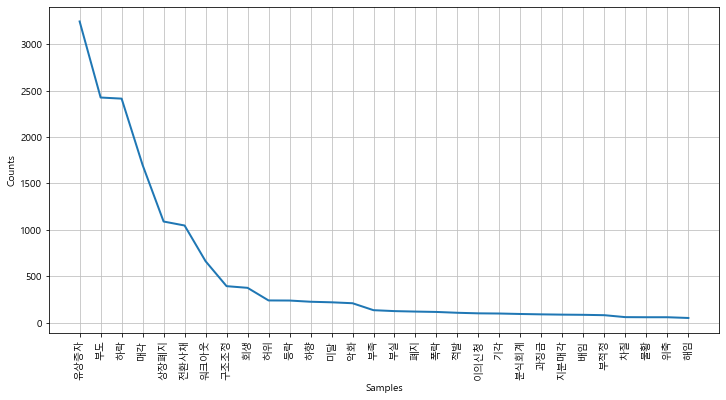

In [60]:
plt.figure(figsize=(12,6))
contents_total.plot(30) 
plt.show()

In [64]:
alice_mask = np.array(Image.open('data/wc2.alice_mask.png'))

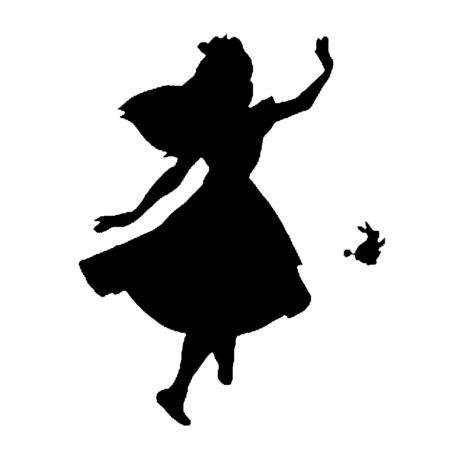

In [157]:
plt.figure(figsize=(8,8))
plt.imshow(alice_mask, cmap=plt.cm.gray, interpolation='bilinear')
plt.axis('off')
plt.show()

In [109]:
text = ' '.join([str(elem) for elem in text_])

In [110]:
wc = WordCloud(background_color='white', max_words=2000, mask=alice_mask,)

In [111]:
wc = wc.generate(text)

In [112]:
wc.words_

{'유상증자 유상증자': 1.0,
 '부도 부도': 0.7695883134130146,
 '하락 하락': 0.6839309428950863,
 '매각 매각': 0.38645418326693226,
 '전환사채': 0.25232403718459495,
 '하락 유상증자': 0.22244355909694555,
 '유상증자 하락': 0.2197875166002656,
 '상장폐지 상장폐지': 0.1892430278884462,
 '전환사채 전환사채': 0.1806108897742364,
 '워크아웃 워크아웃': 0.16865869853917662,
 '부도 상장폐지': 0.1646746347941567,
 '매각 유상증자': 0.15405046480743692,
 '유상증자 매각': 0.15405046480743692,
 '매각 하락': 0.11354581673306773,
 '하향': 0.1102257636122178,
 '악화': 0.1102257636122178,
 '유상증자 부도': 0.10889774236387782,
 '미달': 0.09561752988047809,
 '부도 유상증자': 0.0949535192563081,
 '하락 부도': 0.09362549800796813,
 '부도 하락': 0.09163346613545817,
 '부실': 0.08167330677290836,
 '유상증자 상장폐지': 0.08100929614873838,
 '폭락': 0.07569721115537849,
 '매각 부도': 0.07436918990703852,
 '회생 부도': 0.06905710491367861,
 '기각': 0.06440903054448871,
 '폐지': 0.06108897742363878,
 '회생 회생': 0.05976095617529881,
 '부도 매각': 0.05776892430278884,
 '매각 구조조정': 0.057104913678618856,
 '배임': 0.0551128818061089,
 '구조조정 매각': 0.05444887

In [128]:
heart= np.array(Image.open('data/wc5.heart.jpg'))

In [129]:
from wordcloud import ImageColorGenerator
image_colors = ImageColorGenerator(heart)

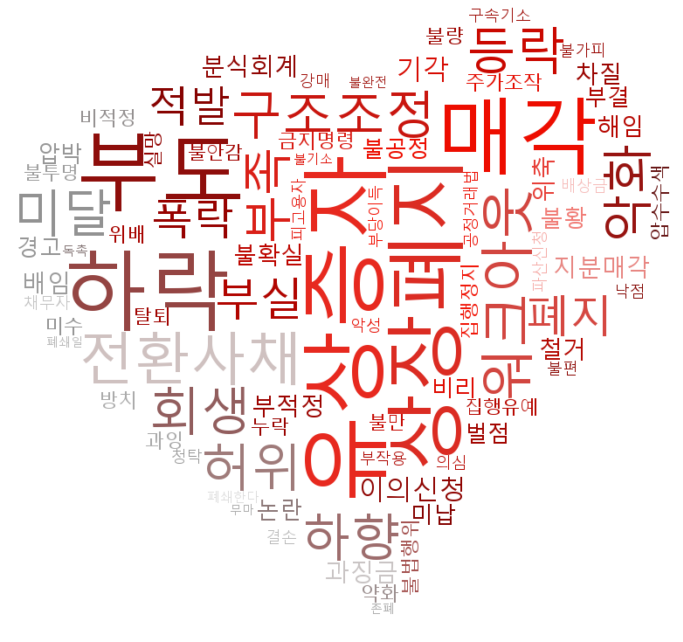

In [131]:
data = contents_total.vocab().most_common(300)

wordcloud = WordCloud(font_path='c:/Windows/Fonts/malgun.ttf',
               relative_scaling = 0.1, mask=heart,
               background_color = 'white',
               min_font_size=1,
               max_font_size=100).generate_from_frequencies(dict(data))

plt.figure(figsize=(12,12))
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation='bilinear')
plt.axis('off')
plt.show()

In [136]:
# LDA 자연러 처리
df3 =  pd.read_csv('data/네이버 기사55.csv')
df3['contents'].dropna(axis=0, inplace =True)
df3['contents'].isna().sum()

0

In [150]:
text = df3[['contents']]
text.head()

,contents
0,그래프 데코앤이 일봉 차트 표 거래원 상위 기준 이 시각 거래소에...
1,일 고가대비 급락종목 위 데코앤이 주가 리포트 일 시 분 기준 ...
2,일 데코앤이 하락종목 주가 리포트 일 시 분 현재 데코앤이 ...
3,일 코스닥 시장에서 하락한 종목으로 데코앤이 메지온...
4,그래프 데코앤이 일봉 차트 표 거래원 상위 기준 이 시각 거래소에...


In [177]:
# 텍스트 전처리
import nltk
contents_total = text.apply(lambda row: nltk.word_tokenize(str(row)), axis=1)
text.head()

,contents
0,'그래프 '데코앤이 '거래원 '거래소에서 '데코앤이 '이외에도 '남선알미늄 '뉴인텍...
1,'고가대비 '급락종목 '데코앤이 '리포트 '데코앤이는 '상승하였으나 '거래되고 '데...
2,'데코앤이 '하락종목 '리포트 '데코앤이 '올랐으나 '거래되고 '거래일과 '비교해 ...
3,'코스닥 '시장에서 '하락한 '종목으로 '데코앤이 '메지온 '동일철강 '전문기업 '...
4,'그래프 '데코앤이 '거래원 '거래소에서 '데코앤이 '이외에도 '오가닉티코스메틱 '...


In [180]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
a = contents_total.apply(lambda x: [word for word in x if word not in (stop)])
a.head()

0    [contents, '그래프, '데코앤이, '거래원, '거래소에서, '데코앤이, '...
1    [contents, '고가대비, '급락종목, '데코앤이, '리포트, '데코앤이는, ...
2    [contents, '데코앤이, '하락종목, '리포트, '데코앤이, '올랐으나, '...
3    [contents, '코스닥, '시장에서, '하락한, '종목으로, '데코앤이, '메...
4    [contents, '그래프, '데코앤이, '거래원, '거래소에서, '데코앤이, '...
dtype: object

In [166]:
from nltk.stem import WordNetLemmatizer
text['contents'] = text['contents'].apply(lambda x : [WordNetLemmatizer().lemmatize(word, pos='v') for word in x])
text.head()

C:\ProgramData\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,contents
0,"[[, '그래프, ', ,, '데코앤이, ', ,, '일봉, ', ,, '차트, '..."
1,"[[, ', 일, ', ,, '고가대비, ', ,, '급락종목, ', ,, ', 위..."
2,"[[, ', 일, ', ,, '데코앤이, ', ,, '하락종목, ', ,, '주가,..."
3,"[[, ', 일, ', ,, '코스닥, ', ,, '시장에서, ', ,, '하락한,..."
4,"[[, '그래프, ', ,, '데코앤이, ', ,, '일봉, ', ,, '차트, '..."


In [167]:
tokenized_doc = text['contents'].apply(lambda x : [word for word in x if len(word) > 3])
tokenized_doc[:5]

0    ['그래프, '데코앤이, '거래원, '거래소에서, '데코앤이, '이외에도, '남선알...
1    ['고가대비, '급락종목, '데코앤이, '리포트, '데코앤이는, '상승하였으나, '...
2    ['데코앤이, '하락종목, '리포트, '데코앤이, '올랐으나, '거래되고, '거래일...
3    ['코스닥, '시장에서, '하락한, '종목으로, '데코앤이, '메지온, '동일철강,...
4    ['그래프, '데코앤이, '거래원, '거래소에서, '데코앤이, '이외에도, '오가닉...
Name: contents, dtype: object

In [168]:
# TF-IDF 행렬만들기
# 역토큰화
detokenized_doc = []
for i in range(len(text)):
    t = ' '.join(tokenized_doc[i])
    detokenized_doc.append(t)
text['contents'] = detokenized_doc
# 다시 text['contents'] 에 저장
text.head()

C:\ProgramData\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,contents
0,'그래프 '데코앤이 '거래원 '거래소에서 '데코앤이 '이외에도 '남선알미늄 '뉴인텍...
1,'고가대비 '급락종목 '데코앤이 '리포트 '데코앤이는 '상승하였으나 '거래되고 '데...
2,'데코앤이 '하락종목 '리포트 '데코앤이 '올랐으나 '거래되고 '거래일과 '비교해 ...
3,'코스닥 '시장에서 '하락한 '종목으로 '데코앤이 '메지온 '동일철강 '전문기업 '...
4,'그래프 '데코앤이 '거래원 '거래소에서 '데코앤이 '이외에도 '오가닉티코스메틱 '...


In [170]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X = vectorizer.fit_transform(text['contents'])
X.shape

(53000, 1000)

In [171]:
from sklearn.decomposition import LatentDirichletAllocation
lda_model = LatentDirichletAllocation(n_components=10, learning_method='online', random_state=777, max_iter=1)
lda_top = lda_model.fit_transform(X)
print(lda_model.components_)
print(lda_model.components_.shape)

[[1.00007375e-01 1.03991989e-01 1.00001062e-01 ... 1.00005115e-01
  1.00018117e-01 1.00014451e-01]
 [1.00038314e-01 1.00814567e-01 1.00000938e-01 ... 1.00012000e-01
  1.00012860e-01 1.00015005e-01]
 [4.13925417e+02 1.00299119e-01 1.03471219e-01 ... 1.00003929e-01
  1.00013241e-01 1.21217528e+02]
 ...
 [1.00006258e-01 1.00001941e-01 1.00002045e-01 ... 1.00002805e-01
  1.00002976e-01 1.00008041e-01]
 [1.00008334e-01 1.01078774e-01 1.00006131e-01 ... 1.00011633e-01
  1.00007000e-01 1.00005534e-01]
 [1.00014140e-01 1.00001134e-01 1.00001146e-01 ... 1.00021063e-01
  1.00019977e-01 1.00270534e-01]]
(10, 1000)


In [172]:
terms = vectorizer.get_feature_names() 

In [173]:
def get_topics(components, feature_names, n=5):
    for idx, topic in enumerate(components):
        print("Topic %d :" % (idx+1), [(feature_names[i], topic[i].round(2)) for i in topic.argsort()[:-n -1:-1]])
get_topics(lda_model.components_, terms)

Topic 1 : [('피어리스', 874.6), ('것으로', 512.99), ('지난해', 411.49), ('그러나', 383.39), ('소프트웨어', 363.9)]
Topic 2 : [('코리아', 392.87), ('가운데', 367.66), ('상한가', 336.02), ('종목은', 317.08), ('상한가를', 232.83)]
Topic 3 : [('아이씨켐', 802.68), ('관계자는', 456.19), ('가격제한폭까지', 413.93), ('주가가', 357.95), ('인터넷', 351.39)]
Topic 4 : [('심스밸리', 929.32), ('코닉스', 636.04), ('역삼동', 211.88), ('호성케멕스', 207.19), ('반도체', 190.12)]
Topic 5 : [('머니투데이', 1278.94), ('디지텔', 1060.32), ('이밖에', 294.28), ('자사주', 261.09), ('코리아링크는', 258.37)]
Topic 6 : [('코리아링크', 1380.5), ('따르면', 352.49), ('울산시', 270.11), ('등이다', 240.44), ('시스컴은', 228.26)]
Topic 7 : [('계몽사', 1018.99), ('밝혔다', 724.77), ('규모의', 634.37), ('일부터', 449.18), ('일까지', 435.53)]
Topic 8 : [('휴대폰', 294.84), ('단말기', 244.22), ('서초동', 168.86), ('제조업체인', 143.65), ('원으로', 142.01)]
Topic 9 : [('텔슨전자', 1107.63), ('삼한콘트롤스', 779.93), ('삼산동', 634.56), ('소프트윈', 621.73), ('아진산업', 288.61)]
Topic 10 : [('유니씨앤티', 1105.06), ('시스컴', 585.89), ('금강화섬', 411.71), ('테크메이트', 317.18), ('모닷텔', 292.74)]


In [174]:
## LDA 시각화 하기
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
pyLDAvis.display(vis)

NameError: name 'ldamodel' is not defined

In [204]:
# temp_list = []
# count = 0
# for temps1, temps2 in zip(temp['list'], temp['count']):
#     if count == 30:
#         break
#     else:
#         temp_list.append("('%s', %d)" %(temps1, temps2))
# #         print()

In [207]:
temp_list = [a.replace("\"", "") for a in temp_list]

In [209]:
temp_list[0]

"('하락', 909)"

In [215]:
plt.figure(figsize=(12,6))
temp_list.plot(30) 
plt.show()

AttributeError: 'list' object has no attribute 'plot'

<Figure size 864x432 with 0 Axes>

In [173]:
text_ = [a for a in contents_total if a not in stop_words]

KeyboardInterrupt: 

In [97]:
wc = WordCloud(background_color='white', max_words=2000, mask=alice_mask,)
wc = wc.generate(contents)
wc.words_

TypeError: expected string or bytes-like object

In [14]:
def word_count(contents):
    wordlist = sum(contents, [])
    word_list = pd.Series(wordlist)
    result = word_list.value_counts()
    print(result)

In [41]:
word_count(contents)

억원     11717
공시      8277
산업      7480
전자      7464
텍       6915
       ...  
성균관        1
전진수        1
정원석        1
강인수        1
북새통        1
Length: 29712, dtype: int64


In [64]:
sw_text = ' '.join([str(elem) for elem in set(contents,tokens)])
print(sw_text)

ModuleNotFoundError: No module named 'Konlpy'

In [57]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['axes.unicode_minus'] = False   # minus 표시
plt.rcParams["font.family"] = 'Malgun Gothic'
plt.rcParams["font.size"] = 10
%matplotlib inline

plt.figure(figsize=(8,8))
plt.imshow(alice_mask, cmap=plt.cm.gray, interpolation='bilinear')
plt.axis('off')
plt.show()

NameError: name 'alice_mask' is not defined

<Figure size 576x576 with 0 Axes>

In [109]:
for i in range(len(contents)):
    for j in range(len(contents[i])):
        wc[contents[i][j]] = wc.get(contents[i][j], 0) + 1
        keys = sorted(wc.keys())

NameError: name 'contents' is not defined

In [26]:
for word in keys:
    print(word + ':'+str(wc[word]))

가가:30
가격:207
가결:2
가공:20
가공업:13
가구:27
가기:2
가까스로:2
가까이:24
가끔:2
가나:1
가나다:1
가늠:1
가능:13
가능성:52
가담:1
가도:1
가동:5
가득:23
가든:1
가디건:1
가뜩이나:2
가라:5
가량:31
가려진:1
가로:38
가로수길:12
가뭄:2
가바:7
가비아:9
가사:1
가설:1
가속:1
가속도:1
가수:5
가스:301
가스터빈:1
가스프롬:5
가스하이드레이트:1
가시:4
가압류:3
가액:170
가약:2
가연성:4
가열:2
가온:13
가요:1
가운데:211
가율:1
가을:6
가이던스:3
가이드:4
가인:9
가입:3
가입자:3
가장:103
가장납입:1
가재:2
가전:3
가전제품:1
가정:2
가주:2
가중:10
가지:14
가창:3
가처분:17
가출:2
가치:53
가칭:3
가파르:1
가파른:3
가해:2
가희:1
각:11
각각:234
각계:2
각국:1
각기:1
각성:2
각오:2
각자:76
각종:15
각층:2
각하:3
간다:3
간담:42
간사:6
간암:1
간의:4
간전:8
간접:3
간판:2
간호:1
갈등:8
갈수록:2
감가상각:1
감각:13
감당:1
감독:11
감동:1
감리:2
감마:3
감별:1
감사:209
감사원:2
감사패:1
감상:2
감성:15
감소:125
감시:4
감시카메라:1
감안:6
감응:2
감자:95
감자전:2
감전:1
감촉:1
감축:2
감치:1
갑자기:2
값:12
강:37
강경아:3
강관:20
강관주:3
강구:1
강남:17
강남구:10
강도:24
강도원:1
강동엽:1
강등:2
강력:1
강령:6
강매:3
강변:3
강복:2
강북구청:2
강사:5
강산:1
강서구:1
강성:30
강성훈:4
강세:179
강소기업:11
강소라:2
강수:4
강스:9
강신호:2
강연:12
강용:1
강우석:1
강원:39
강원도:6
강원랜드:4
강의:24
강재:3
강점:5
강제:1
강제집행:2
강조:6
강종:135
강주:2
강준:8
강준구:2
강지연:6
강철:17
강태윤:1
강판:4
강혜정:1
강호:1
강화:48
강화도:2
강휘호:1
개국:

In [27]:
df2 = pd.DataFrame(zip(wc.keys(), wc.values()), columns=['list', 'count'])

In [28]:
df2 = df2.sort_values(by=['count'], axis=0, ascending=False)

In [31]:
df2 = df2.reset_index(drop=True)
df2.head()

,list,count
0,데코,4752
1,텍,3366
2,한솔,2952
3,억원,2914
4,에이치,2652


In [14]:
df['contents'] = df['contents'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣]"," ")

In [15]:
stopwords = ['을', '로', '의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다''의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [16]:
hannanum = Hannanum()

In [17]:
okt = Okt()

In [18]:
contents = []

In [19]:
for sentence in tqdm(df['contents']):
    temp_x = []
    temp_x = okt.nouns(sentence)
    temp_x = [word for word in temp_x if not word in stopwords]
    contents.append(temp_x)

In [22]:
word_count(contents, 'VK')

VK Save compelte
